<h1 align="center" style="background-color:DodgerBlue;">Prueba II - Machine Learning </h1>

### Contexto
En esta ocasión trabajaremos con datos públicos del departamento de policía de New York. El dataset es llamado stop_and_frisk_data y contiene información sobre interrogaciones y detenciones realizadas por el departamento de policía de NY en la vía pública. El diccionario de atributos se encuentra en el archivo 2009 SQF File Spec.xls.
Para todo nuestro estudio utilizaremos los datos correspondientes al año 2009 como conjunto de entrenamiento y los datos del 2010 como conjunto de pruebas. Hay que hacer notar que los datos que estamos utilizando son un muestreo del de la cantidad de registros reales que contiene el dataset, esta decisión fue tomada debido a los largos tiempos de entrenamiento y procesamiento que requiere el volumen de datos reales.

Descripción del problema y objetivos
Utilizando el dataset stop_and_frisk_data.csv , el que corresponde a datos públicos del departamento policial de Nueva York, se abordarán dos problemas de clasificación binaria.

Primero, se requiere predecir si un determinado precedimiento policial concluirá en un arresto o no, para ello se generará un modelos predictivos, el que será depurado según los resultados de las métricas resultantes. La variable objetivo es 'arstmade'.

Segundo, se requiere predecir si el procedimiento policial concluirá en una acción violenta, para ellos se generará un nueva variable objetivo llamada 'force_police' que incluye atributos que indican violencia, como 'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_baton', entre otros. 

Para ambos problemas, se utilizarán los datos correspondientes al año 2009 como conjunto de entrenamiento y los datos del 2010 como conjunto de test.

Aspectos Computacionales

In [1]:
# Importacuiones clasicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Informacion del sistema y datos perdidos
from sinfo import sinfo
import missingno as msngo

# Buscador de modelos
from lazypredict.Supervised import LazyClassifier, LazyRegressor

# MAchine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification

# Importaaciones especializadas
import preproc_nyc_sqf as func

# Otras importaciones y intancias para este desafio
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

Para el procesamiento se utilizara la funcion auxiliar preproc_nyc_sqf.py la cual, realizara una limpieza del df. Las metricas a reportar seran Precision, recall, f1, y accuracy.

Los 5 modelos con una grilla de hiperparámetros tentativa

1.Para LogisticRegression:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty': ['l1', 'l2']}

2.Para Random Forest:
params = {'max_features':[None, 'log2', 'sqrt'], 'n_estimators': [50,100,150,200,250,500], 'max_depth':[None, 2, 5, 7, 10]}
    
3.Para AdaBoostClassifier:
params = {'learning_rate': [0.01, 0.1,0.5],'n_estimators': [50, 100, 500, 1000, 2000]}

4.Para GradientBoostingClassifier:
params = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000],'subsample': [0.1, 0.5, 0.9]}

5.Para SVC:
params = {'C': 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],'gamma': 'C': [0.00001, 0.0001, 0.001, 0.01, 1, 10]}

In [2]:
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
lazypredict         0.2.12
matplotlib          3.5.3
missingno           0.5.1
numpy               1.21.5
pandas              1.4.4
preproc_nyc_sqf     NA
seaborn             0.12.1
sinfo               0.3.4
sklearn             1.1.3
-----
IPython             7.31.1
jupyter_client      7.4.7
jupyter_core        4.11.2
jupyterlab          3.5.0
notebook            6.5.2
-----
Python 3.9.12 (main, Apr  5 2022, 01:53:17) [Clang 12.0.0 ]
macOS-10.16-x86_64-i386-64bit
8 logical CPU cores, i386
-----
Session i

In [3]:
help(func.create_suitable_dataframe)
help(func.dist_box)

Help on function create_suitable_dataframe in module preproc_nyc_sqf:

create_suitable_dataframe(df)
    TODO: Crea un dataframe apto para entrenamiento de acuerdo a normas básicas de limpieza de datos faltantes,
        transformación de etiquetas nulas en variables categóricas y crea atributos sinteticos de edad del sospechoso
         y conversión de distancia a sistema metrico.
    Argumentos:
        - df: Un objeto pandas.DataFrame 
    returns:

Help on function dist_box in module preproc_nyc_sqf:

dist_box(data)
    Funcion que imprime grafico de las distribuciones de un 
    dataframe completo.
    Args:
        data (DataFrame): Conjunto de datos
    Returns:
        distplots: con todas las variables del df



In [4]:
# carga set dfe datos
df_2009 = pd.read_csv('2009_1perc.csv').drop(columns = ['Unnamed: 0', 'year'])
df_2010 = pd.read_csv('2010_1perc.csv').drop(columns = ['Unnamed: 0', 'year'])

In [5]:
df_2009.shape

(5812, 110)

<AxesSubplot:>

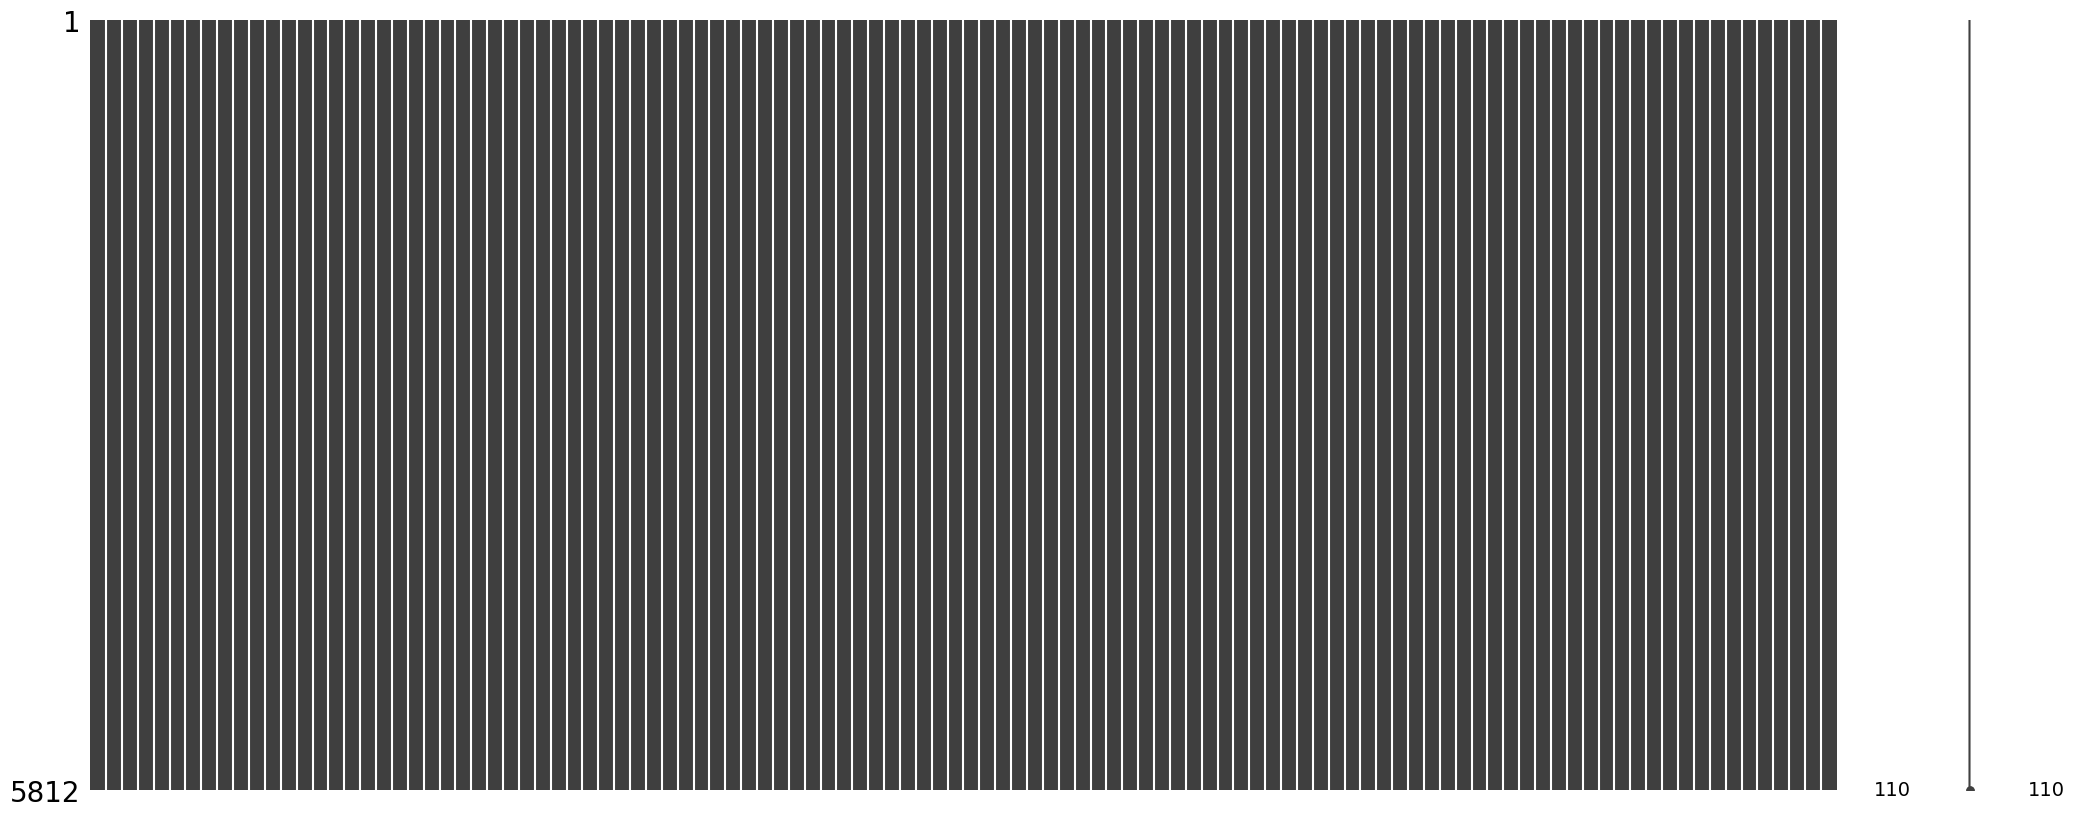

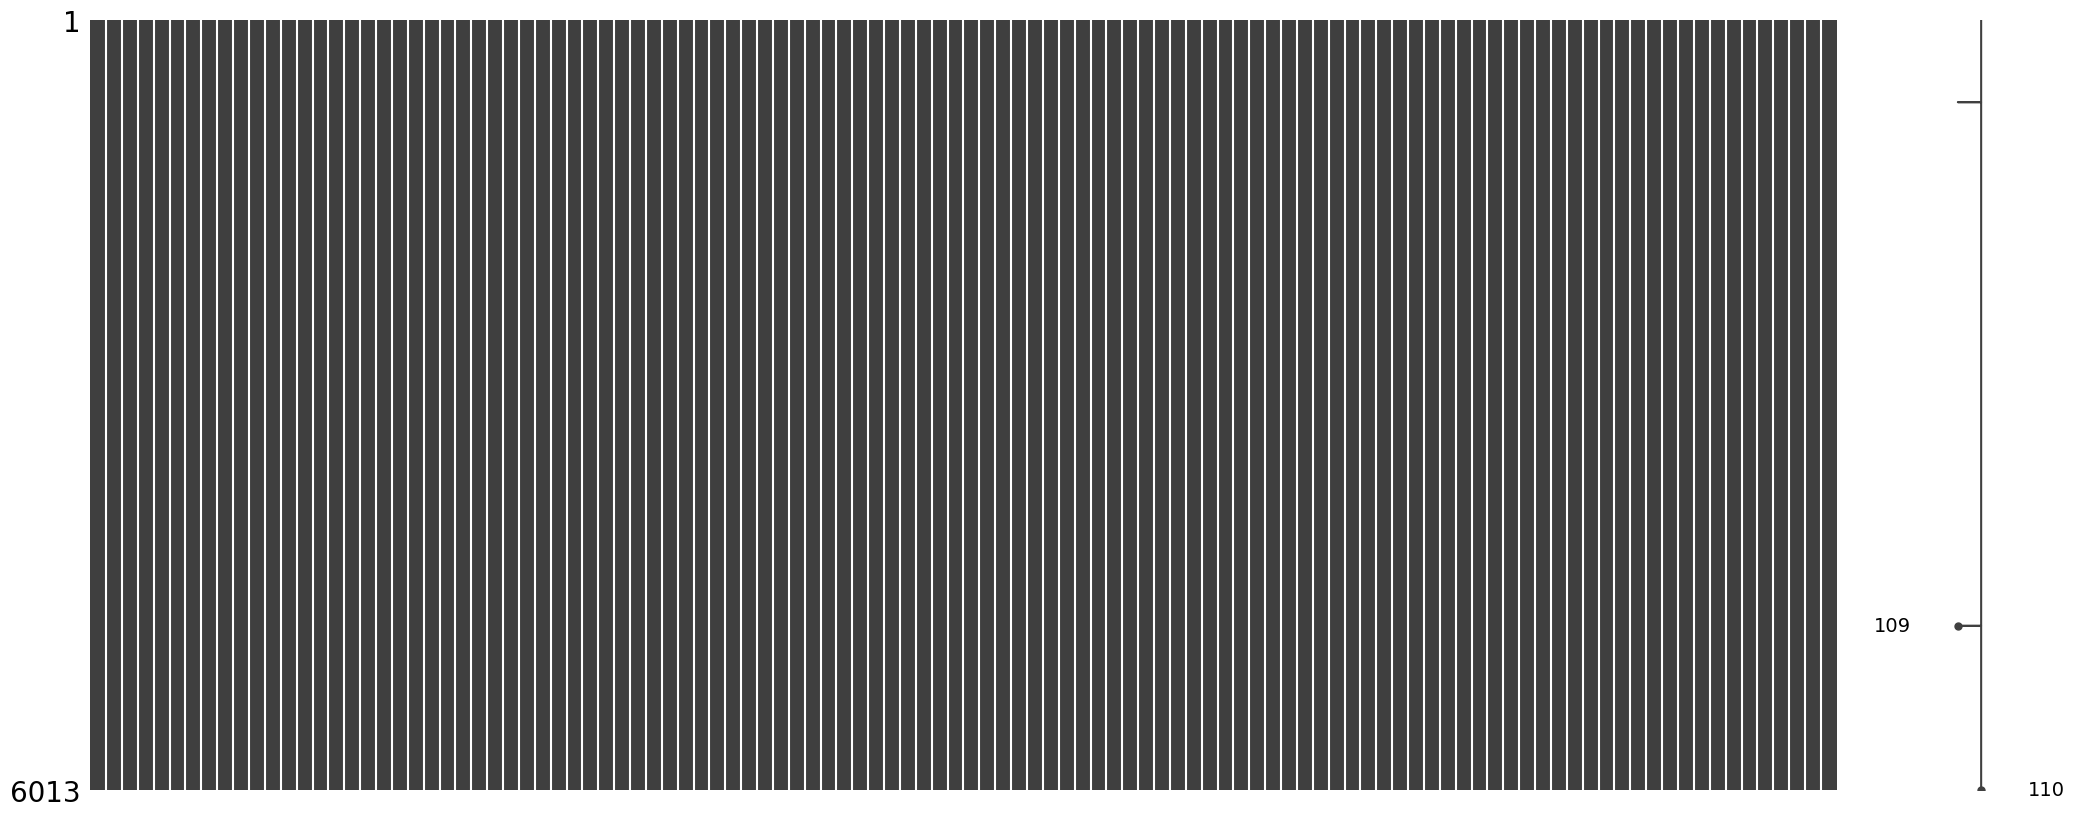

In [6]:
msngo.matrix(df_2009)
msngo.matrix(df_2010)

In [7]:
# Instanciacion de funciones especiales para este desafio
proc_df, suitable_categorical_attributes, suitable_numerical_attributes = func.create_suitable_dataframe(df_2009)

['pct', 'ser_num', 'datestop', 'timestop', 'perstop', 'compyear', 'comppct', 'repcmd', 'revcmd', 'dob', 'age', 'ht_feet', 'ht_inch', 'weight', 'addrpct', 'linecm', 'detailcm', 'perobs']


In [8]:
# Revision de DataFrame proc_df
proc_df

recstat inout trhsloc typeofid explnstp othpers arstmade sumissue  \
0          A     O       P        P        Y       N        N        N   
2          1     O       P        V        Y       N        N        N   
3          A     O       P        P        Y       N        N        N   
5          1     I       T        V        Y       N        N        N   
6          1     O       P        P        Y       N        N        N   
...      ...   ...     ...      ...      ...     ...      ...      ...   
5806       A     O       P        V        Y       Y        N        N   
5808       A     O       P        P        Y       N        N        N   
5809       1     O       P        P        Y       N        N        N   
5810       1     O       H        P        Y       N        Y        N   
5811       1     O       H        P        Y       N        N        N   

     offunif officrid  ... race haircolr eyecolor build       city sector  \
0          Y        N  ...    B       BK       BR     M      BRONX      G   
2          N        N  ...    Q       BR       BR     M      BRONX      E   
3          Y        N  ...    B       BK       BR     T   BROOKLYN      J   
5          N        Y  ...    B       BK       BR     M  MANHATTAN      F   
6          Y        N  ...    B       BK       BR     T   BROOKLYN      N   
...      ...      ...  ...  ...      ...      ...   ...        ...    ...   
5806       Y        N  ...    B       BK       BR     M      BRONX      N   
5808       N        N  ...    B       BK       BR     T   BROOKLYN      F   
5809       Y        N  ...    B       BK       BR     M   BROOKLYN      B   
5810       Y        N  ...    B       BK       BR     T   BROOKLYN      A   
5811       Y        N  ...    U       BK       BR     M  MANHATTAN      D   

     beat post month meters  
0       7          4   1.80  
2       U         10   1.92  
3       4   35    12   1.68  
5      16          5   1.77  
6       U         11   1.56  
...   ...  ...   ...    ...  
5806    U    3     5   1.55  
5808   17          9   1.56  
5809    U          6   1.74  
5810   10          3   1.77  
5811    U          5   1.83  

[4636 rows x 74 columns]

In [9]:
proc_df_plot = pd.DataFrame()

for colums in proc_df.columns:
    proc_df_plot[colums] = LabelEncoder().fit_transform(proc_df[colums])

A continuación se presenta el analisis exploratorio del DF

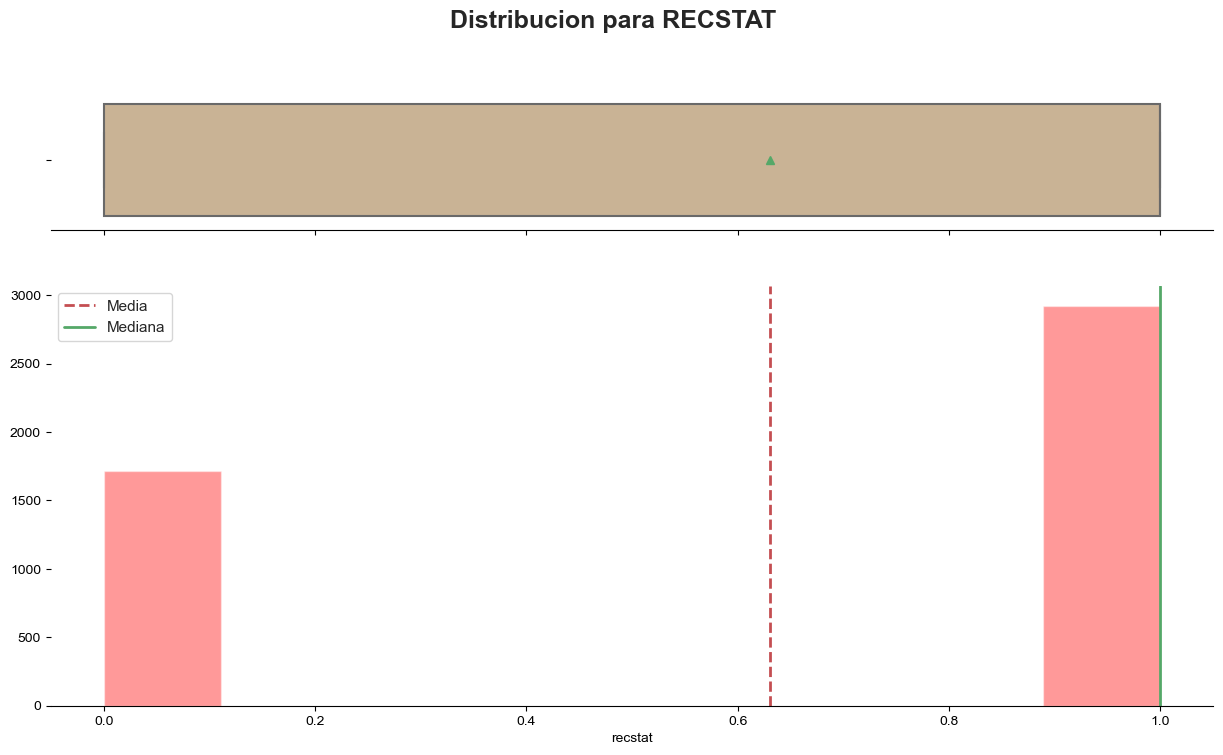

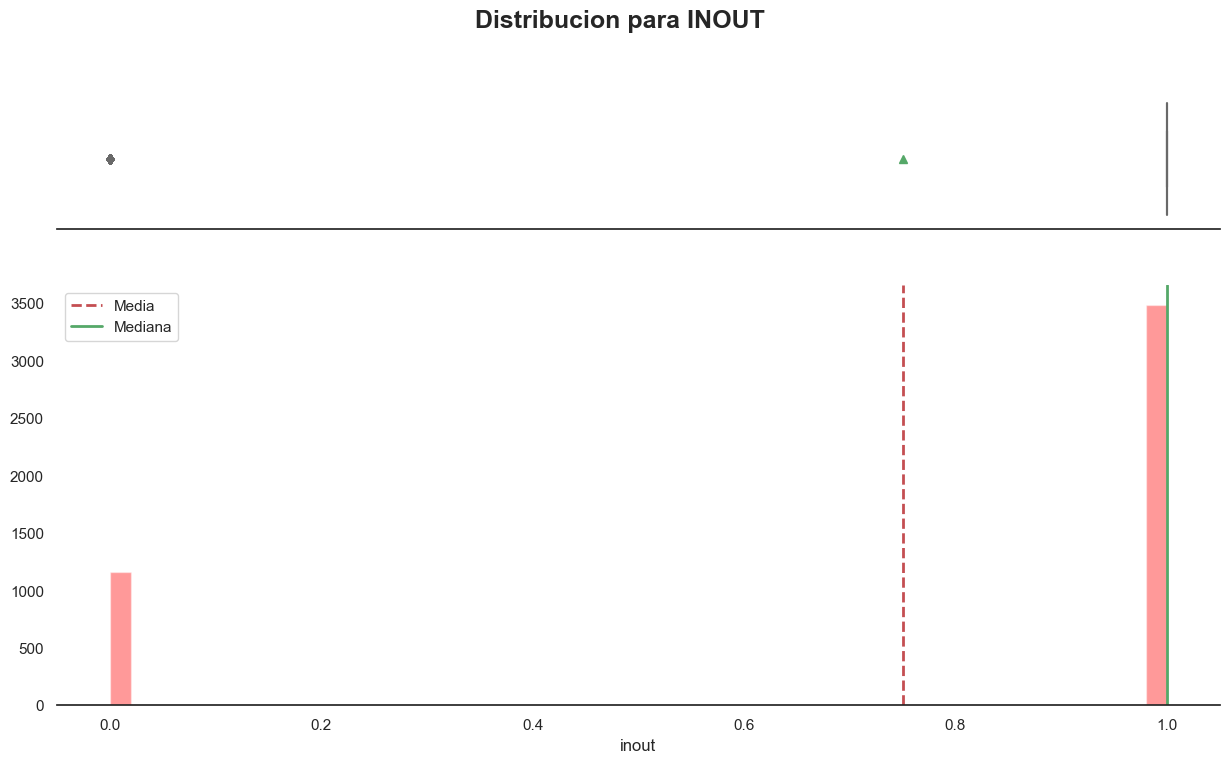

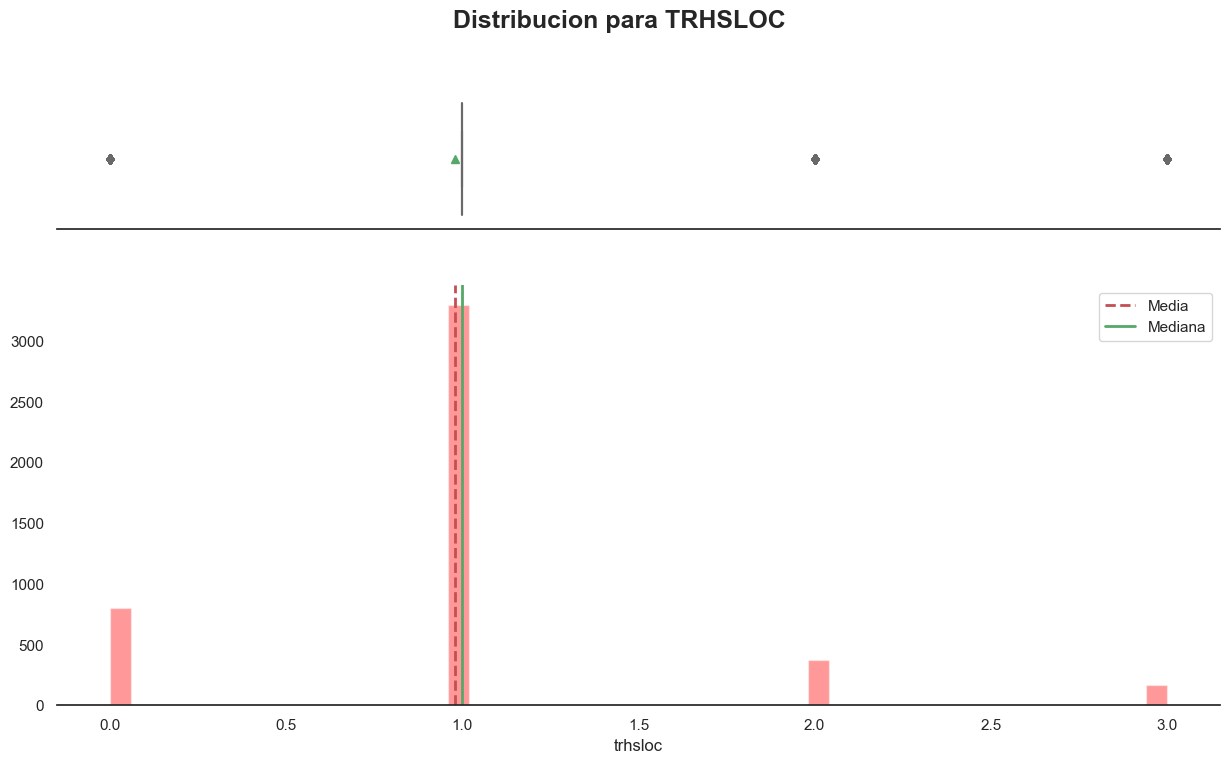

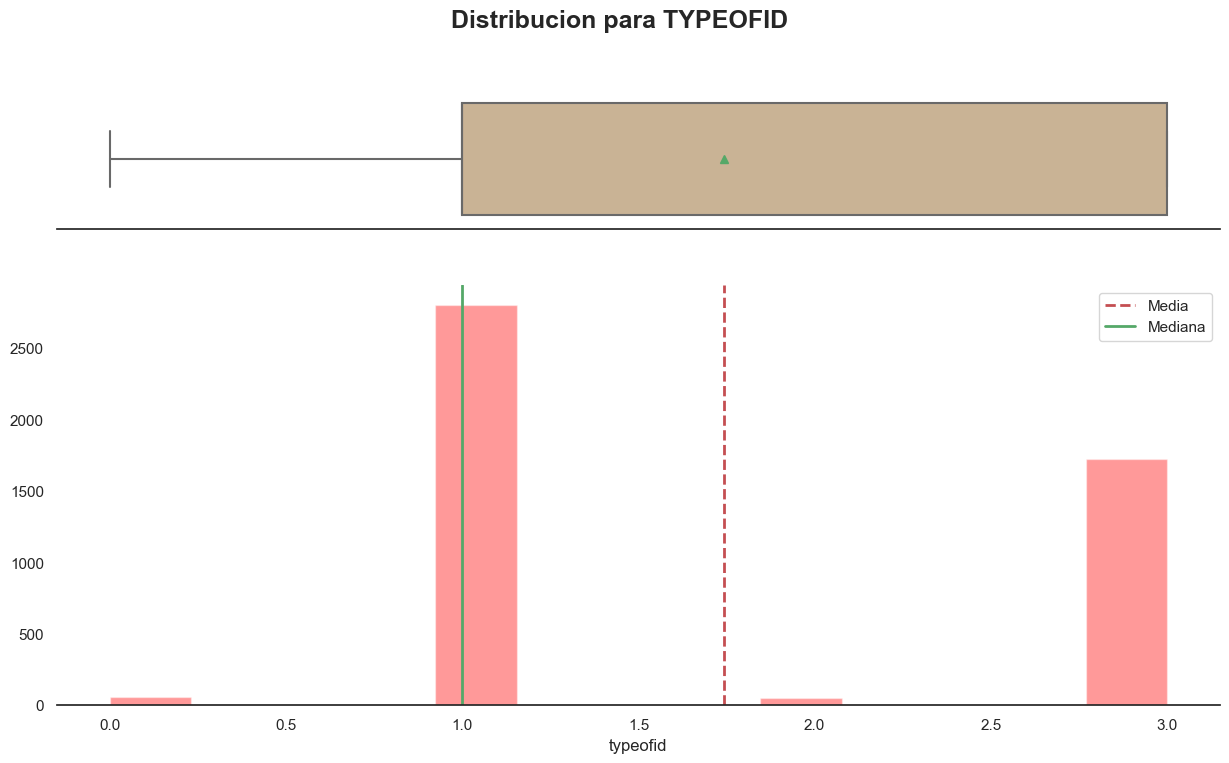

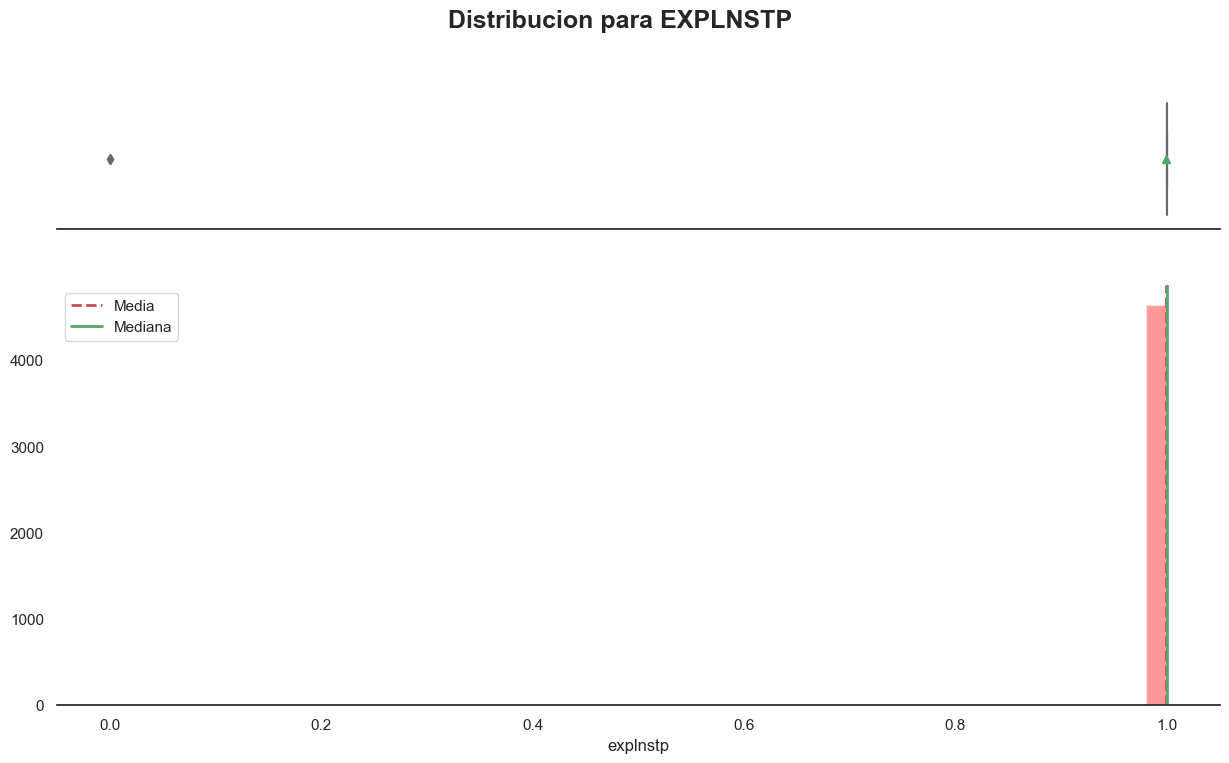

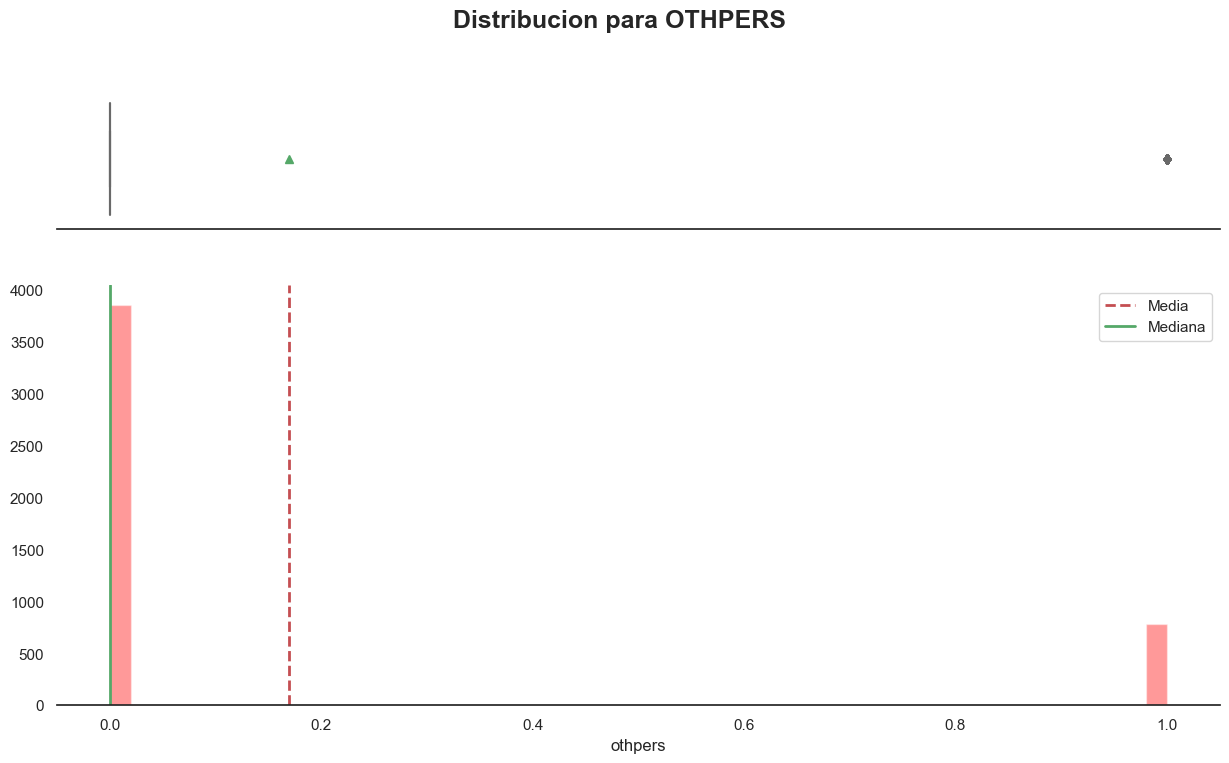

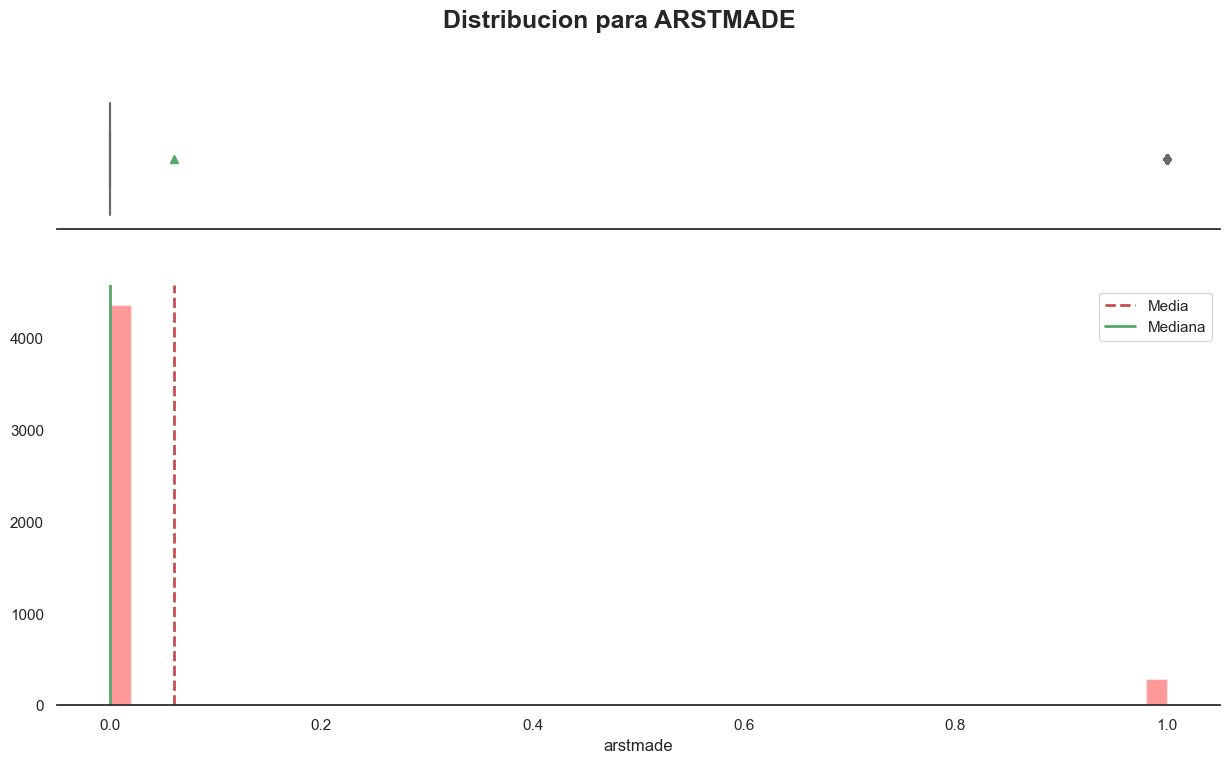

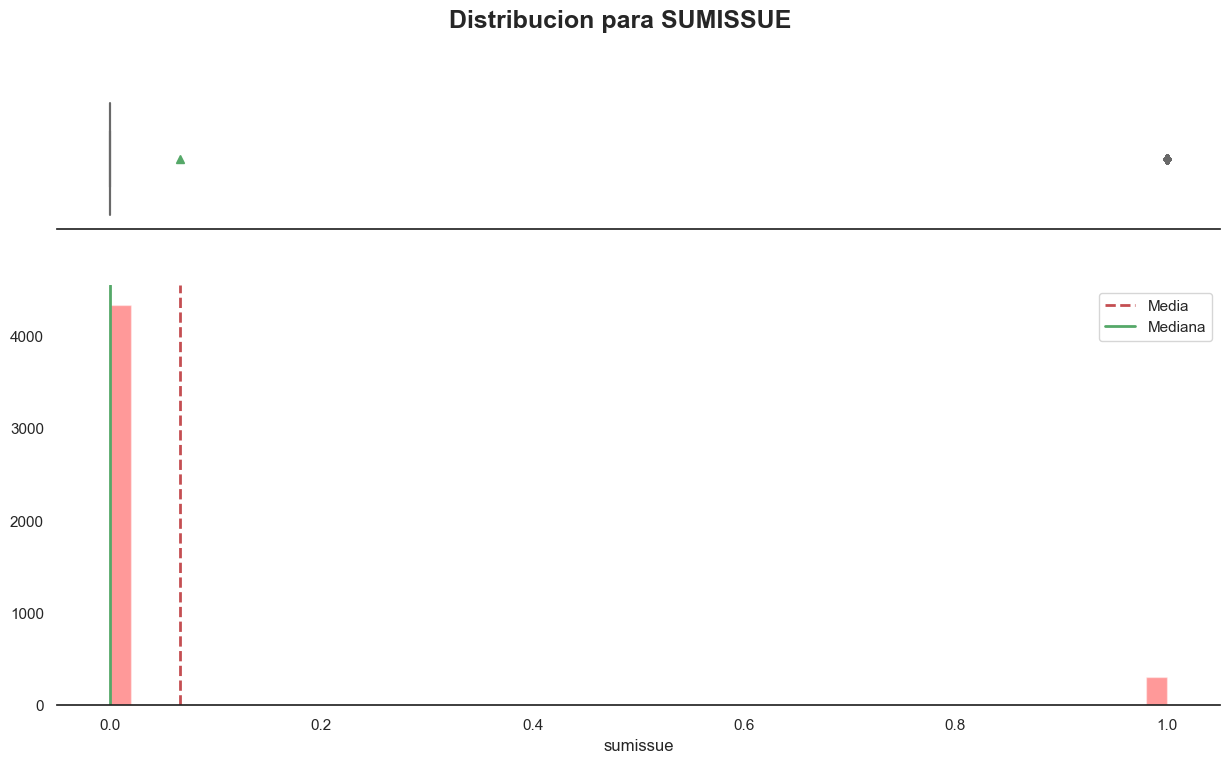

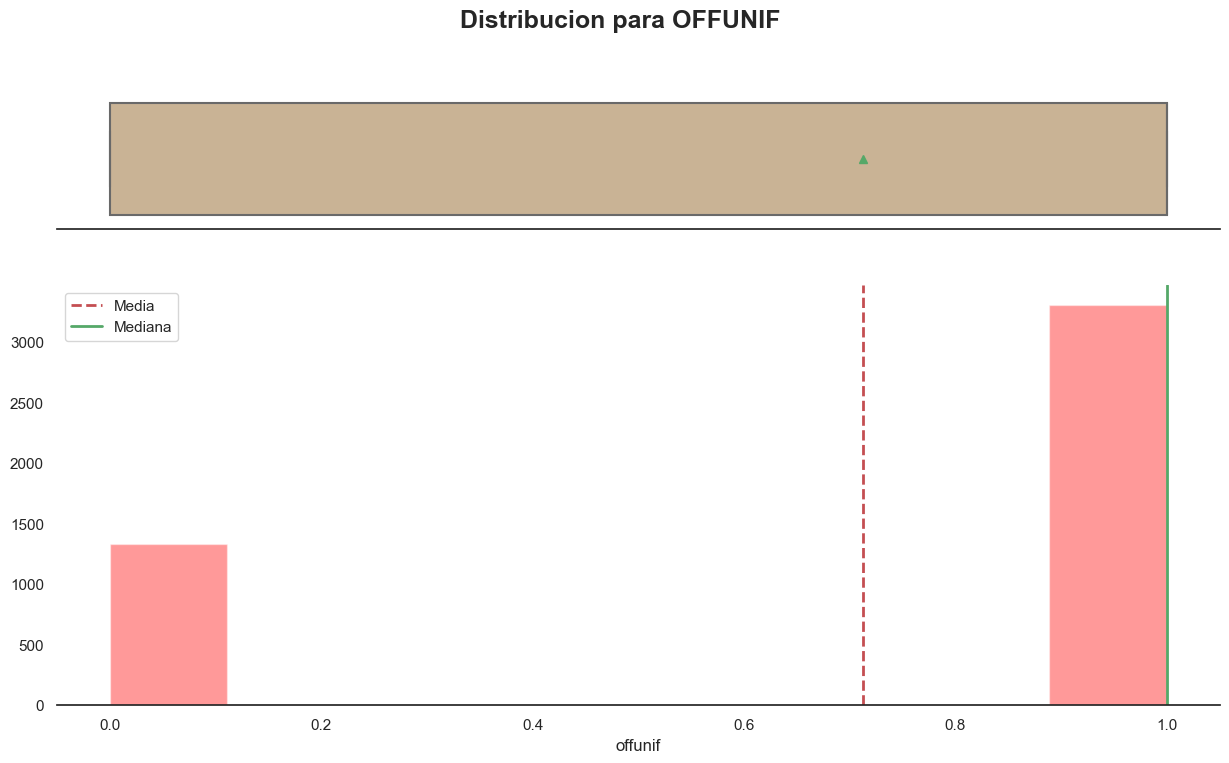

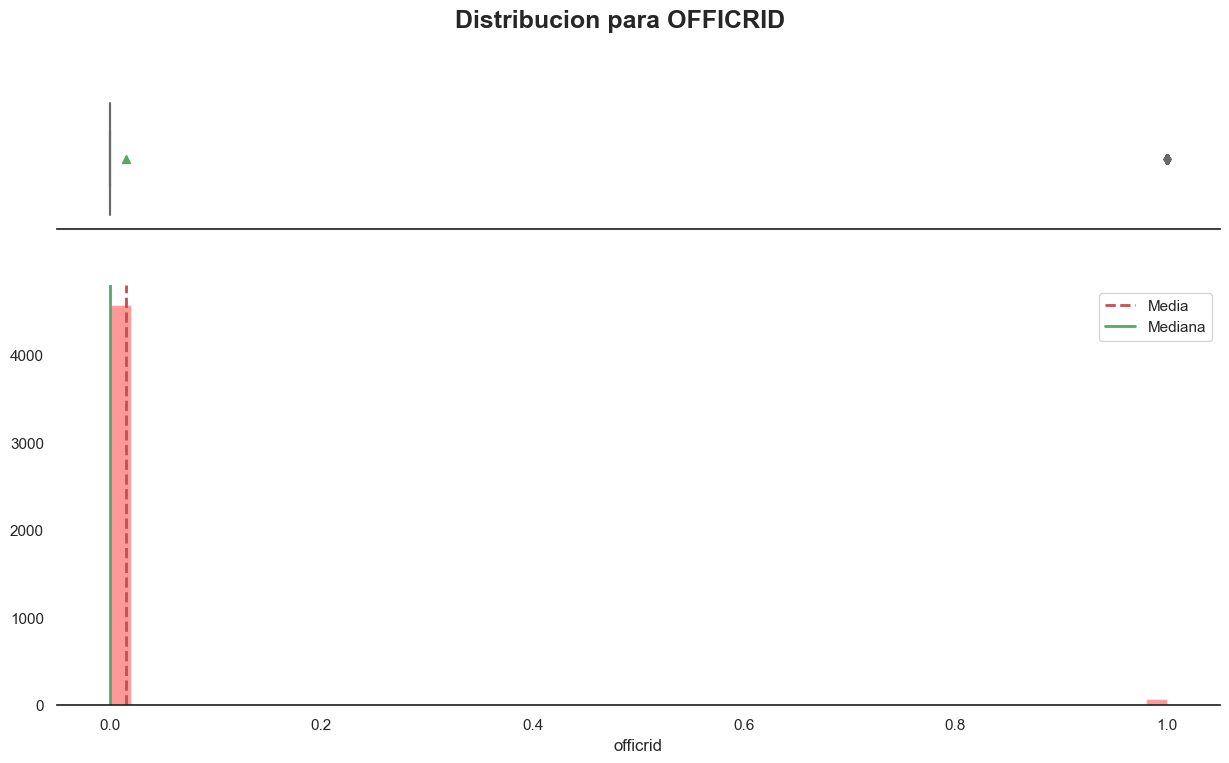

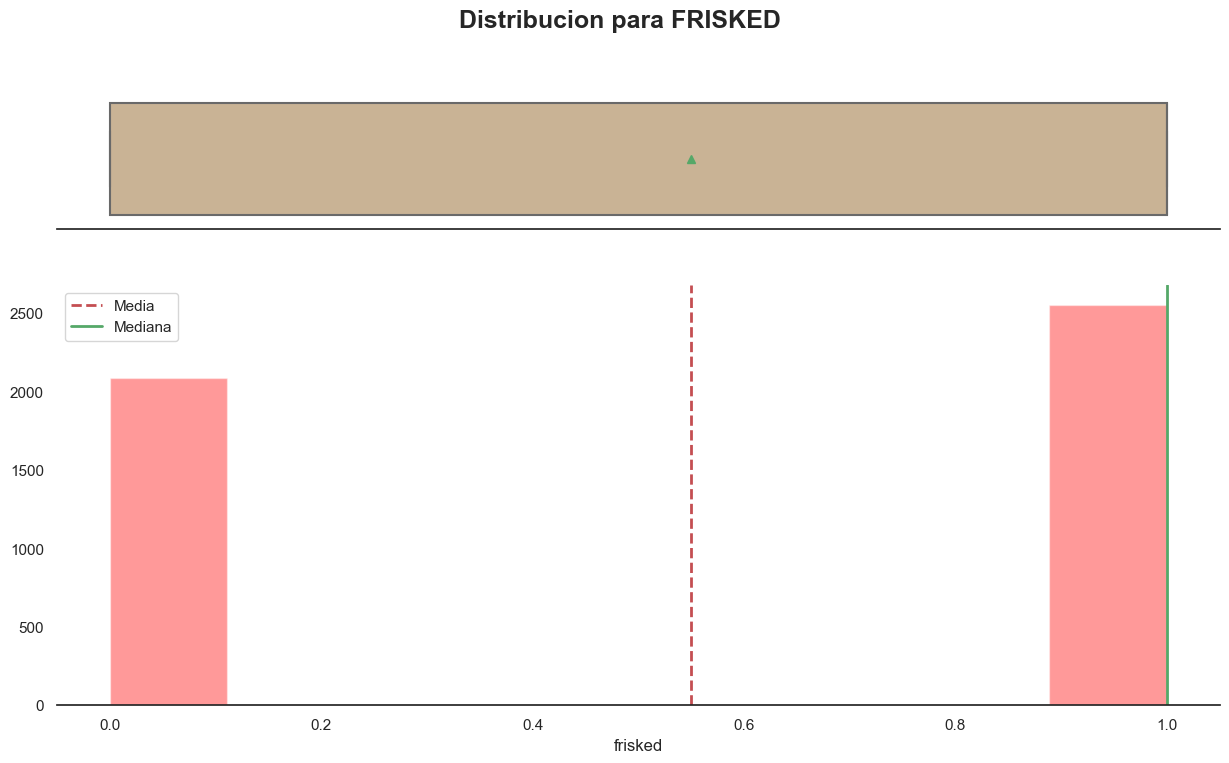

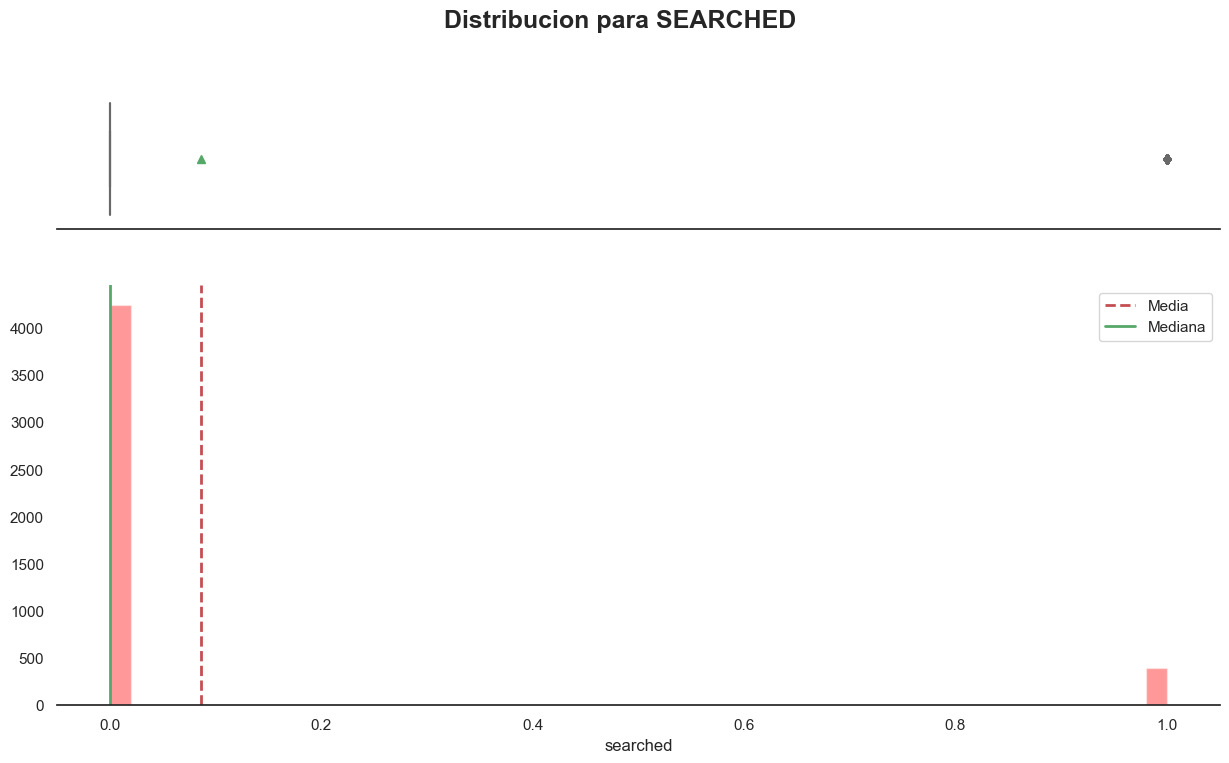

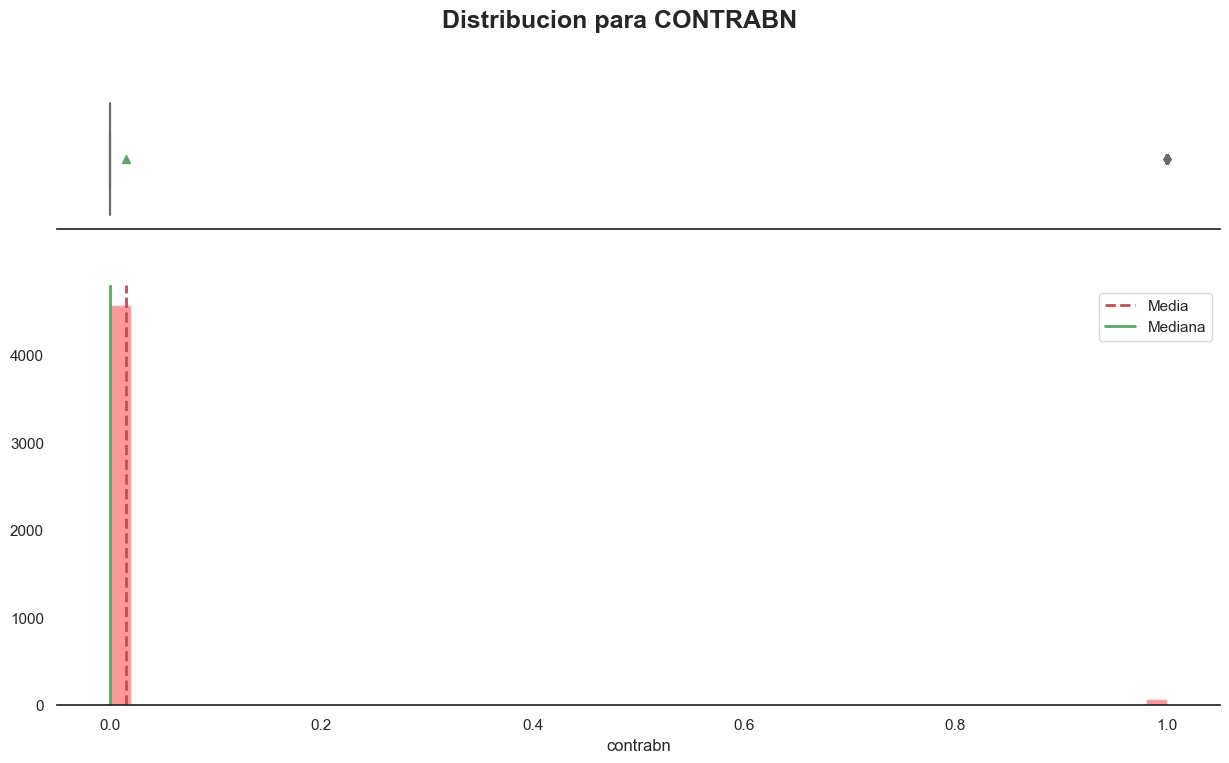

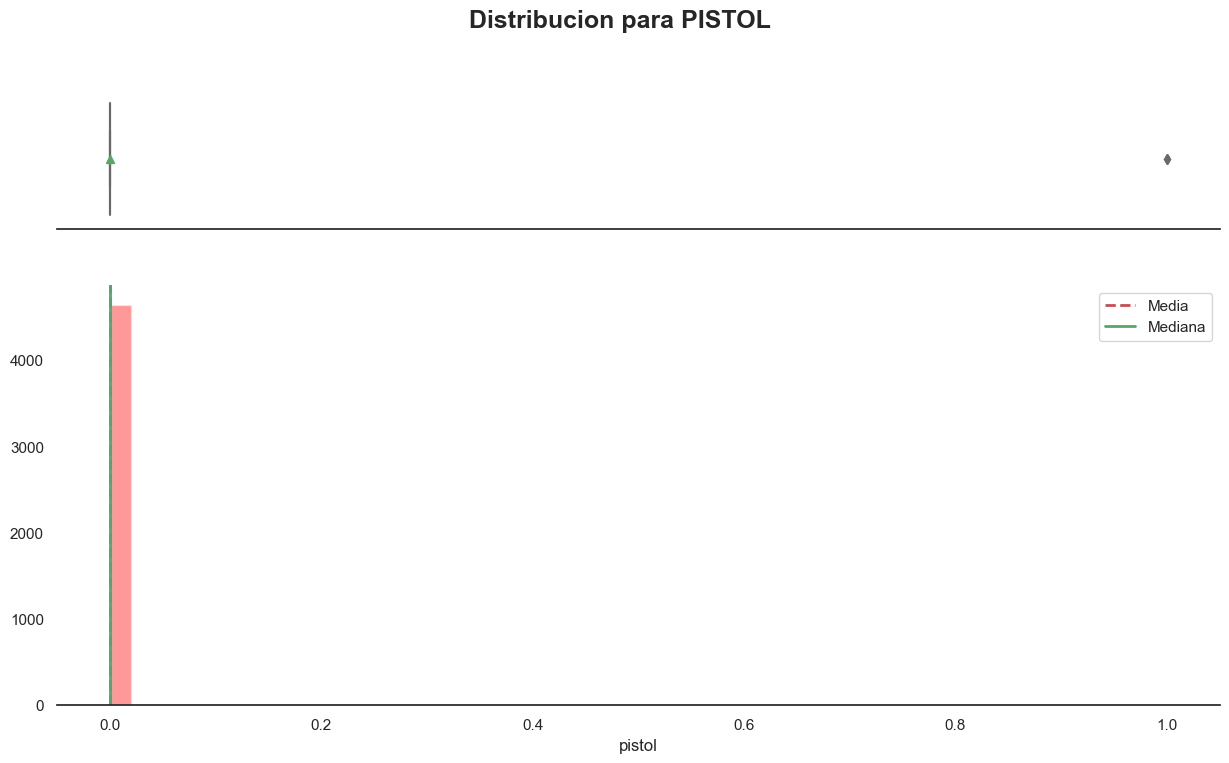

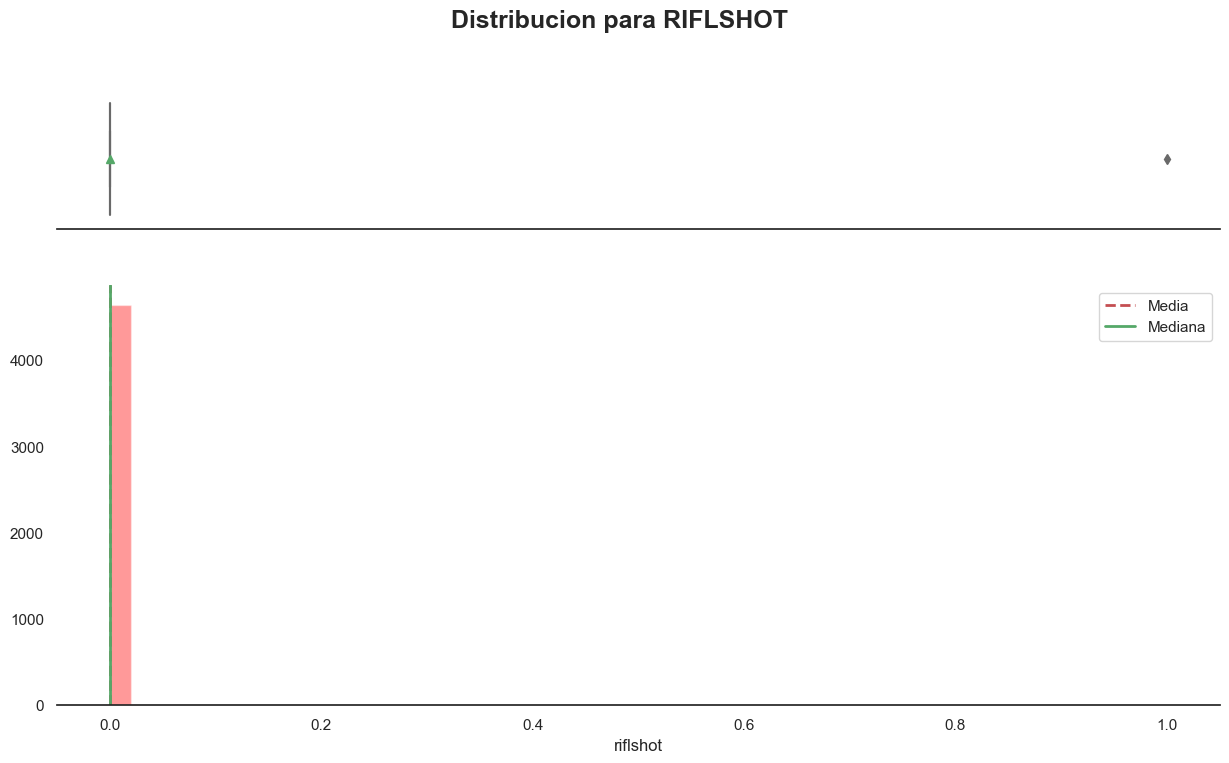

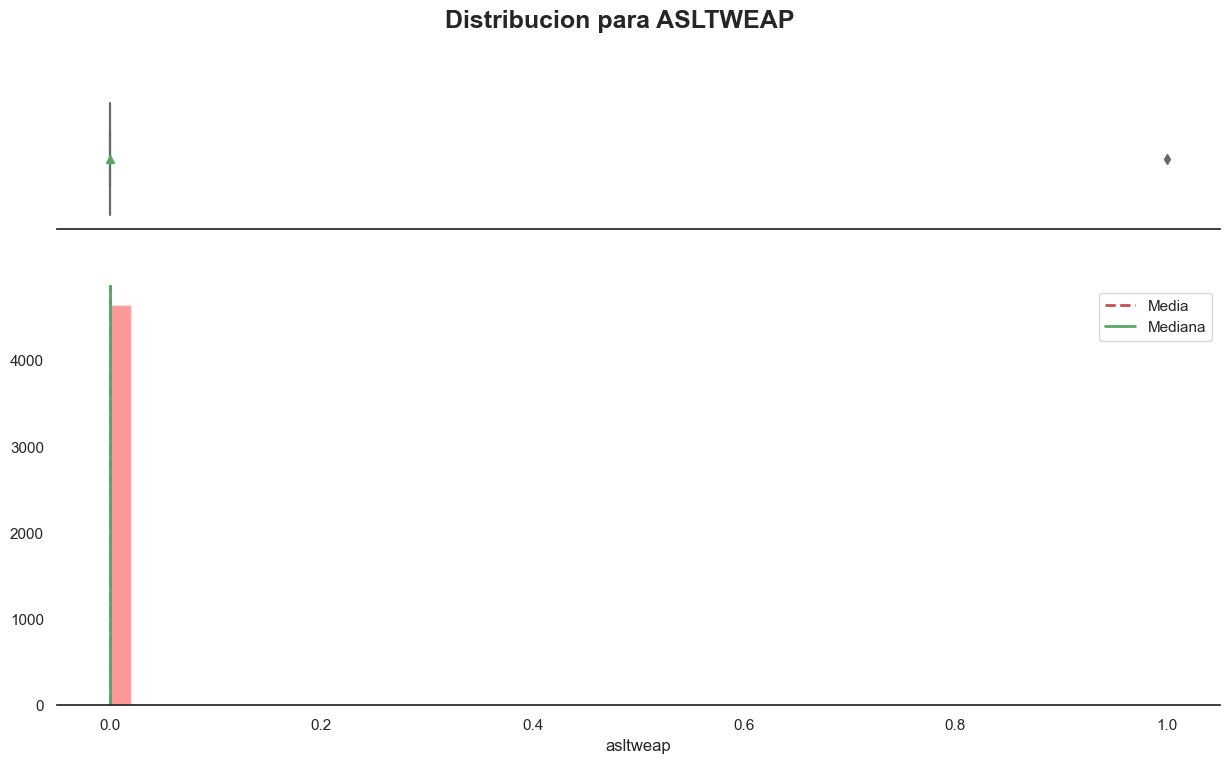

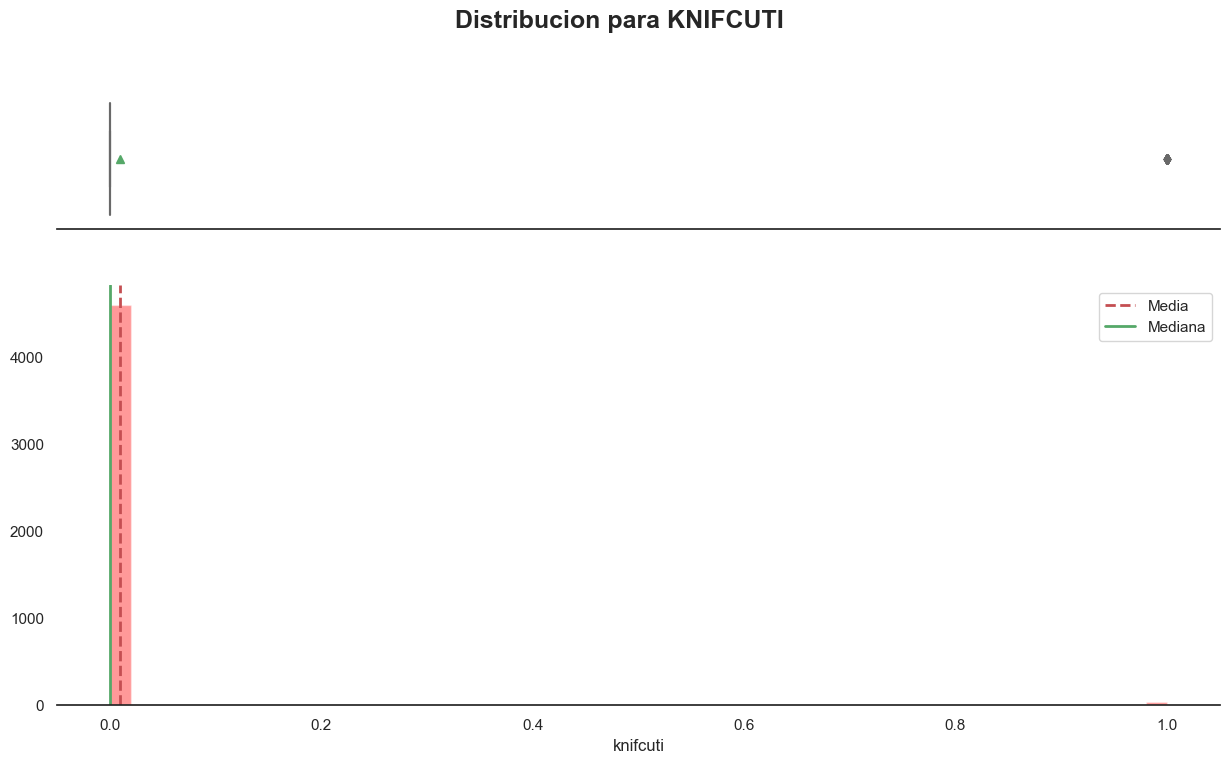

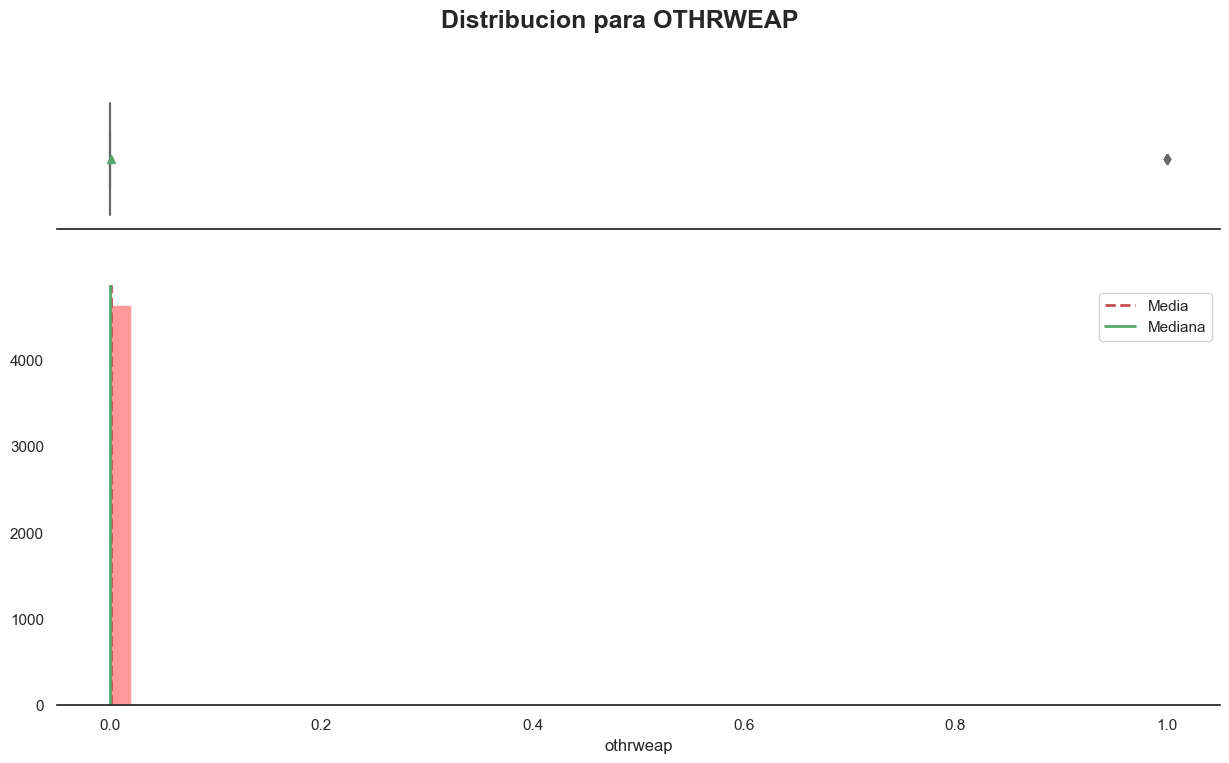

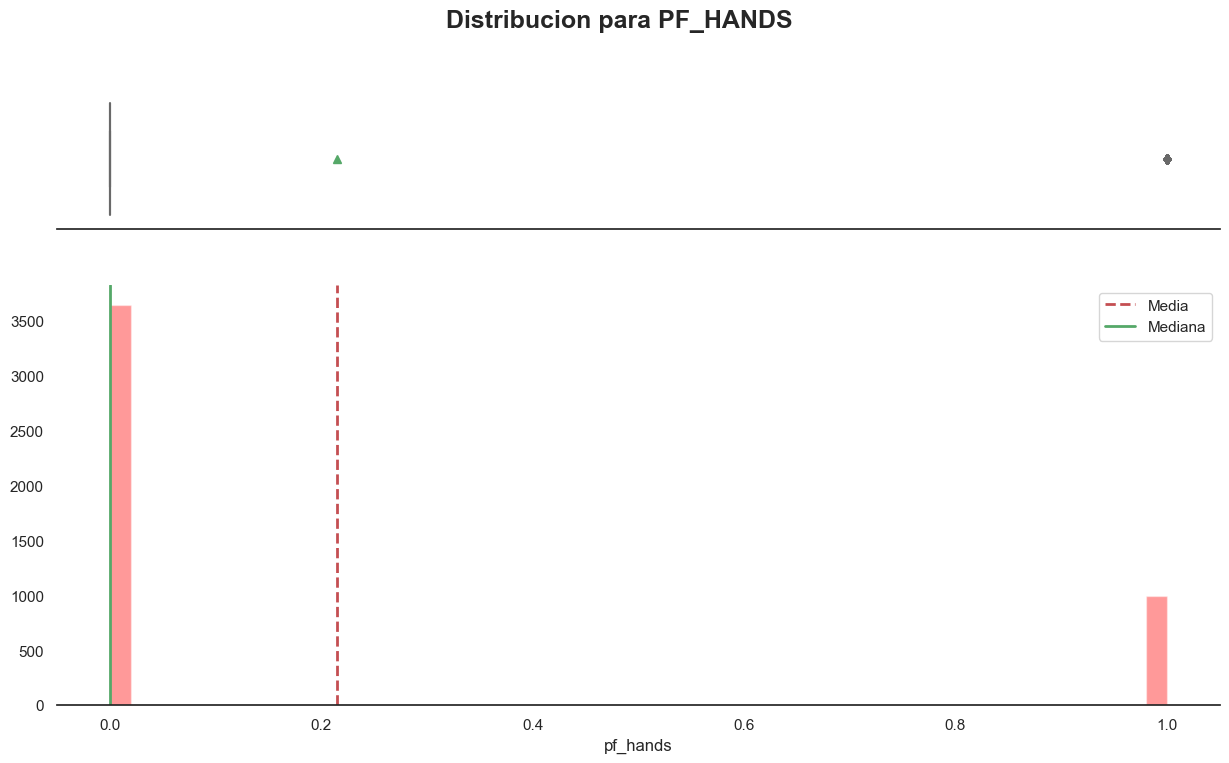

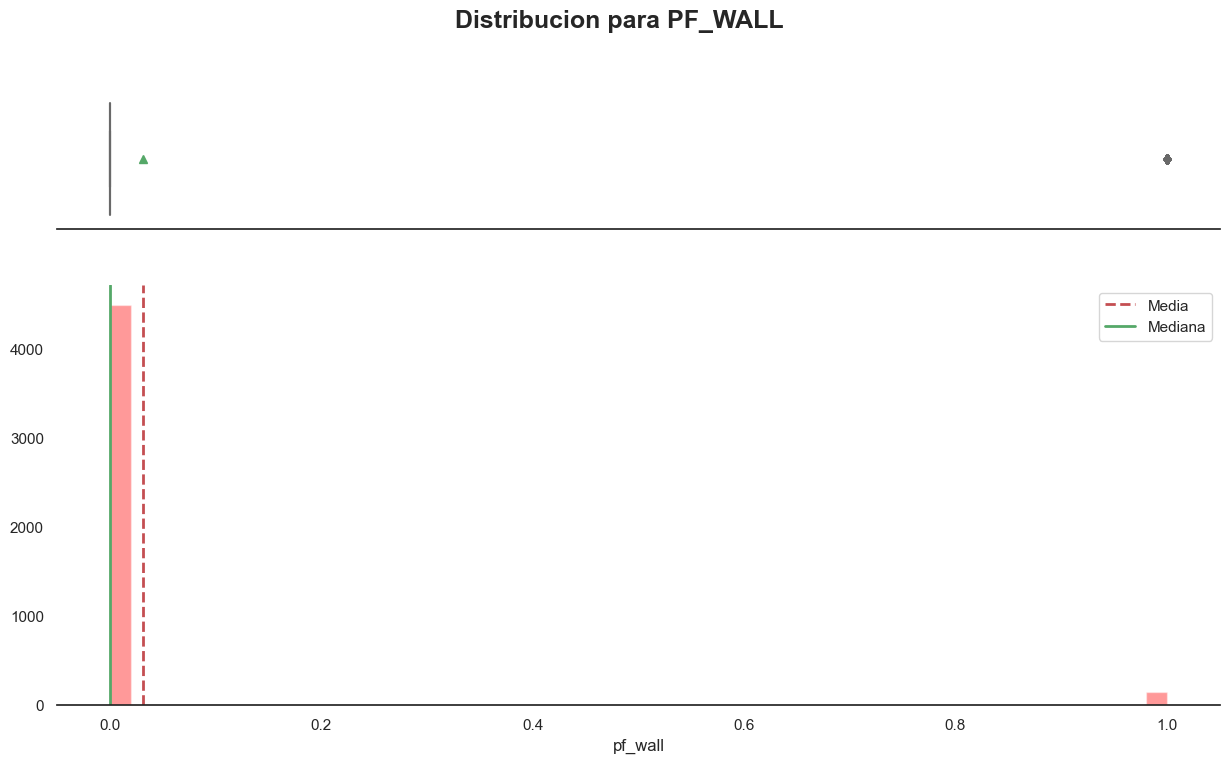

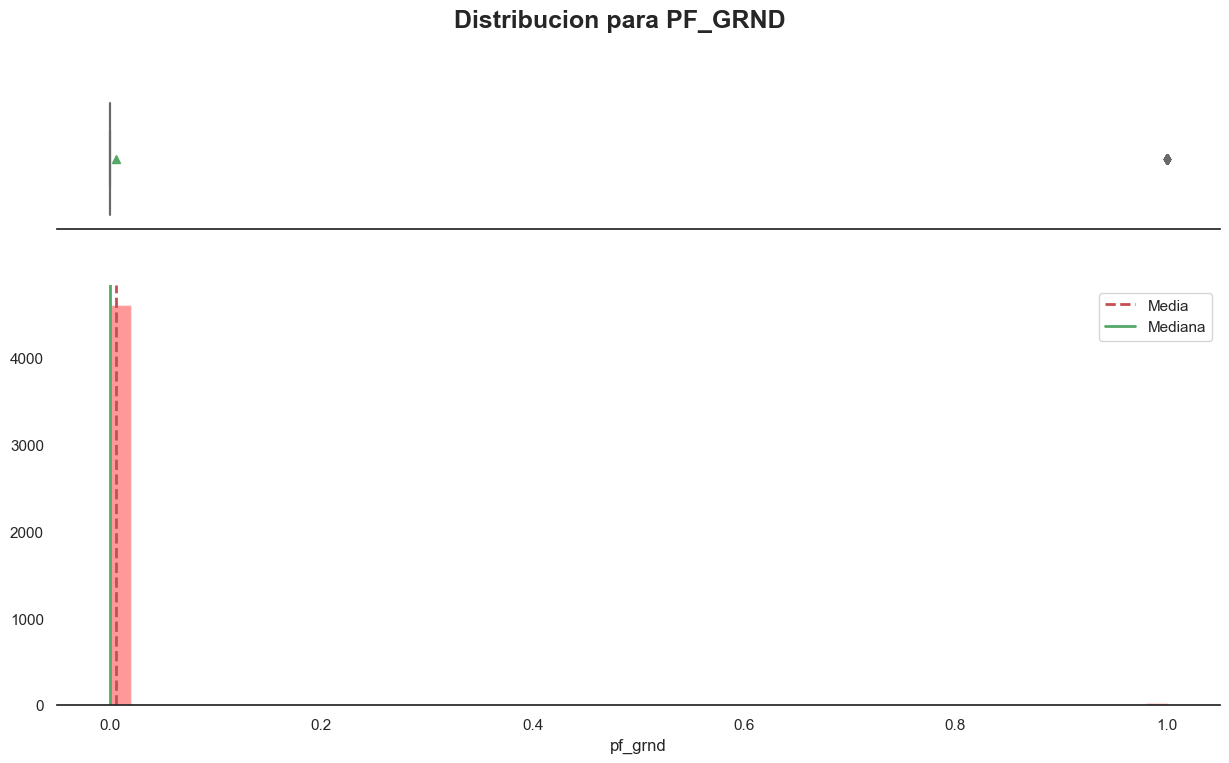

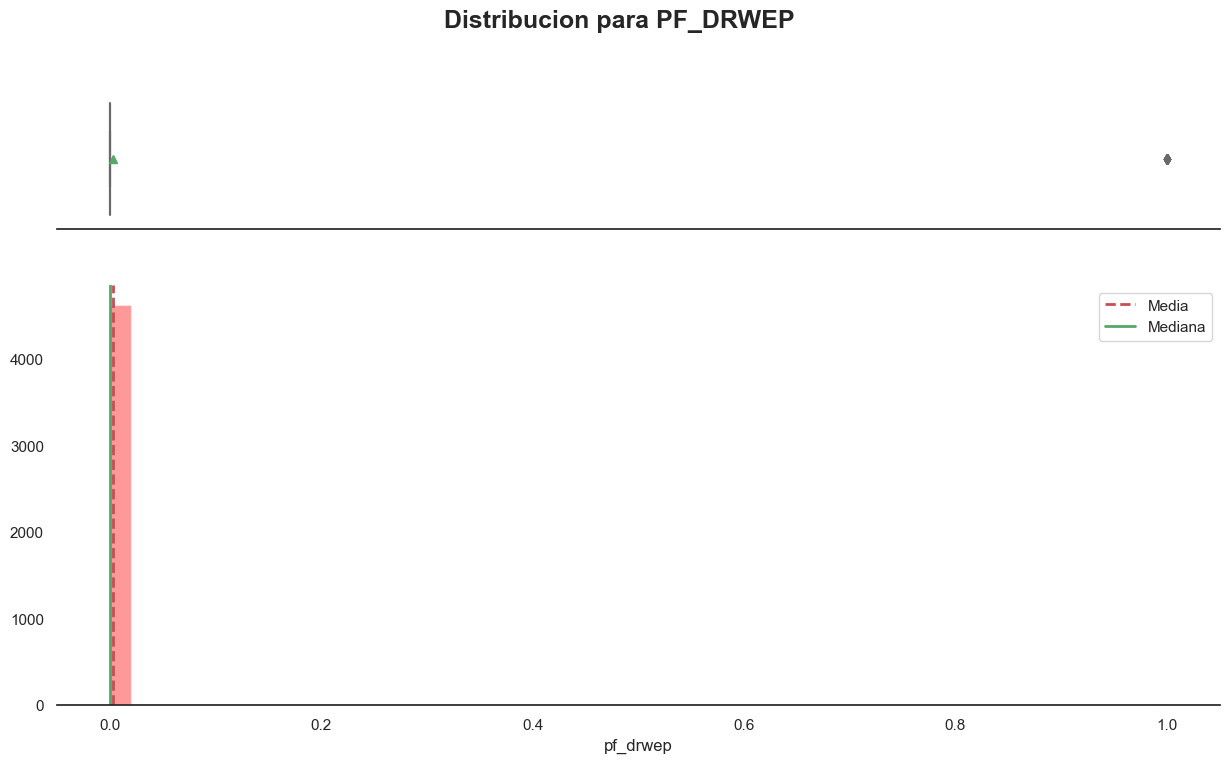

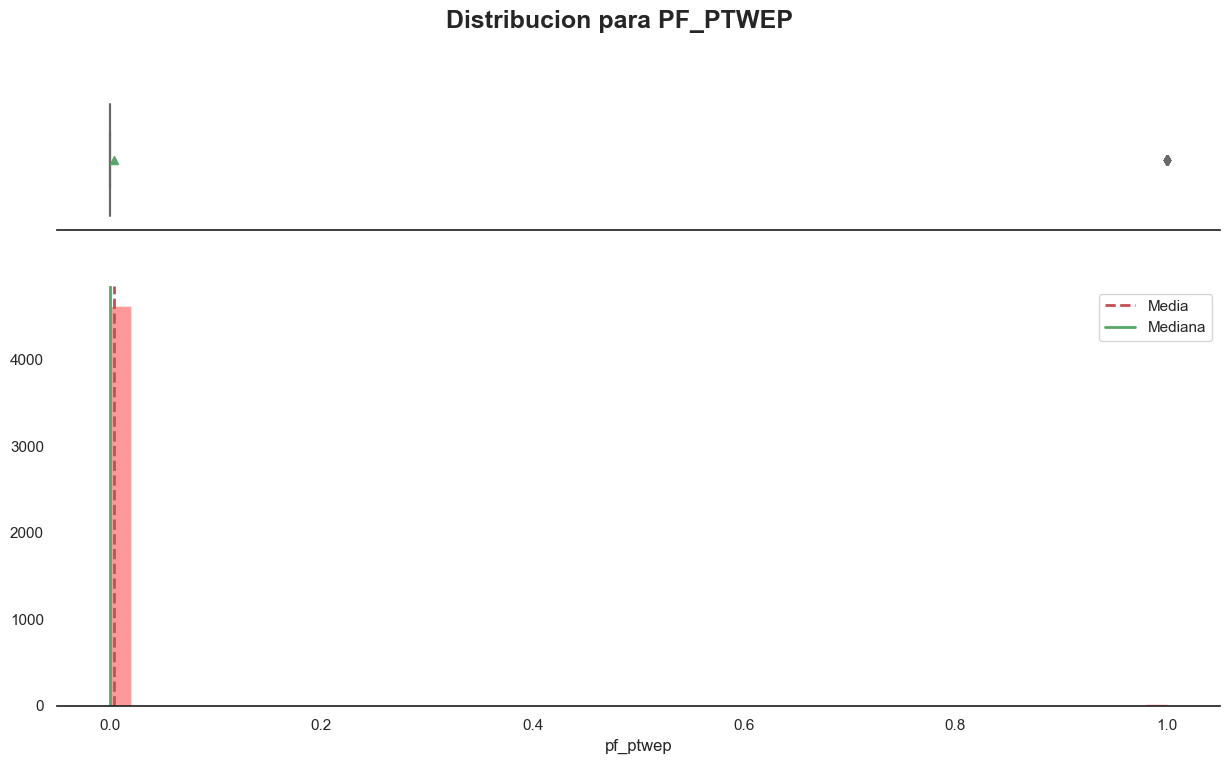

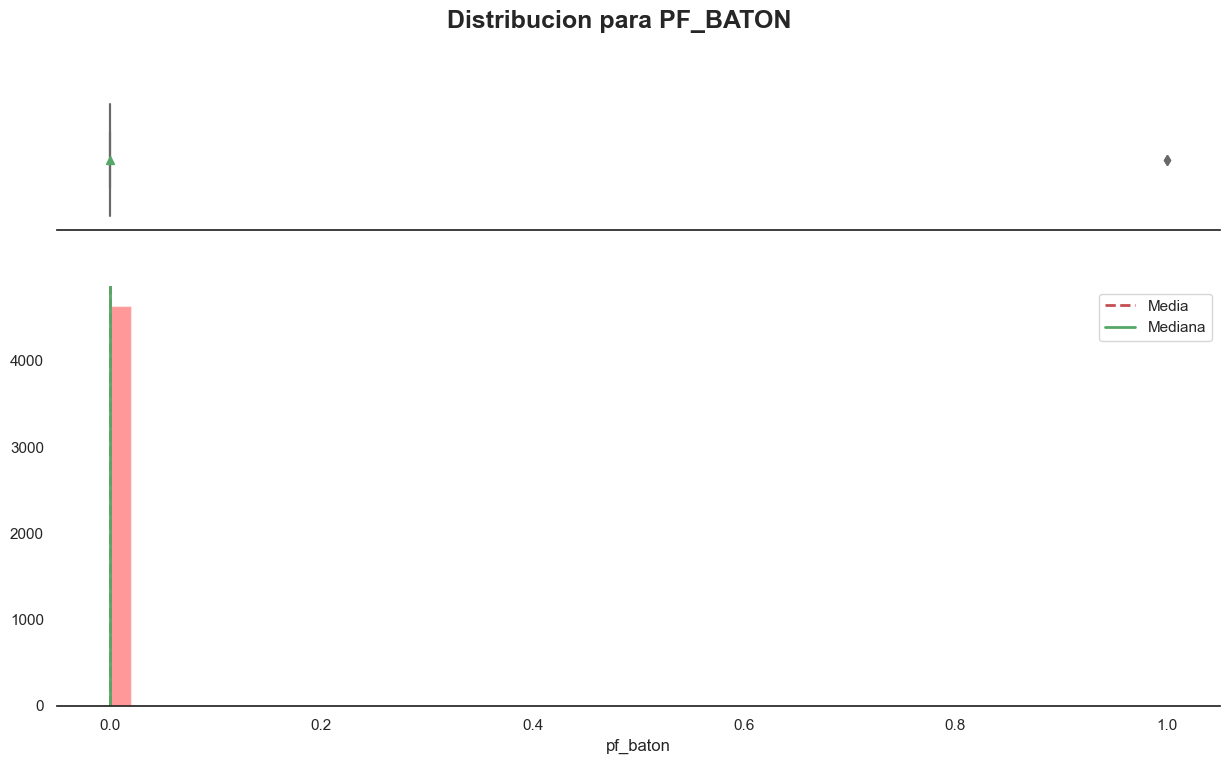

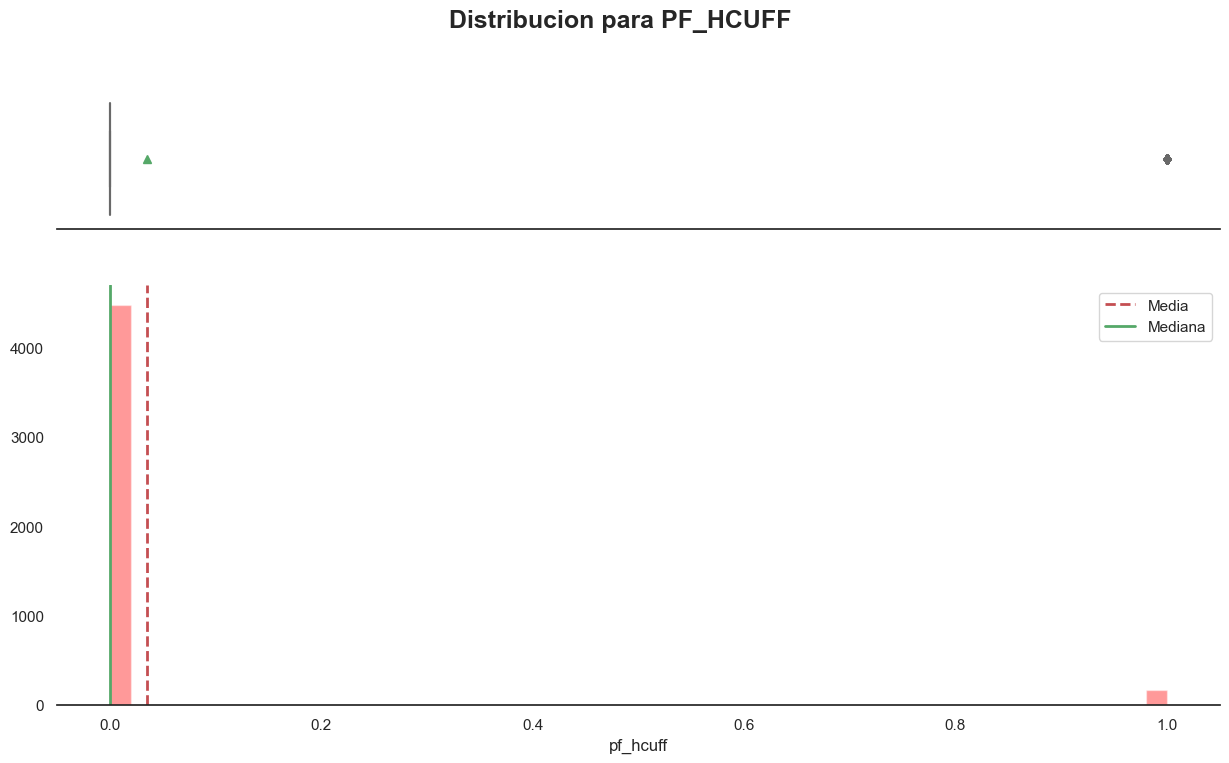

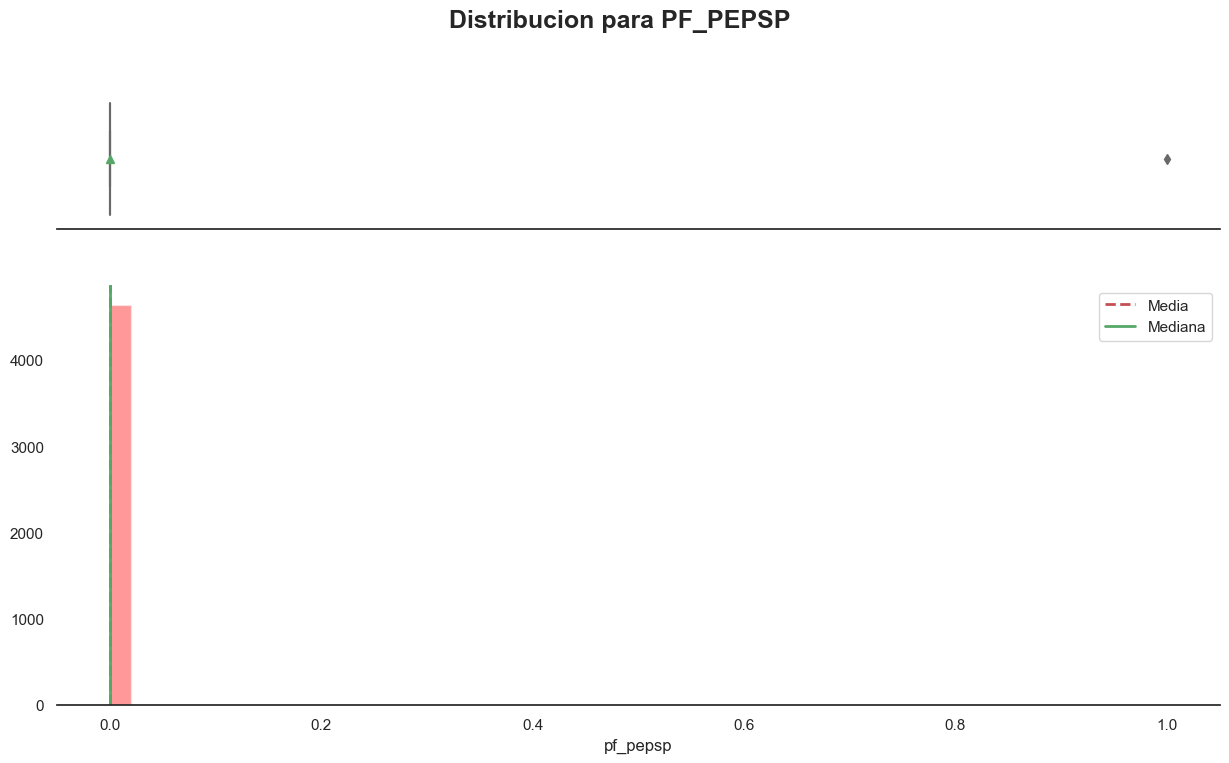

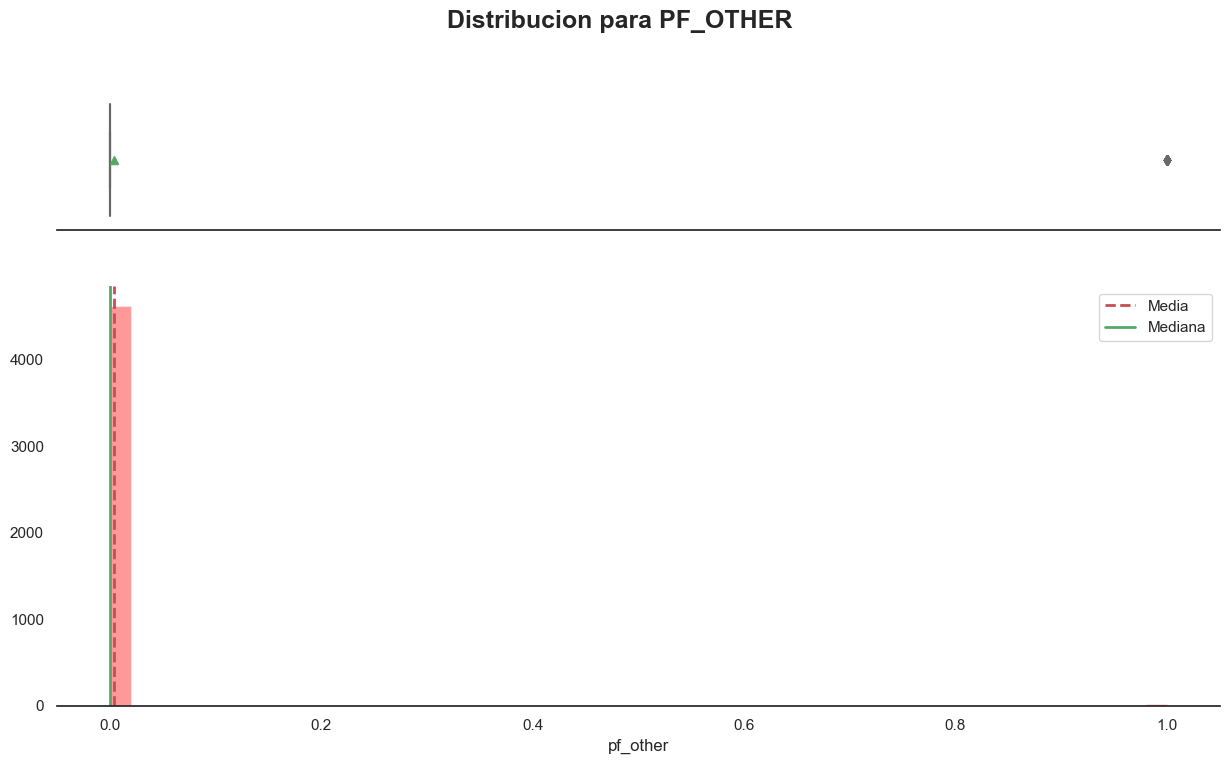

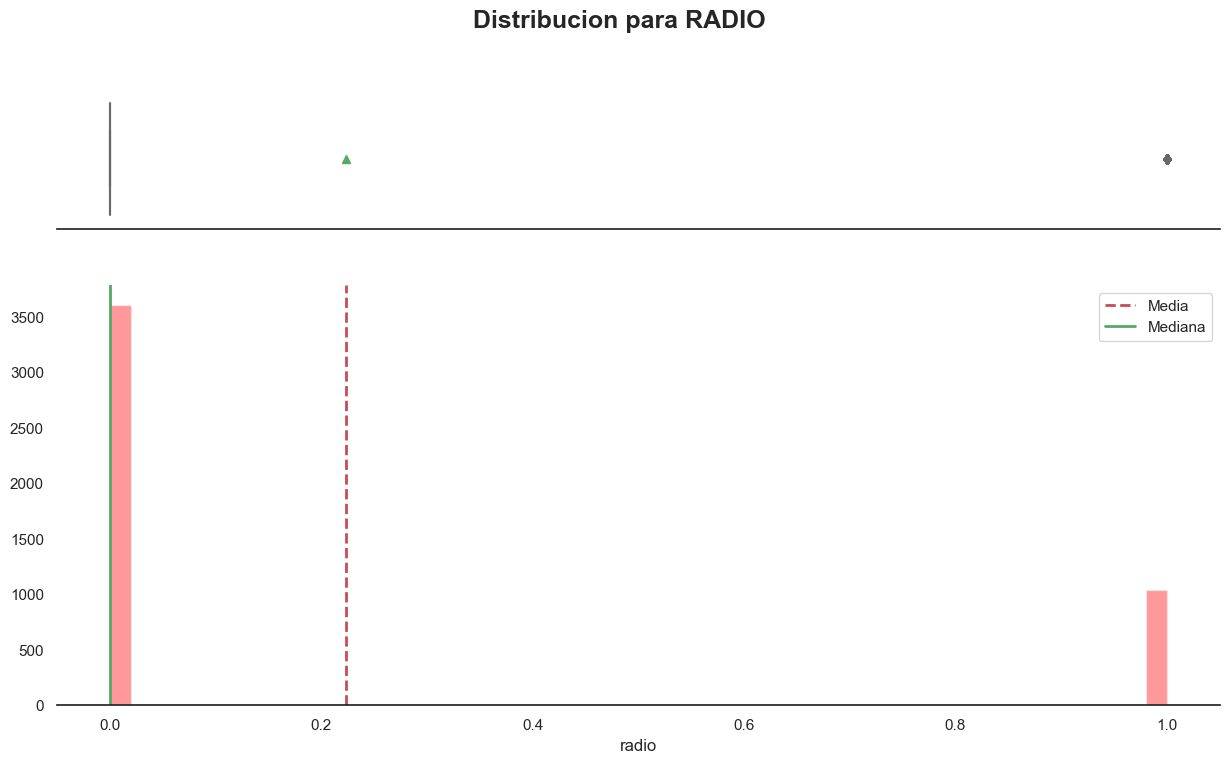

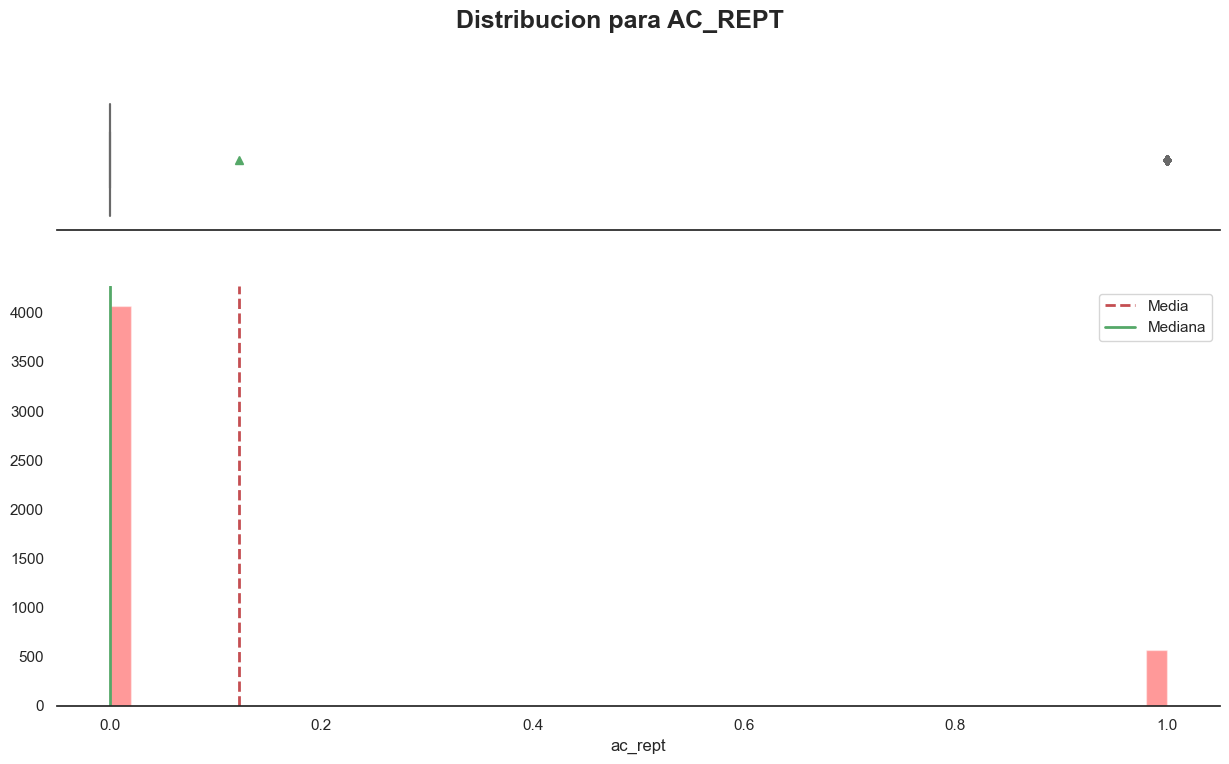

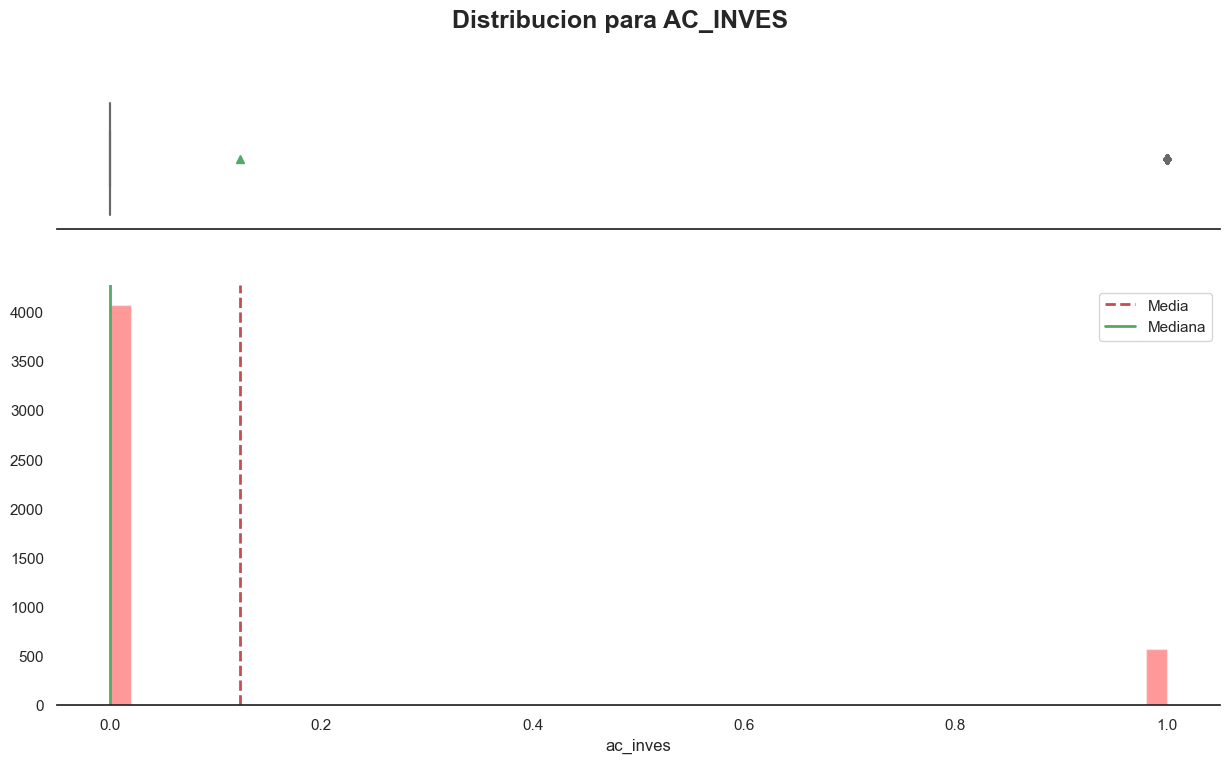

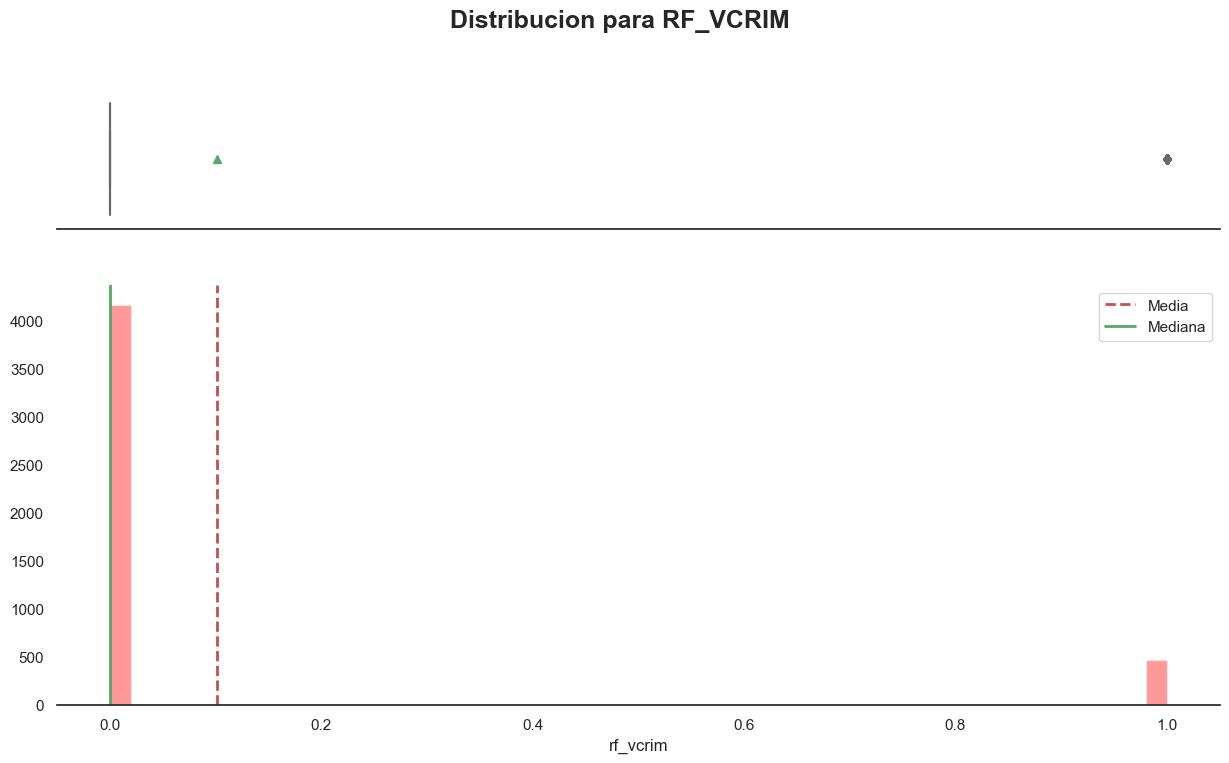

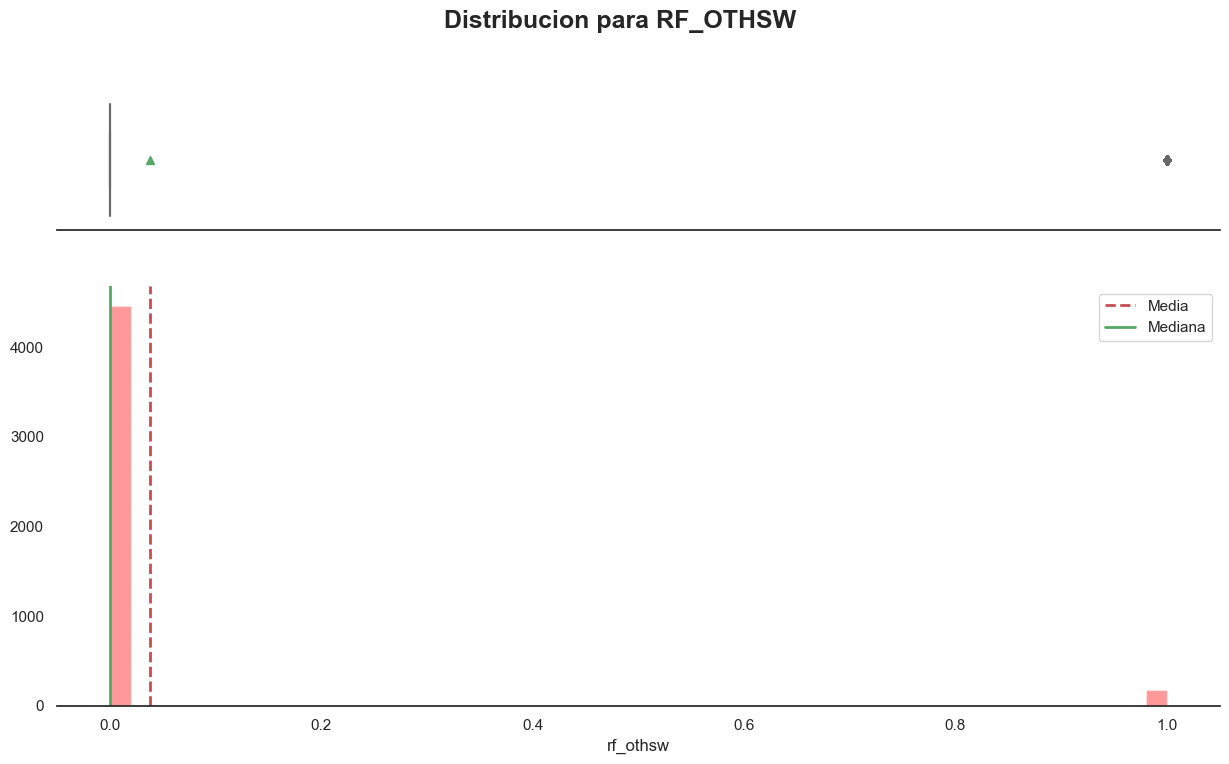

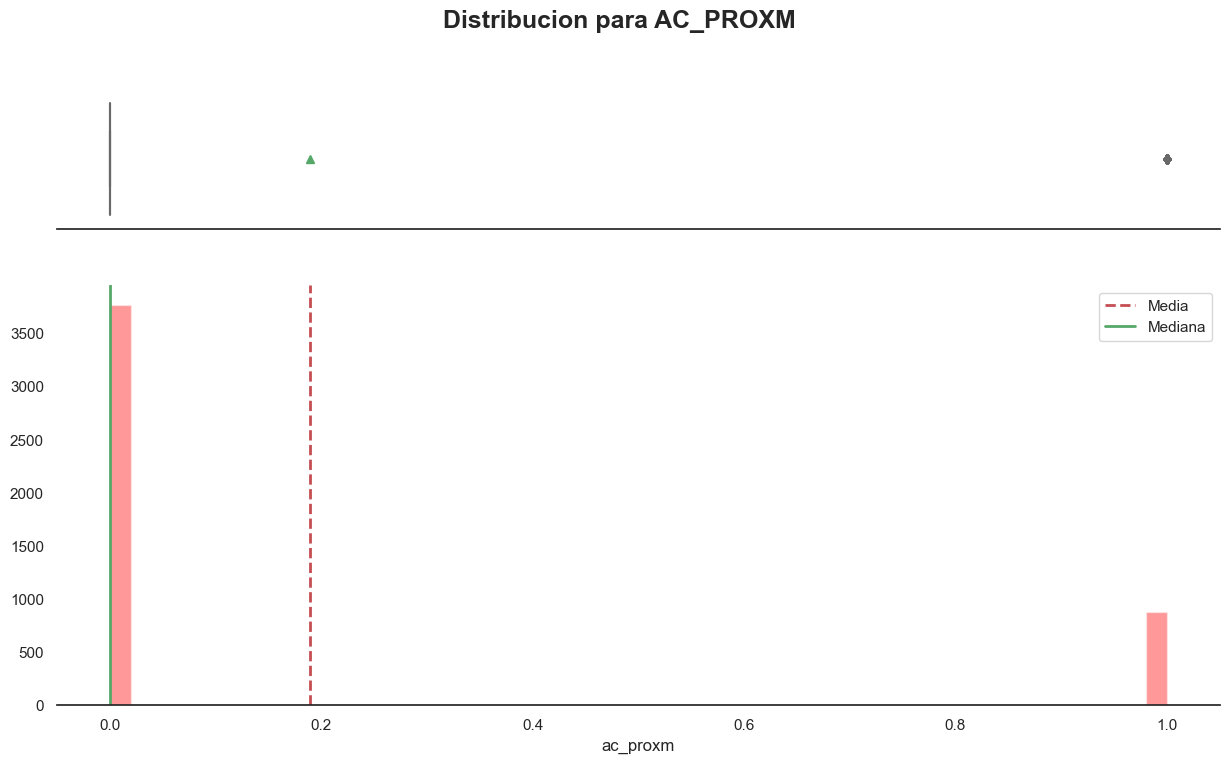

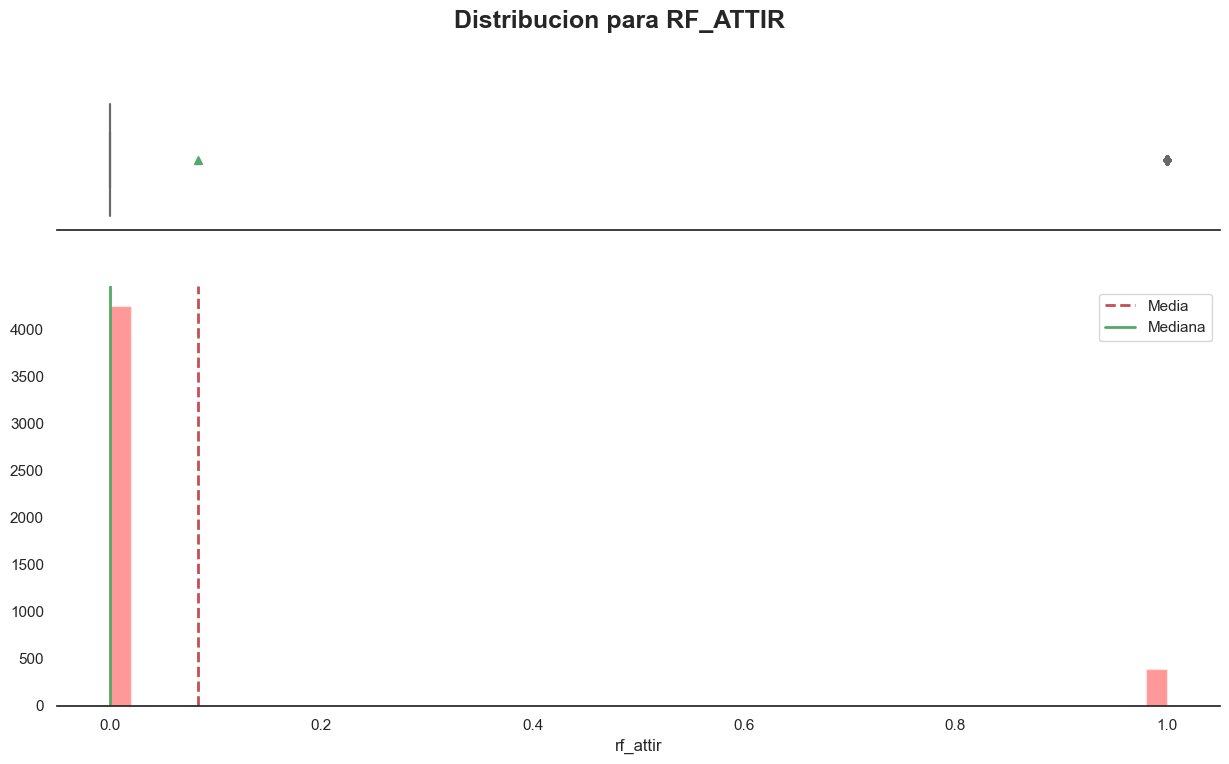

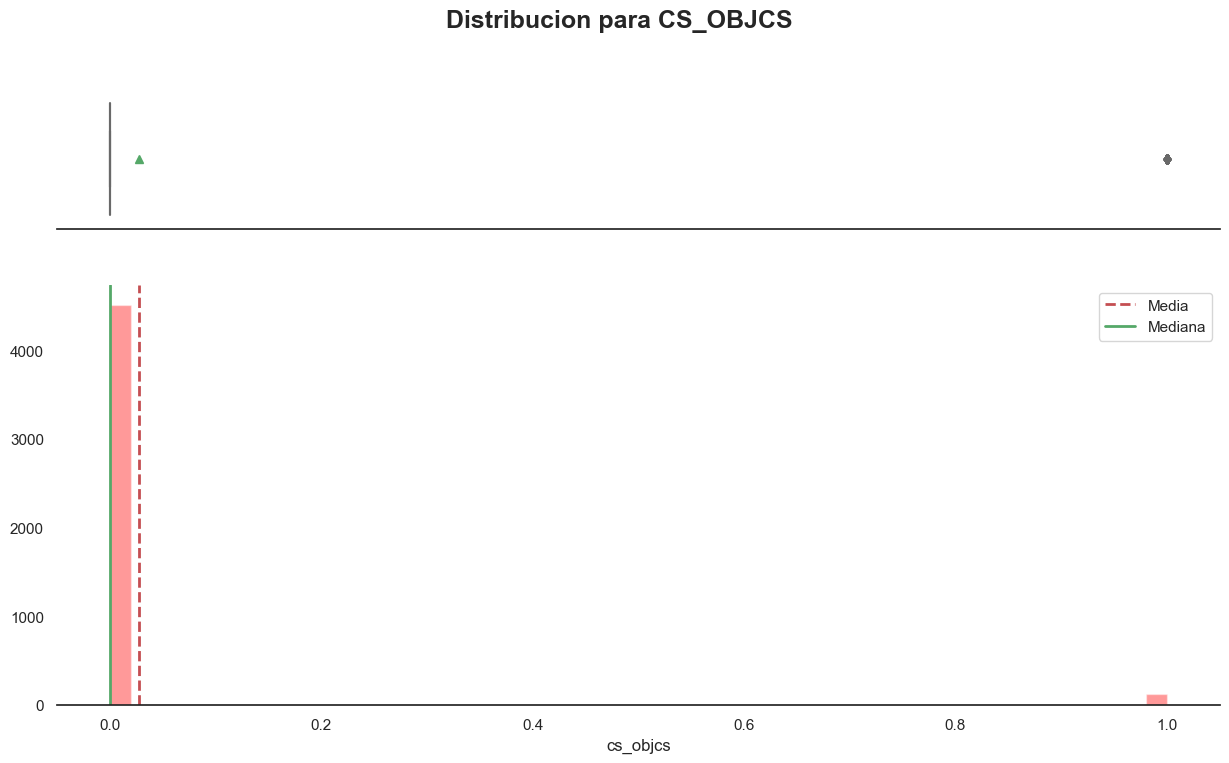

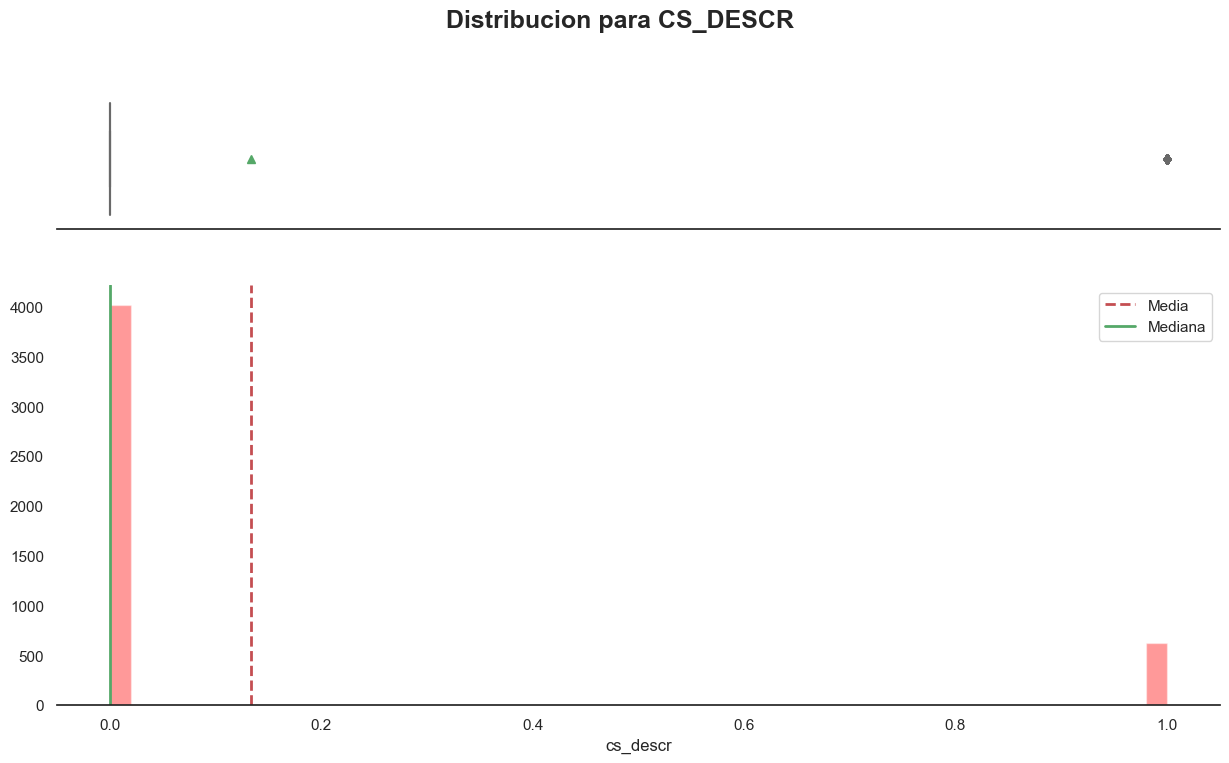

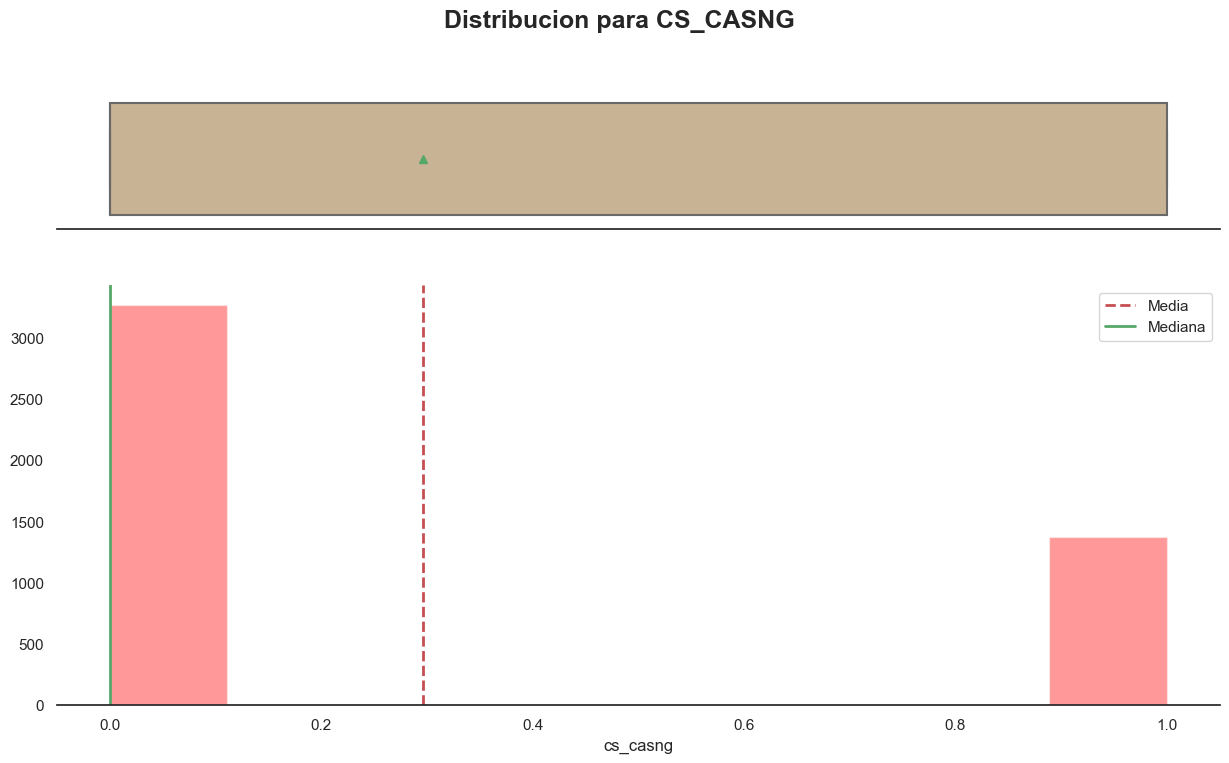

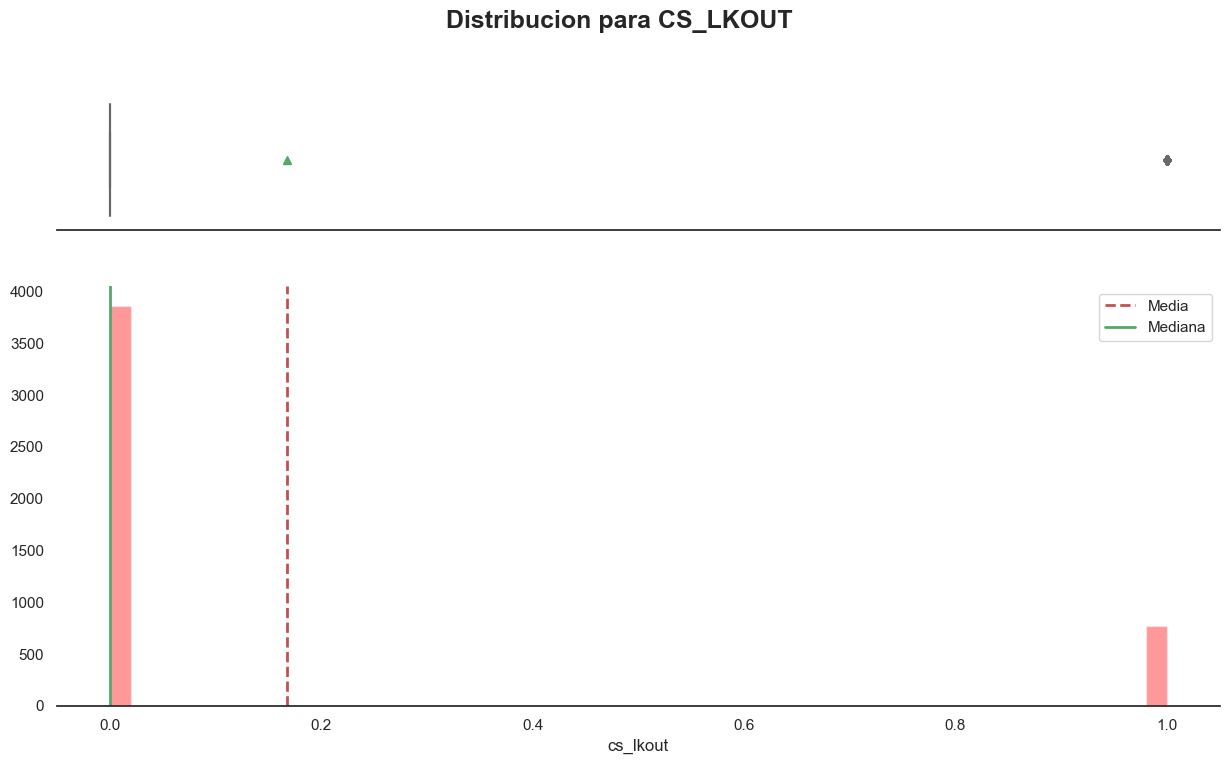

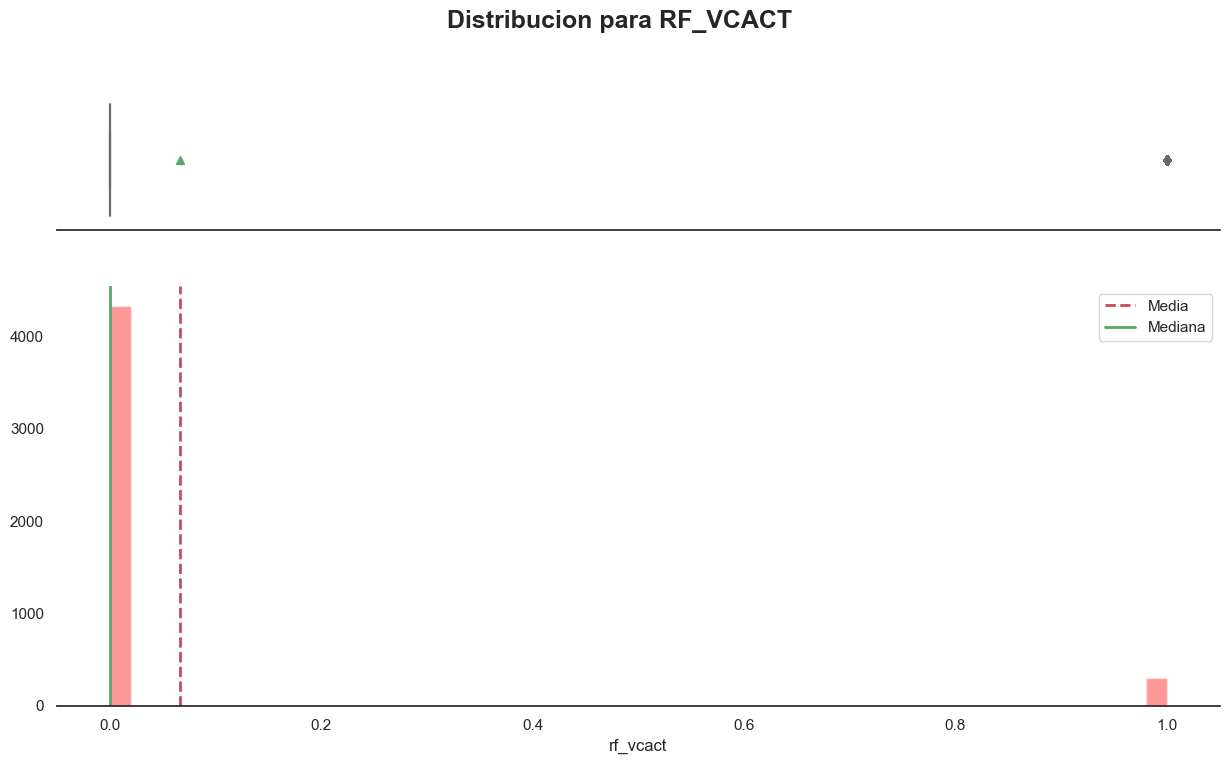

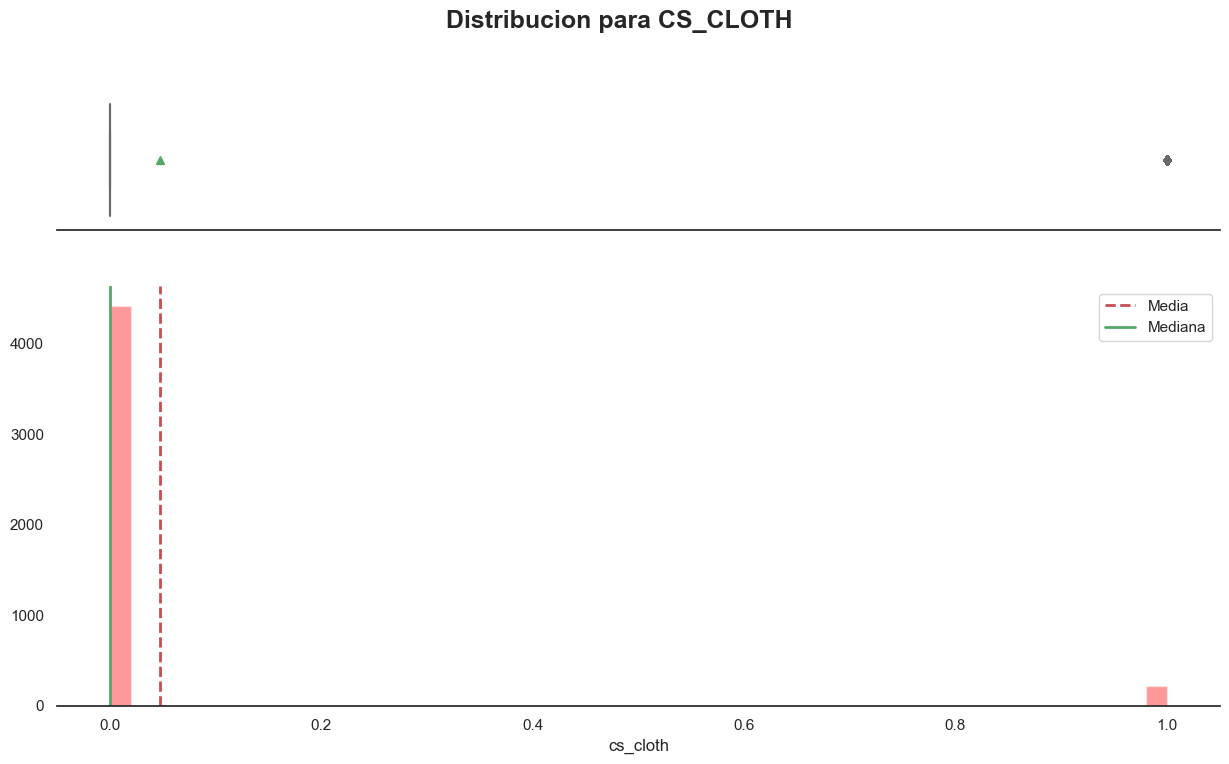

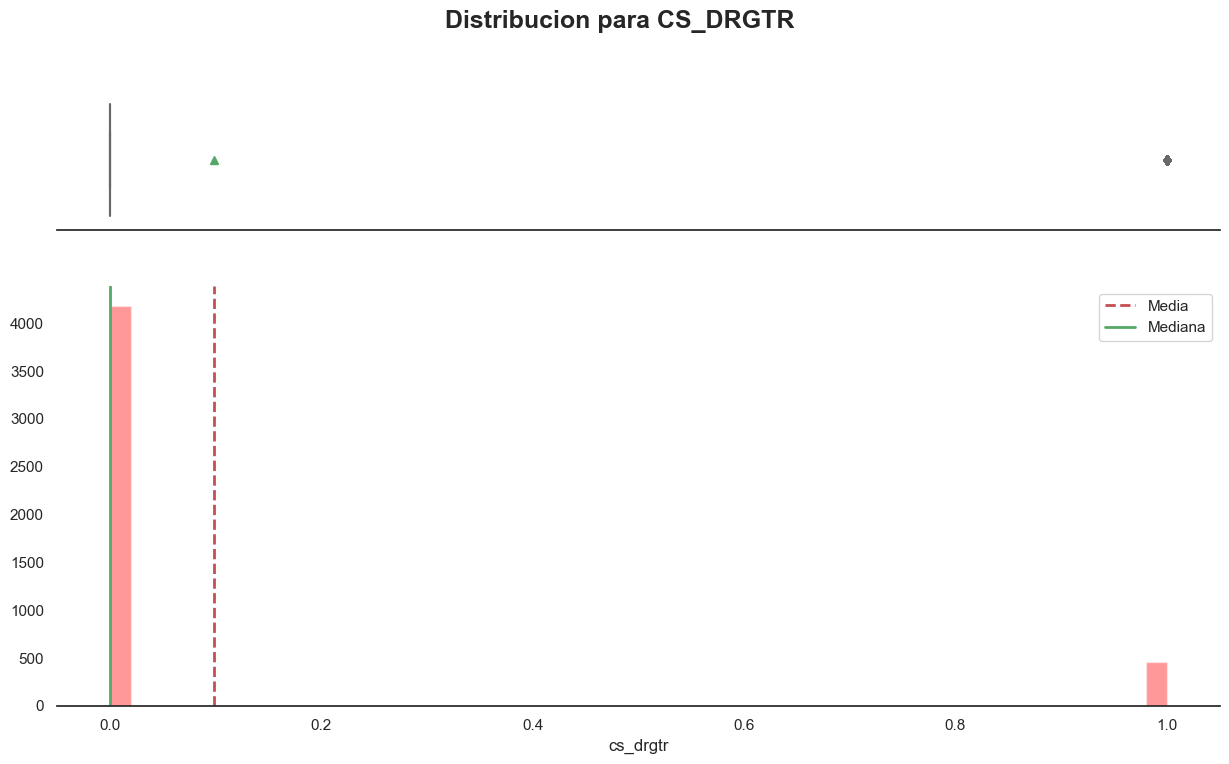

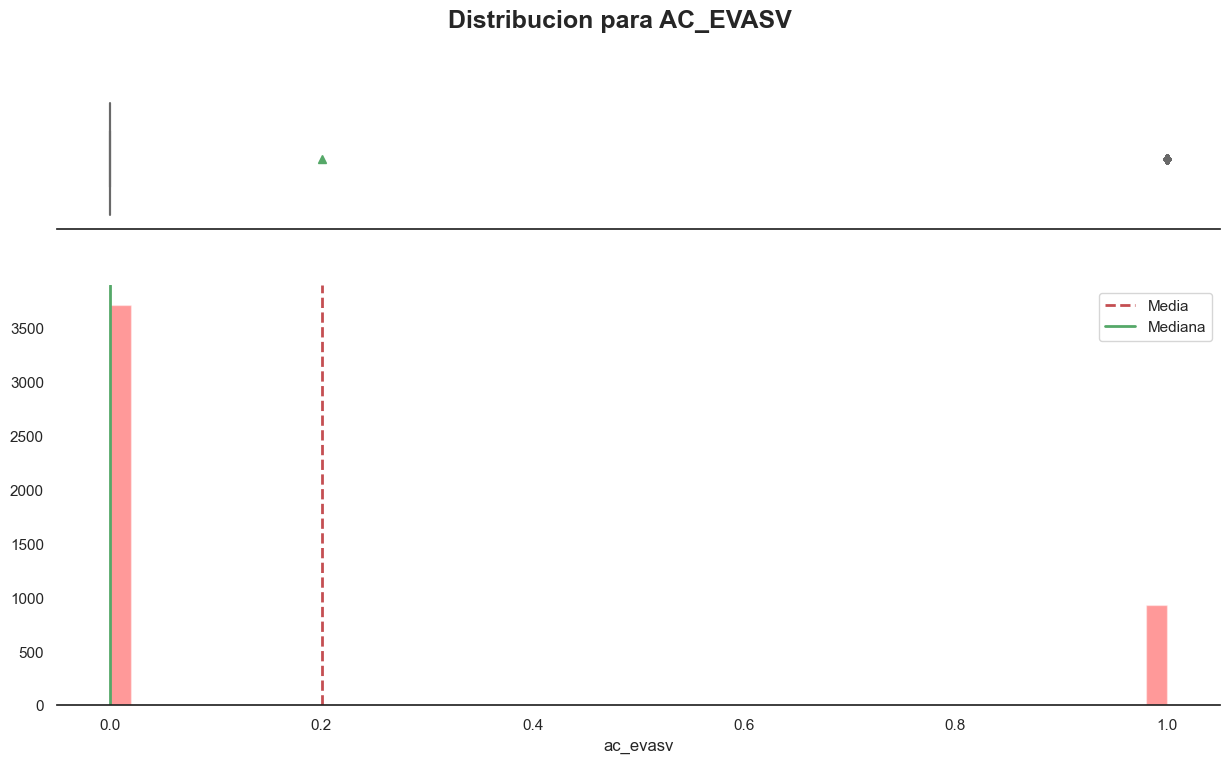

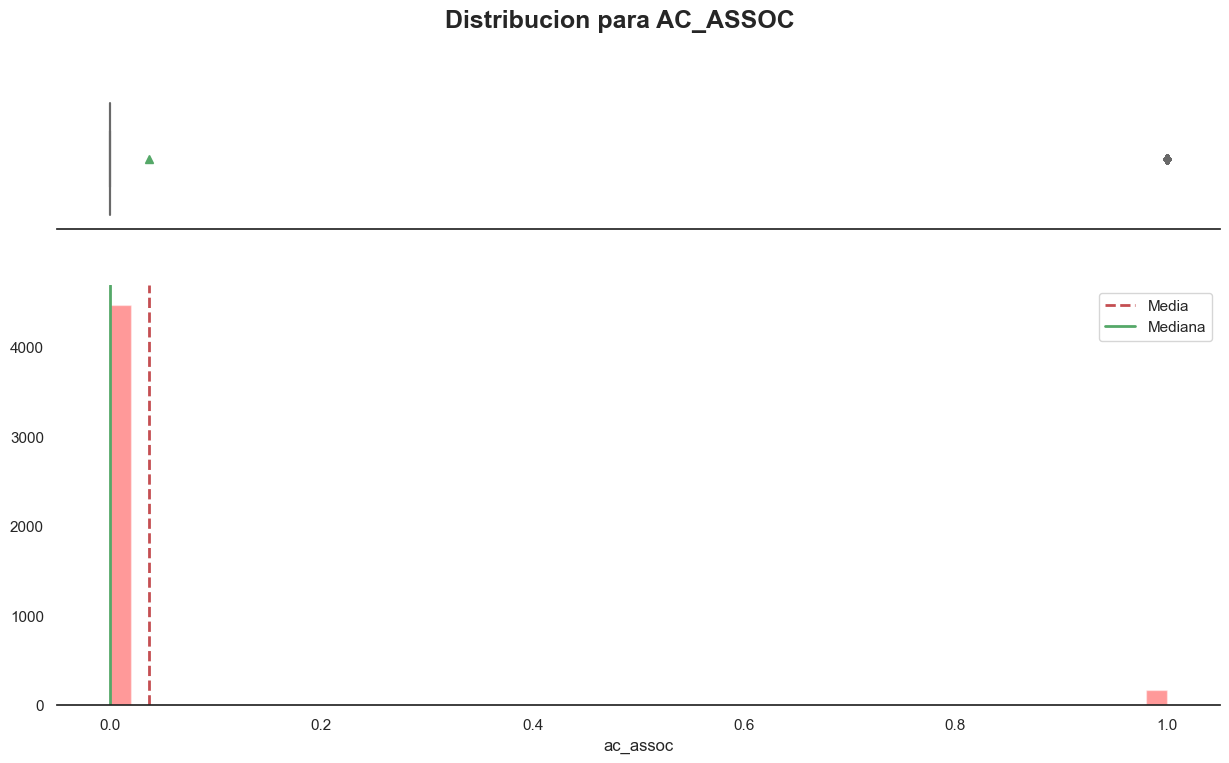

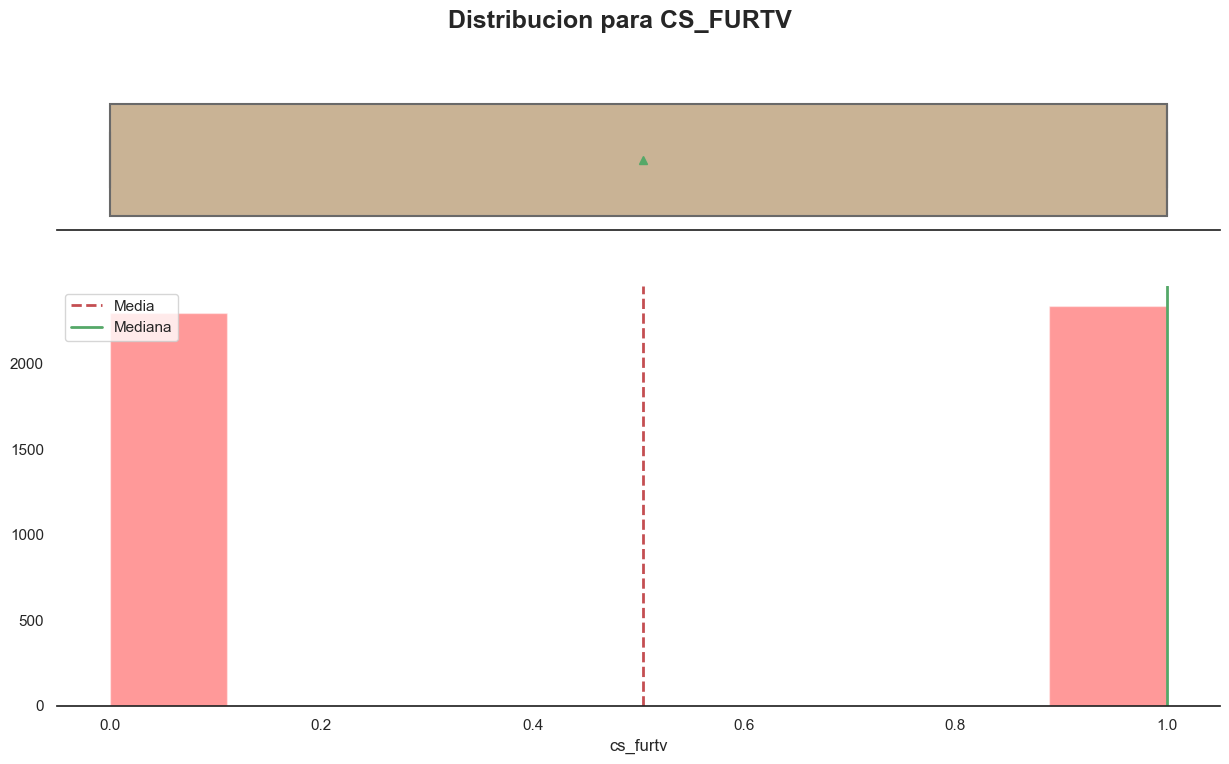

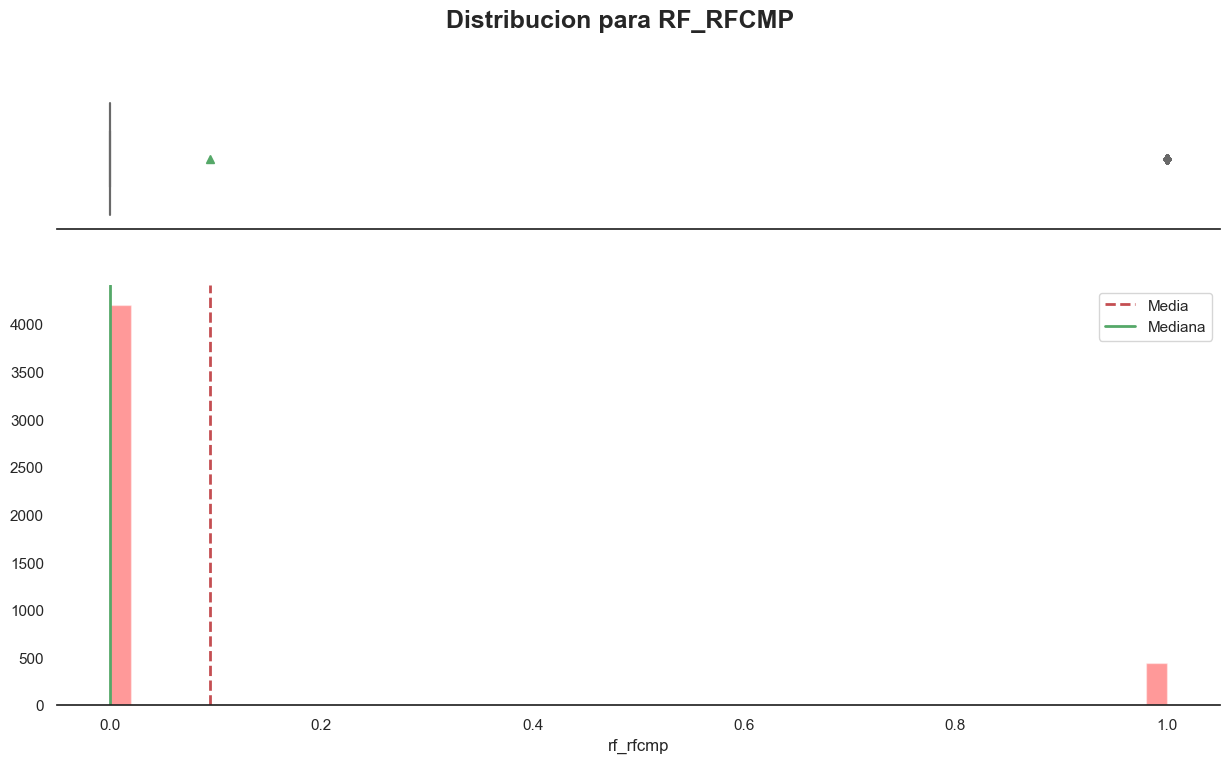

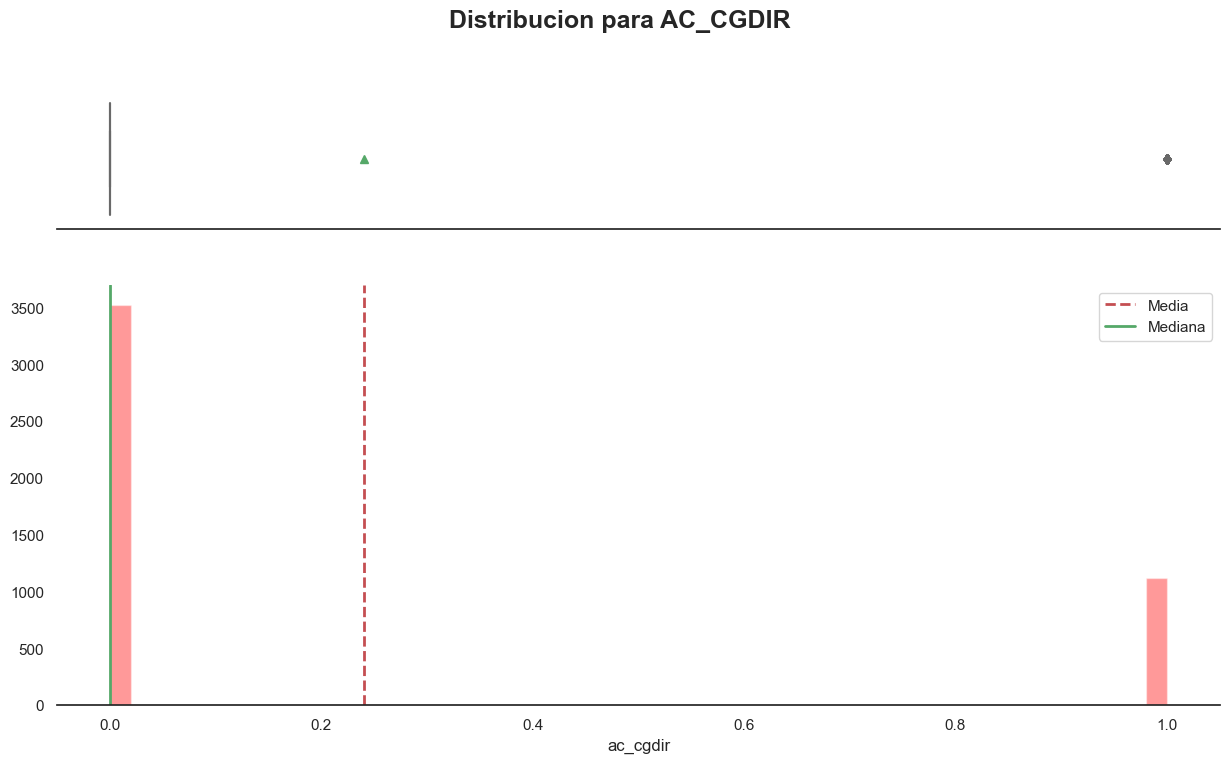

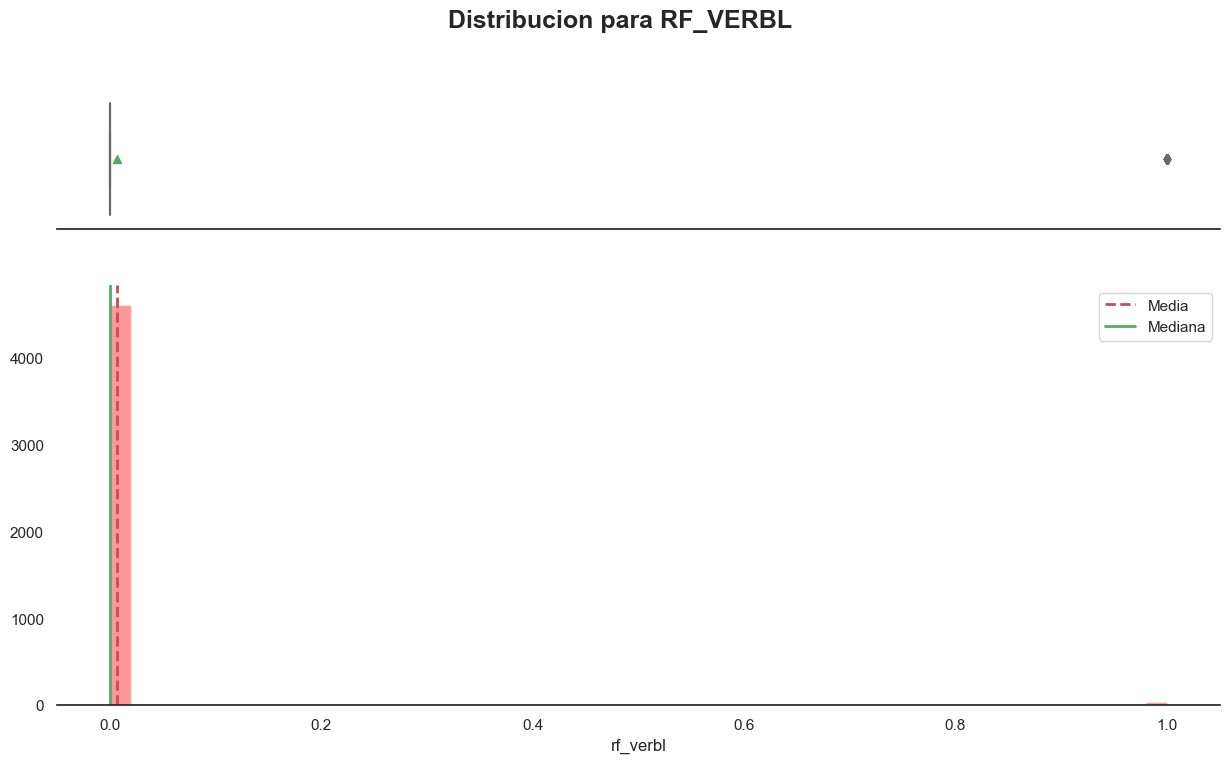

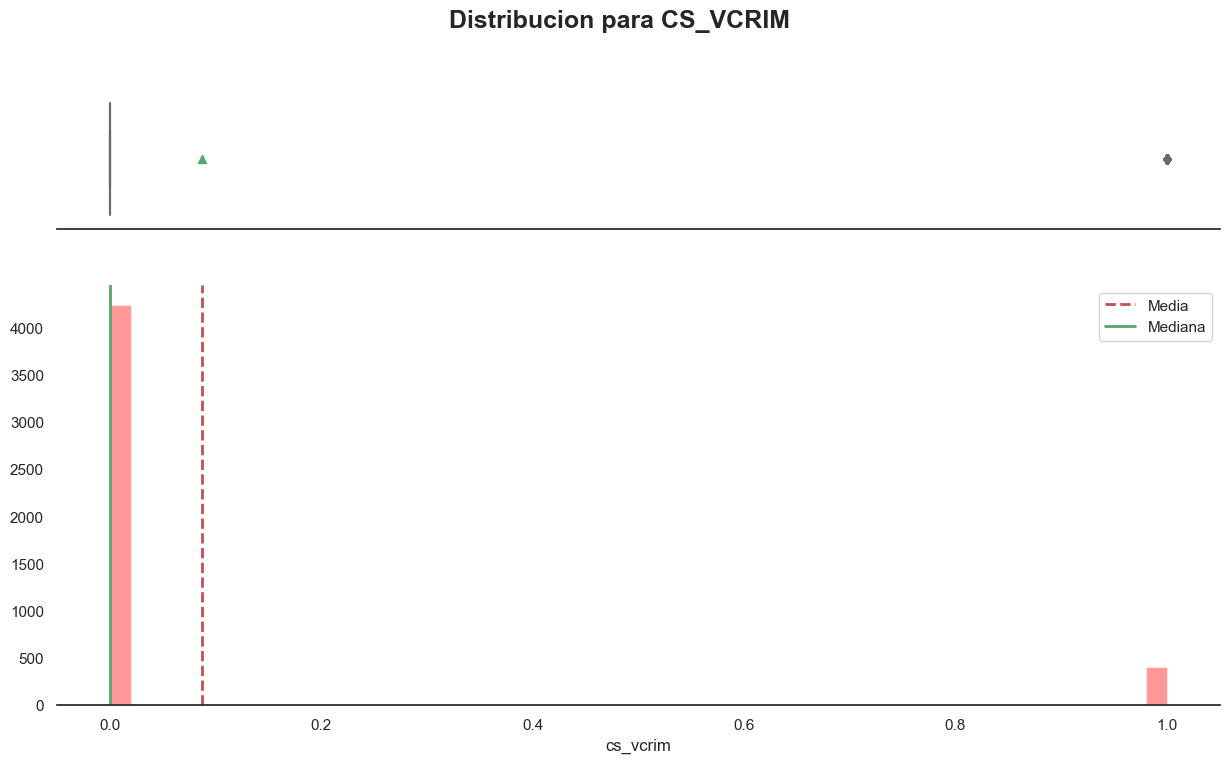

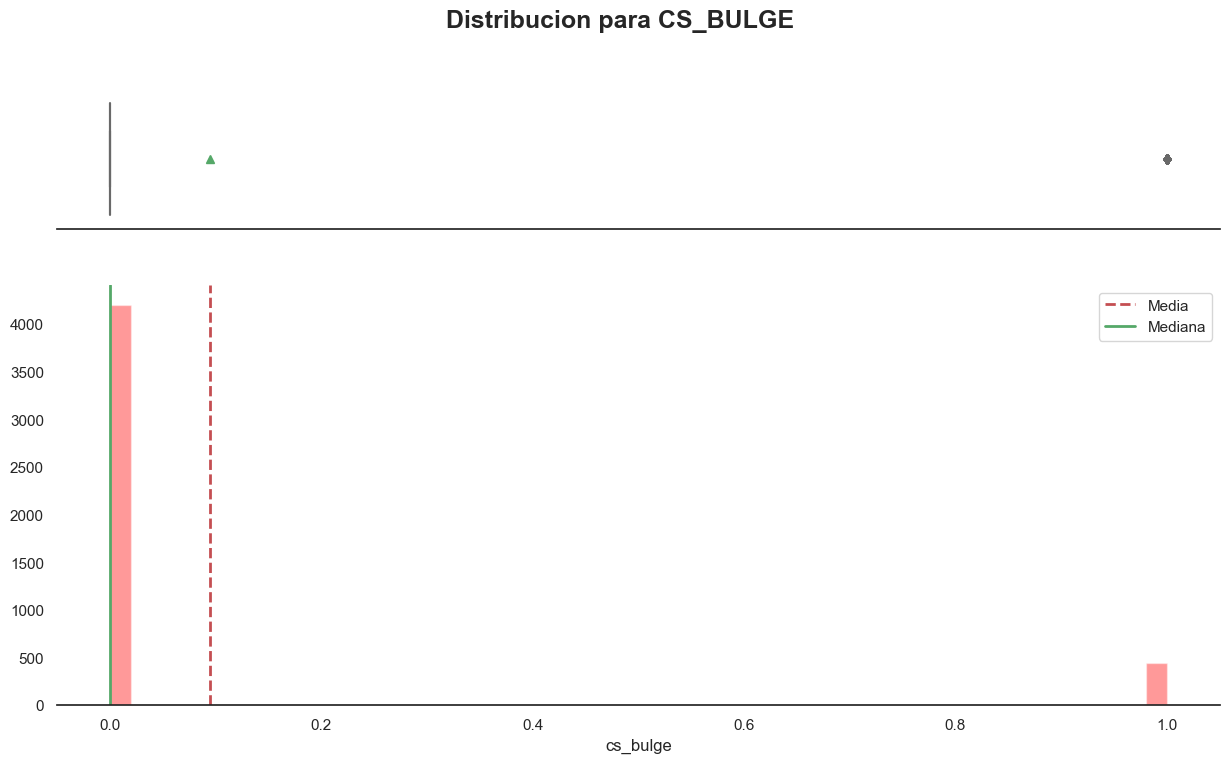

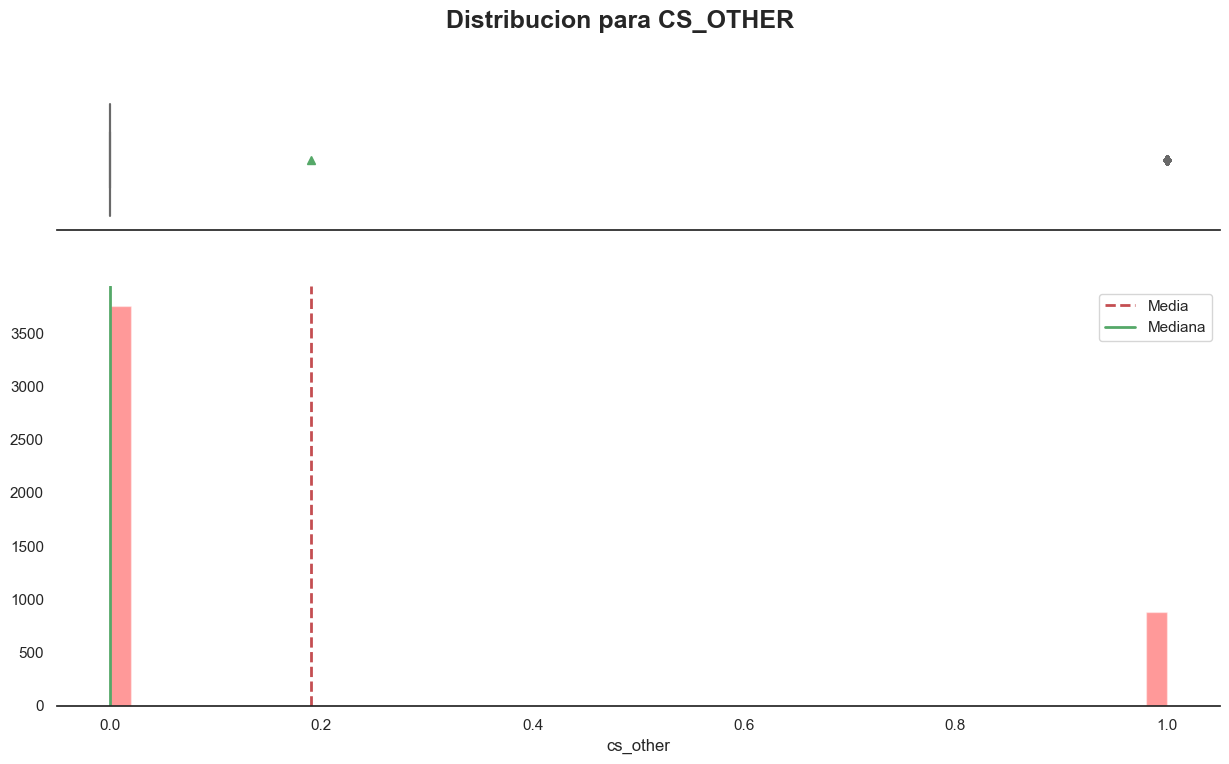

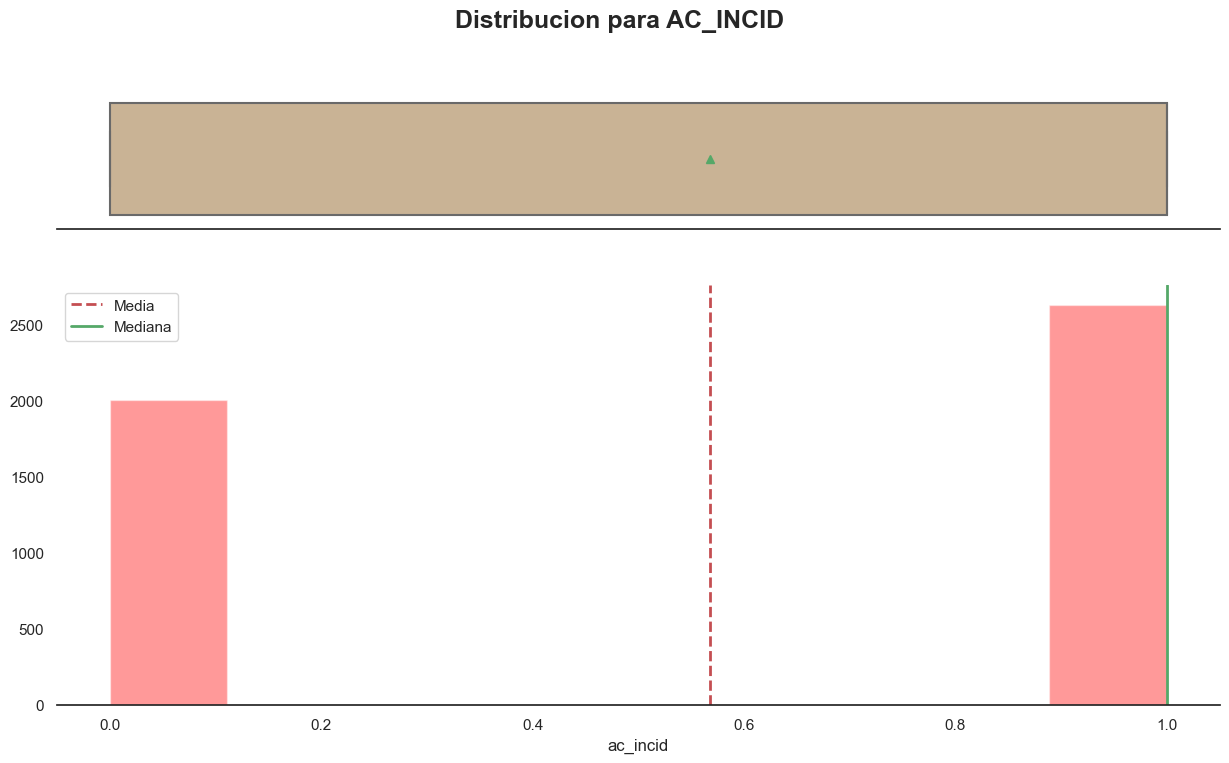

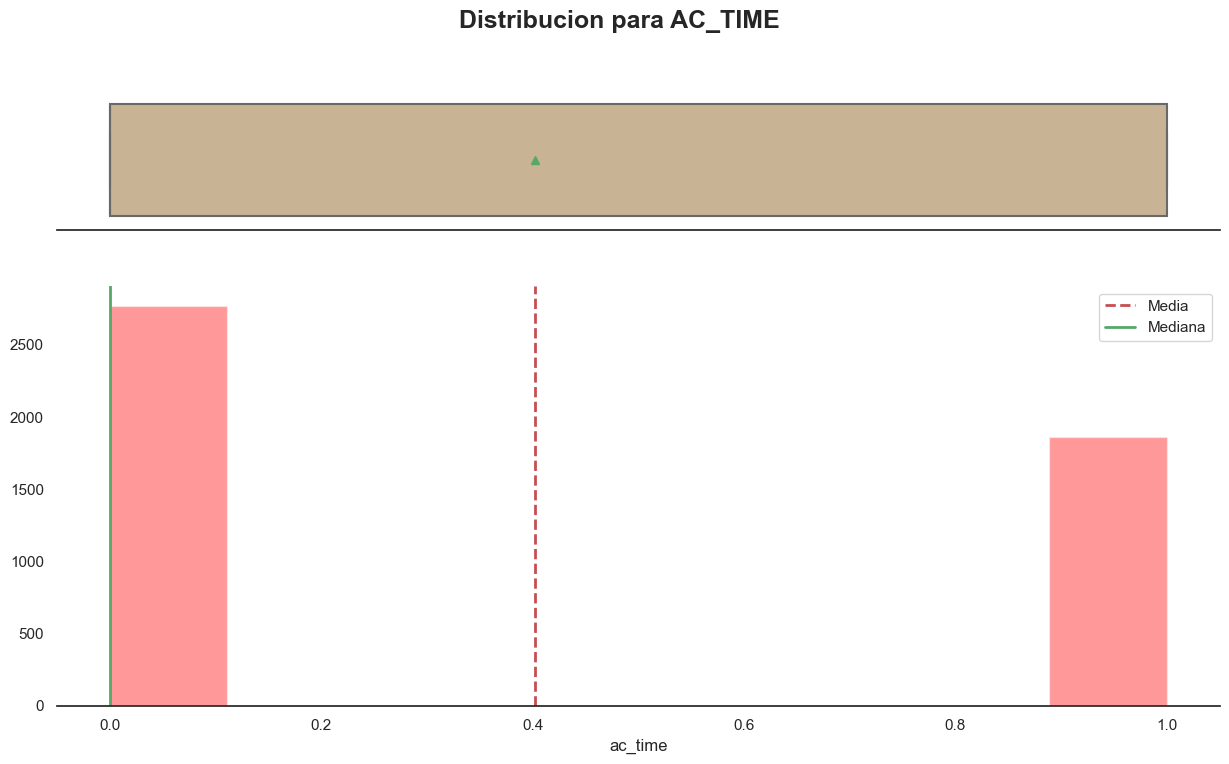

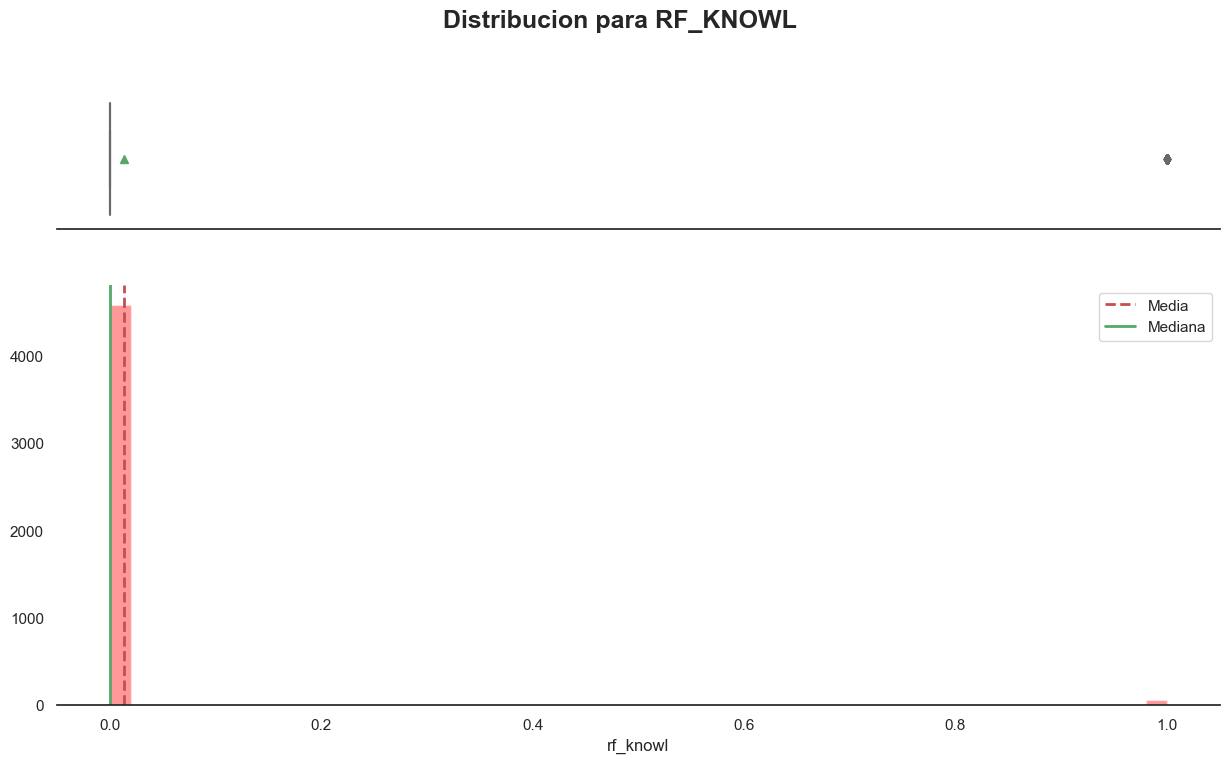

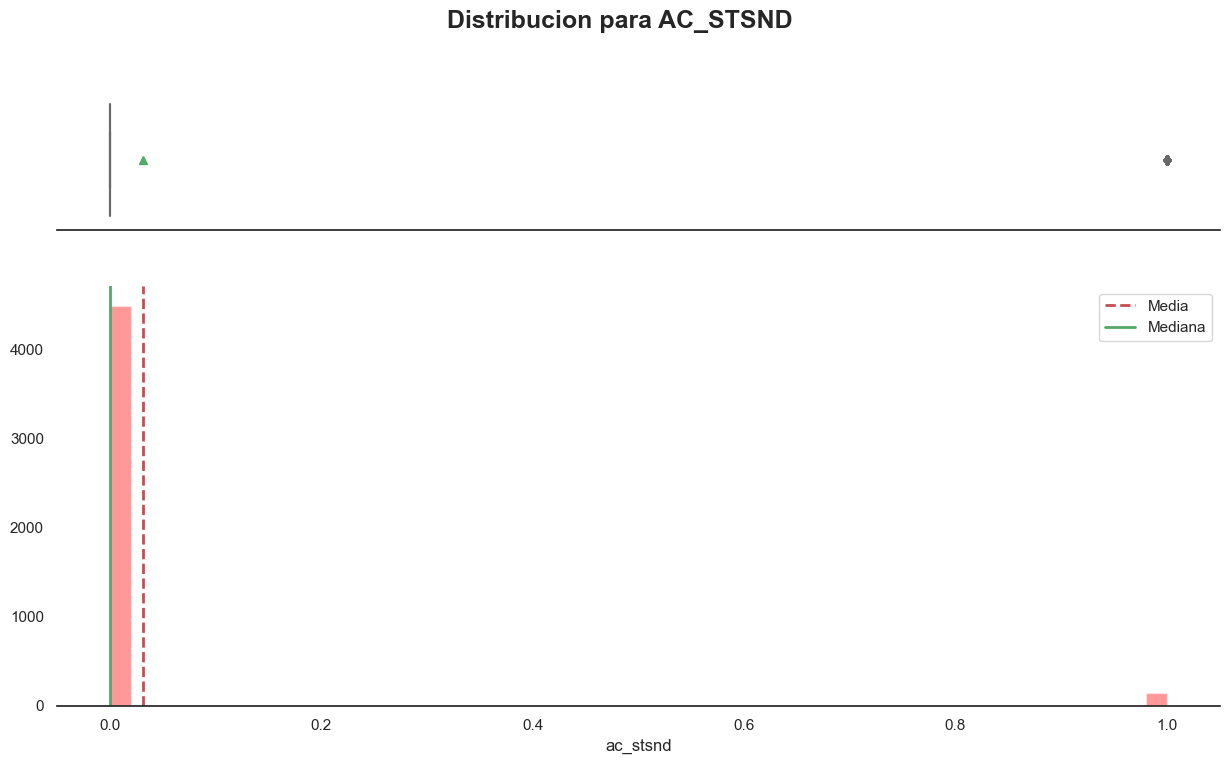

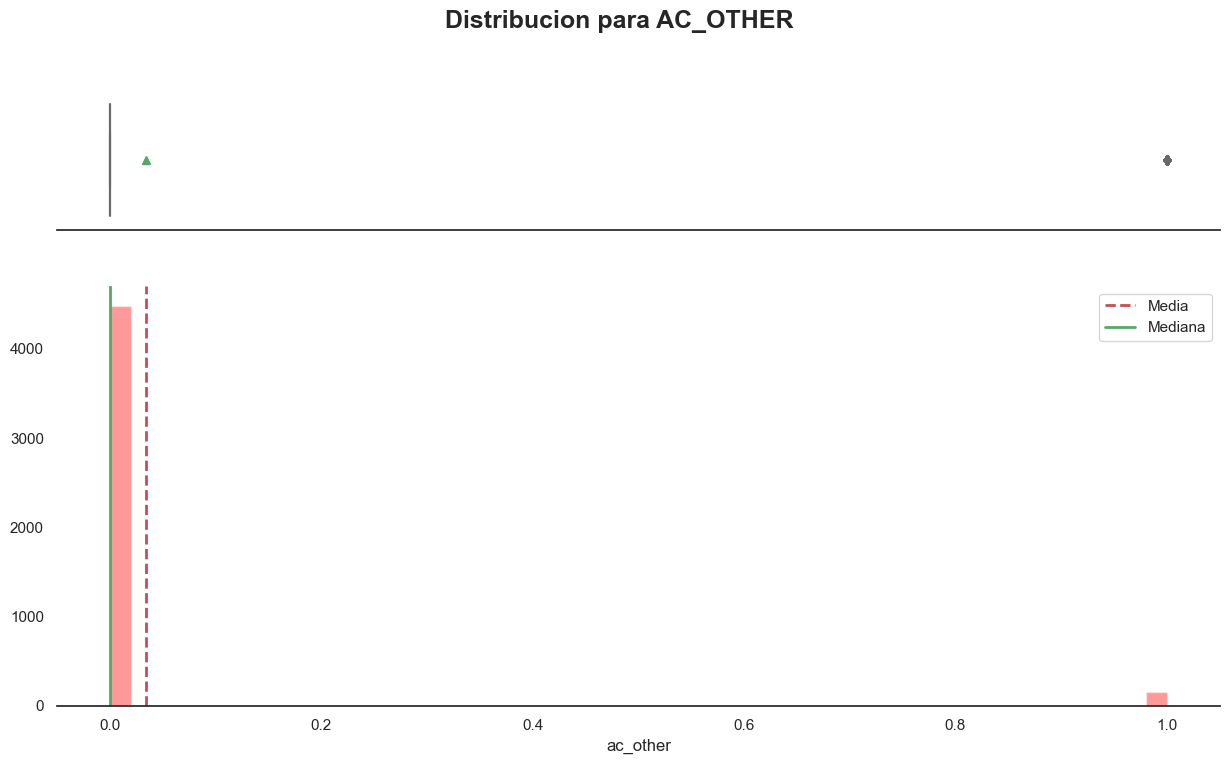

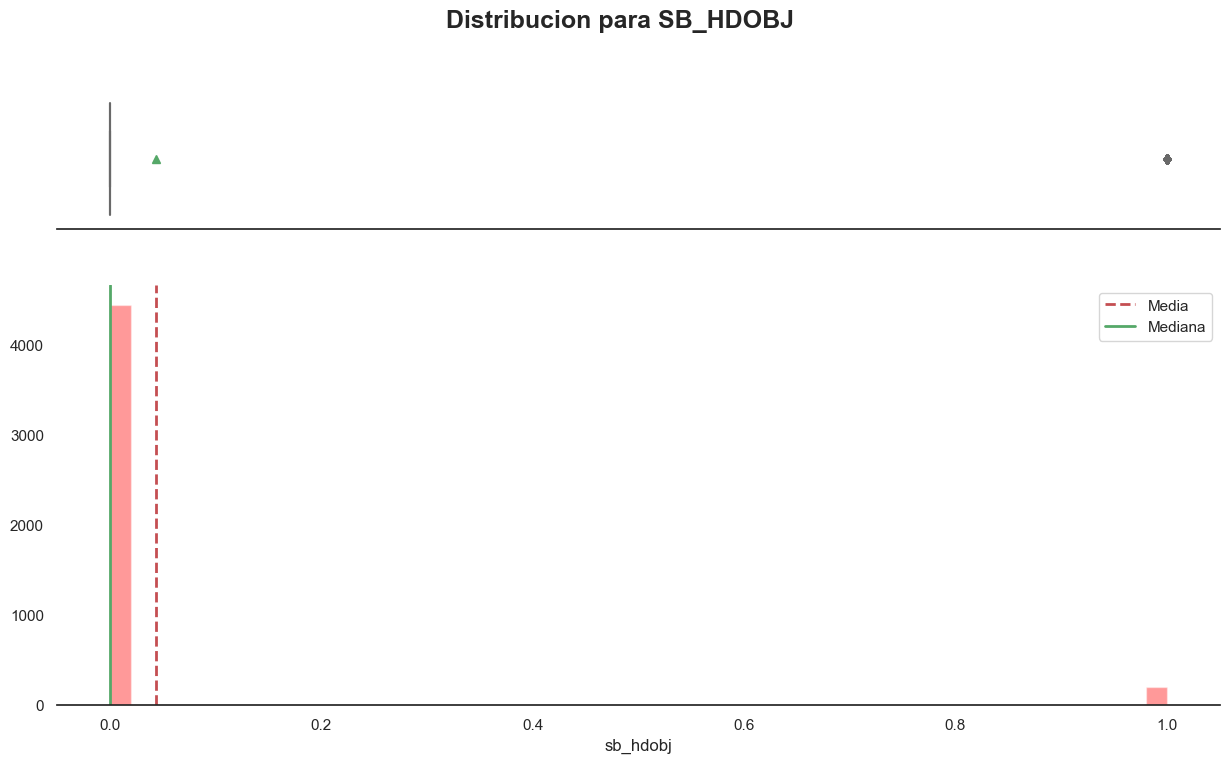

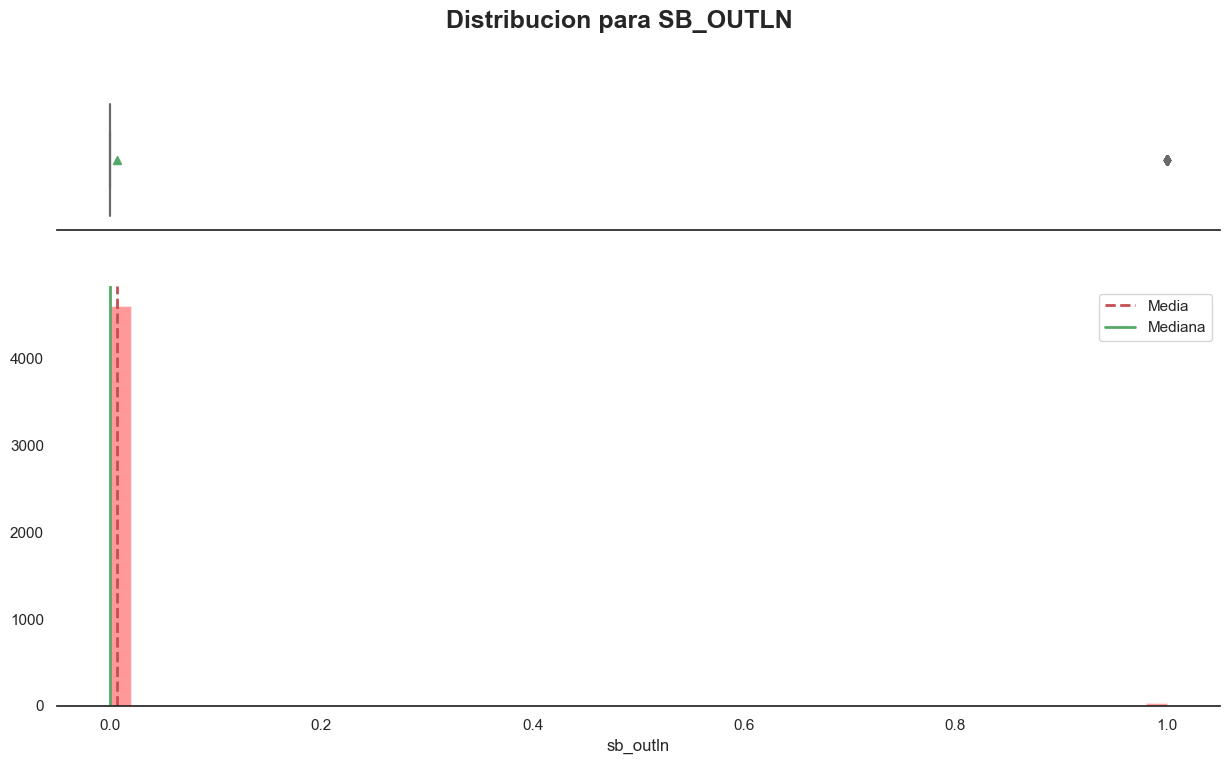

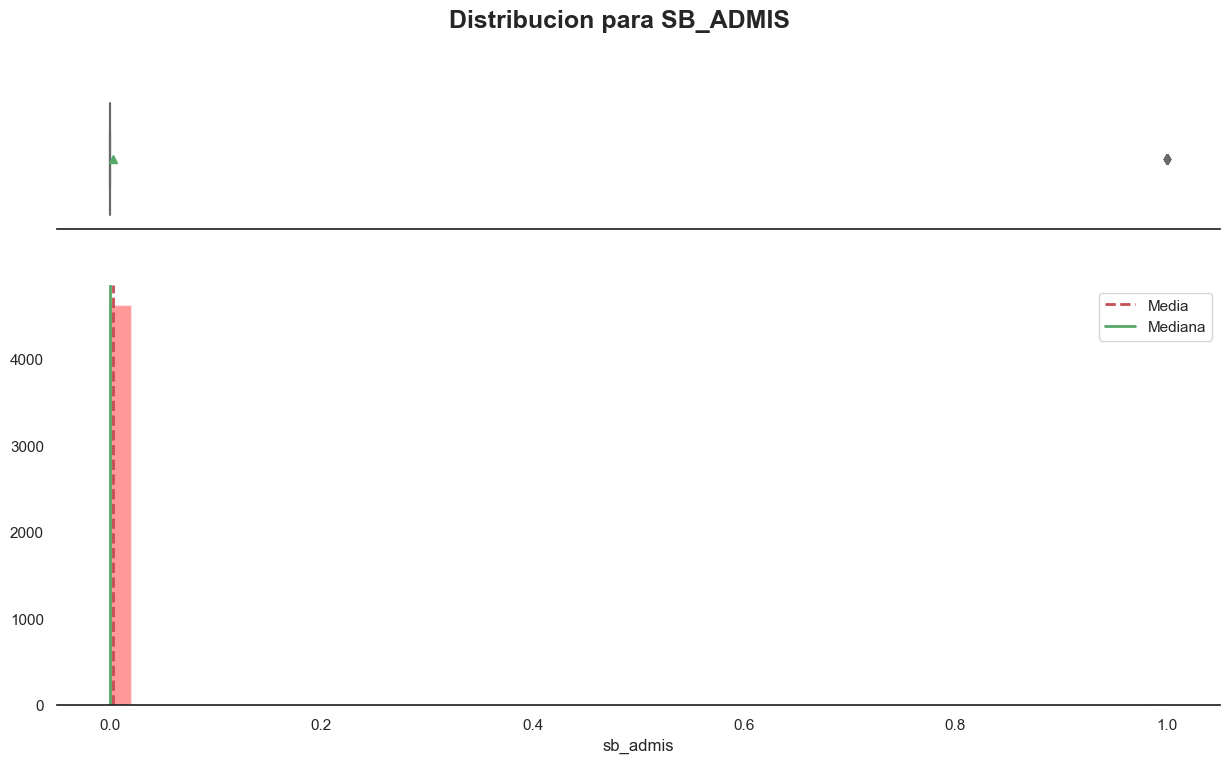

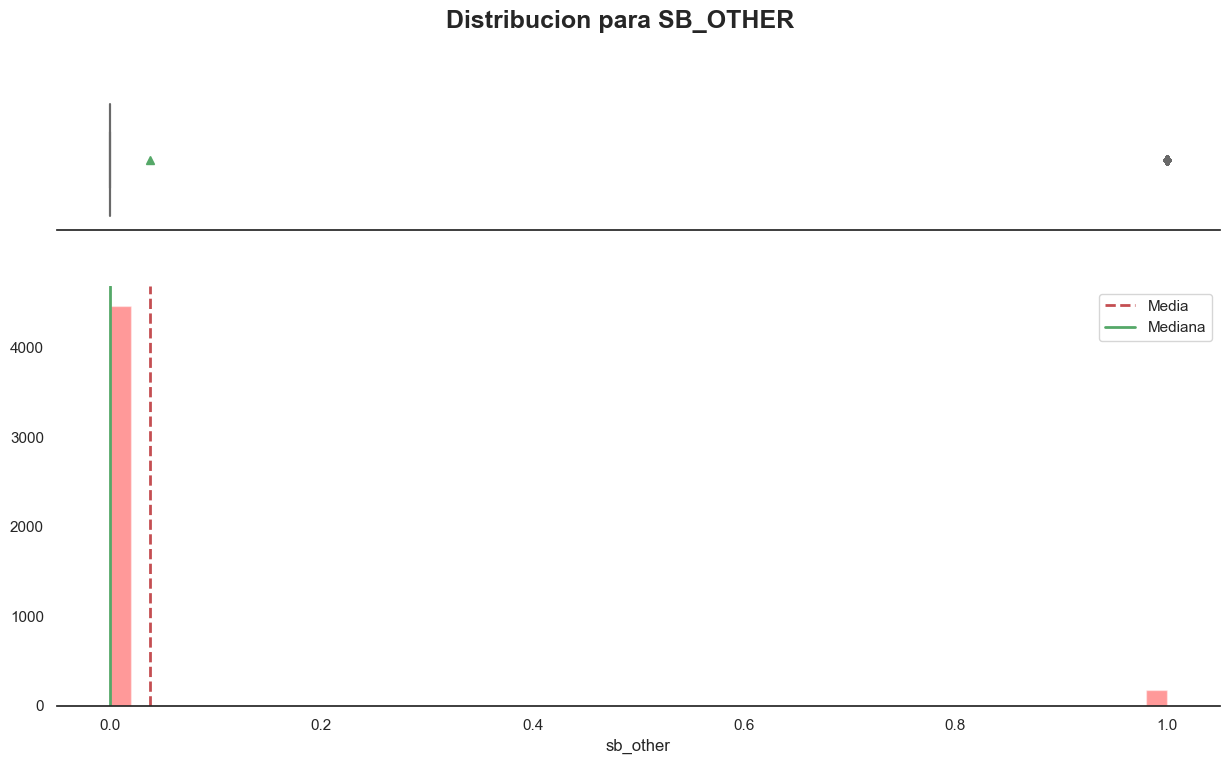

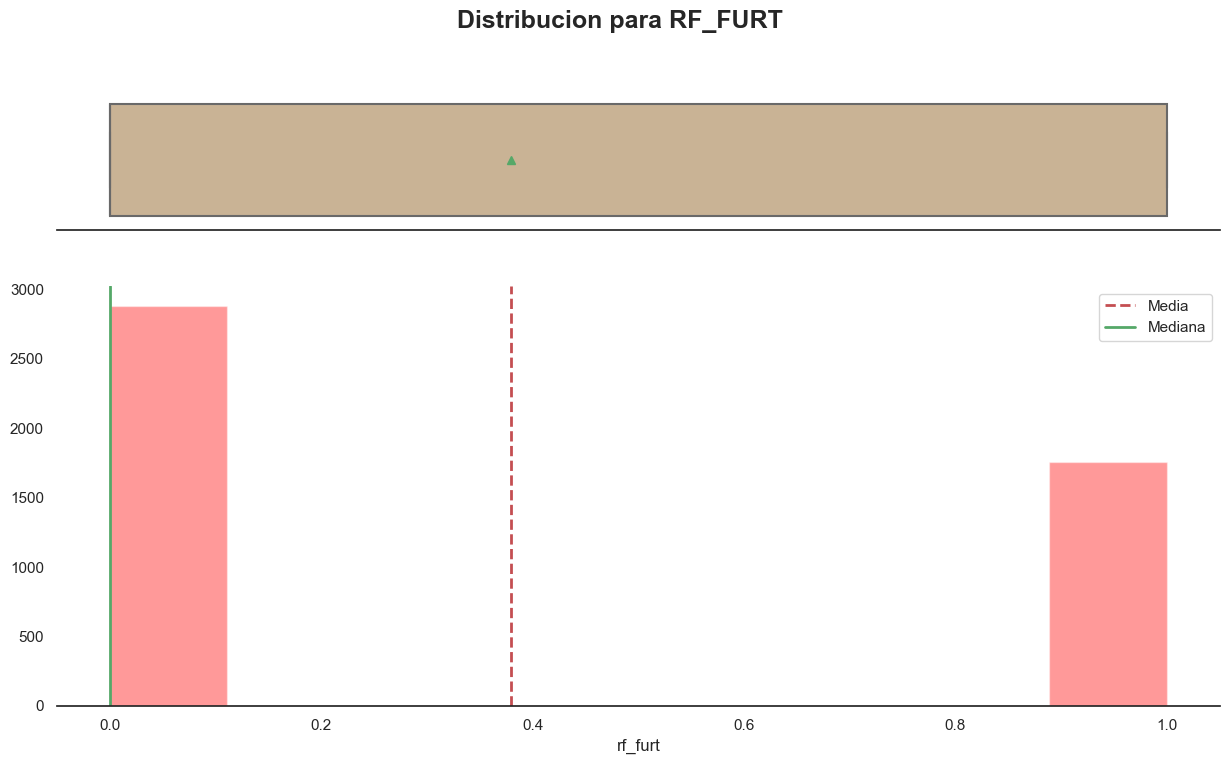

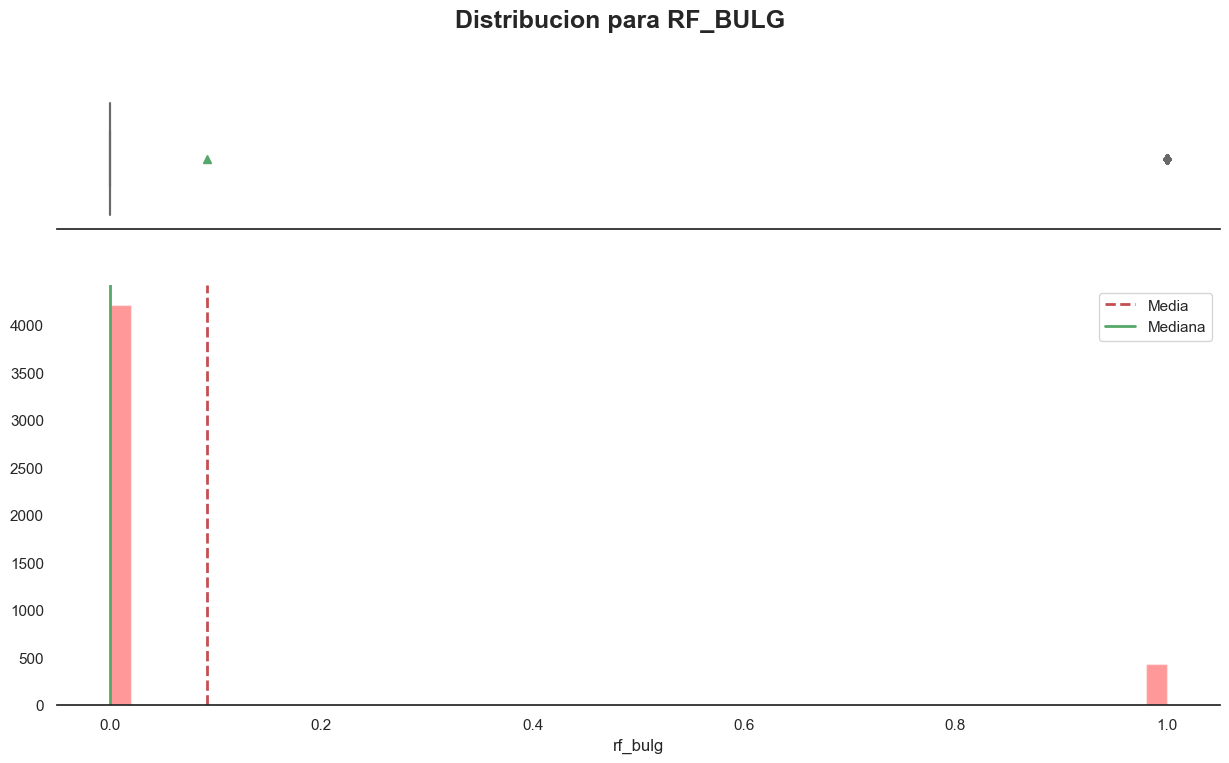

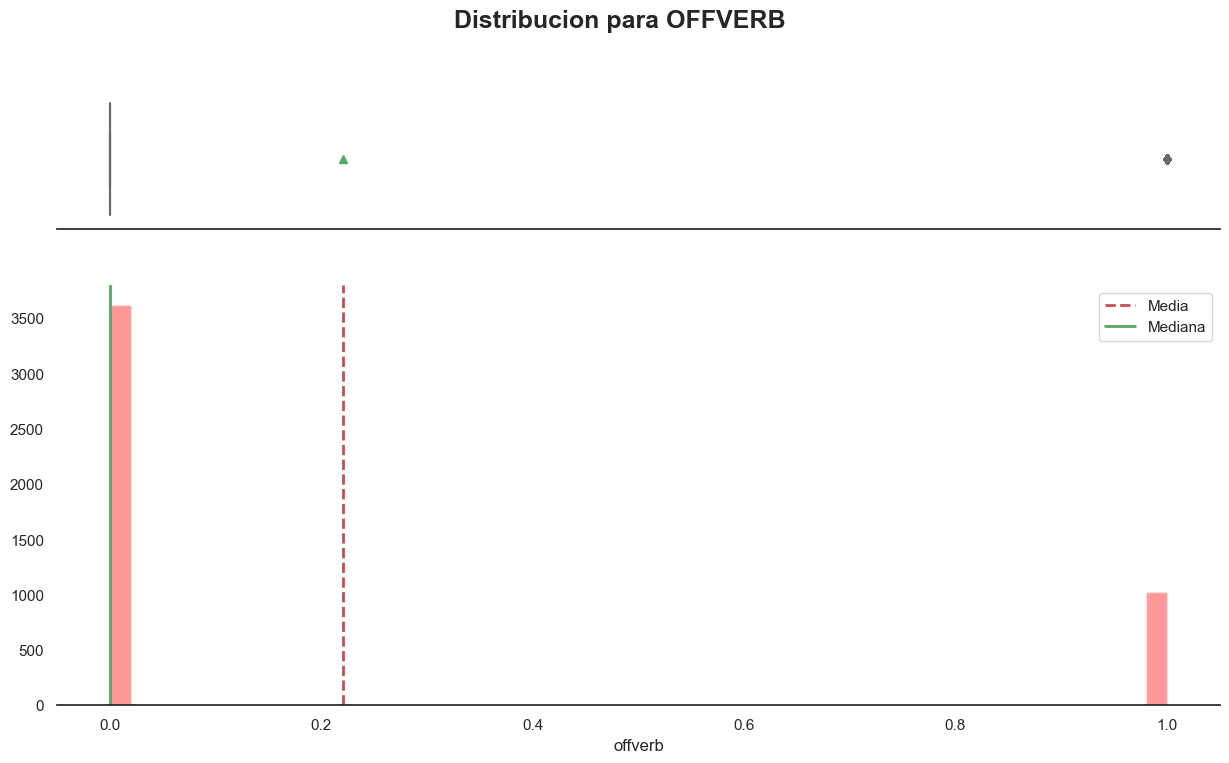

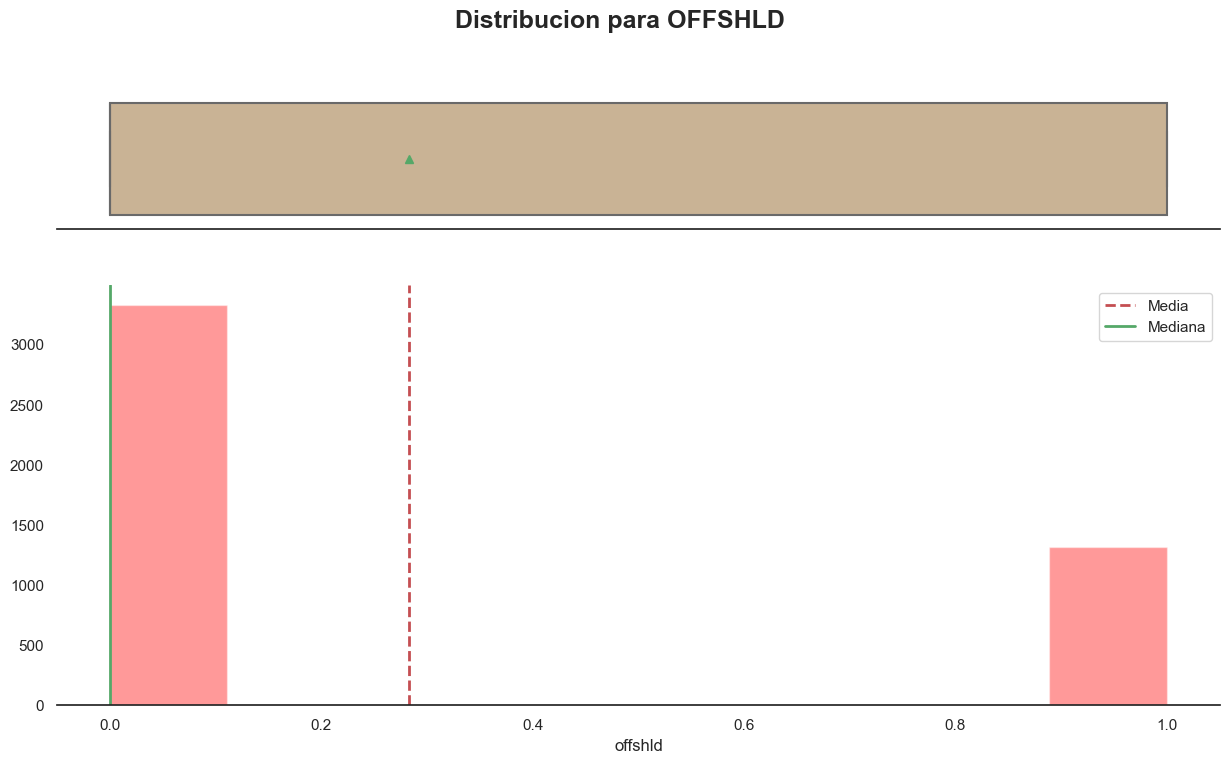

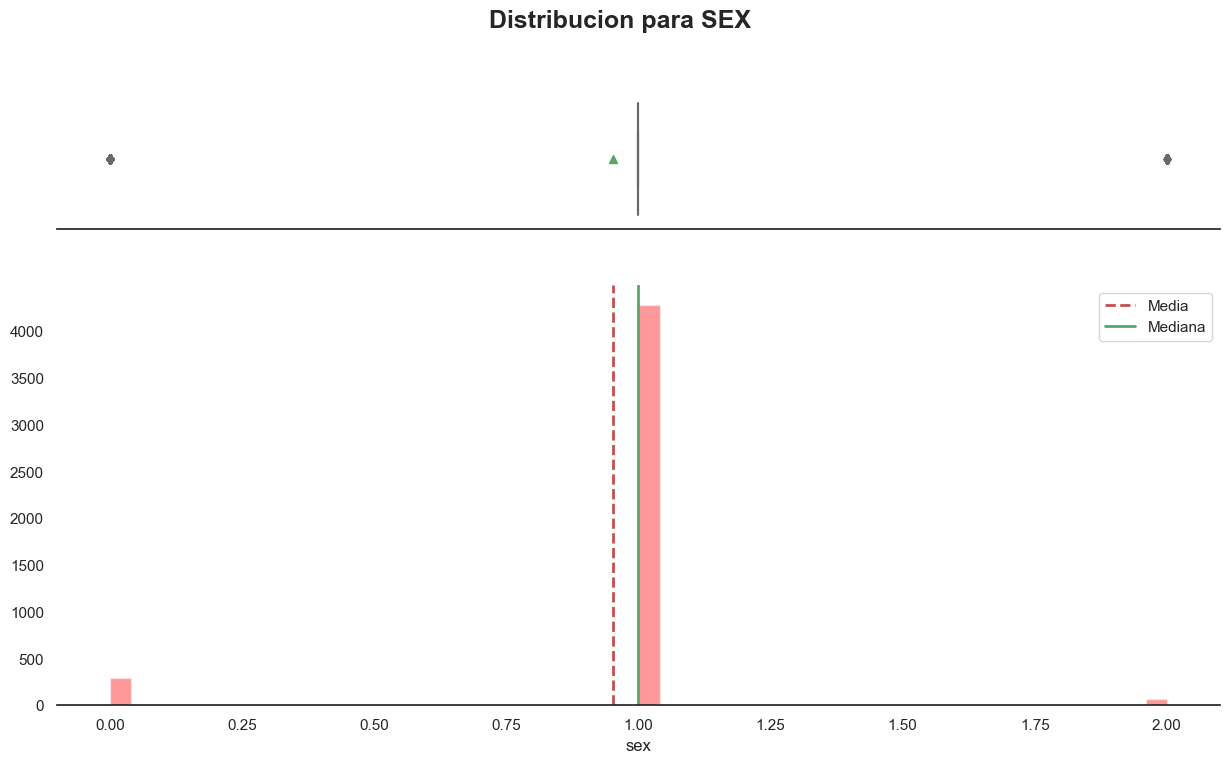

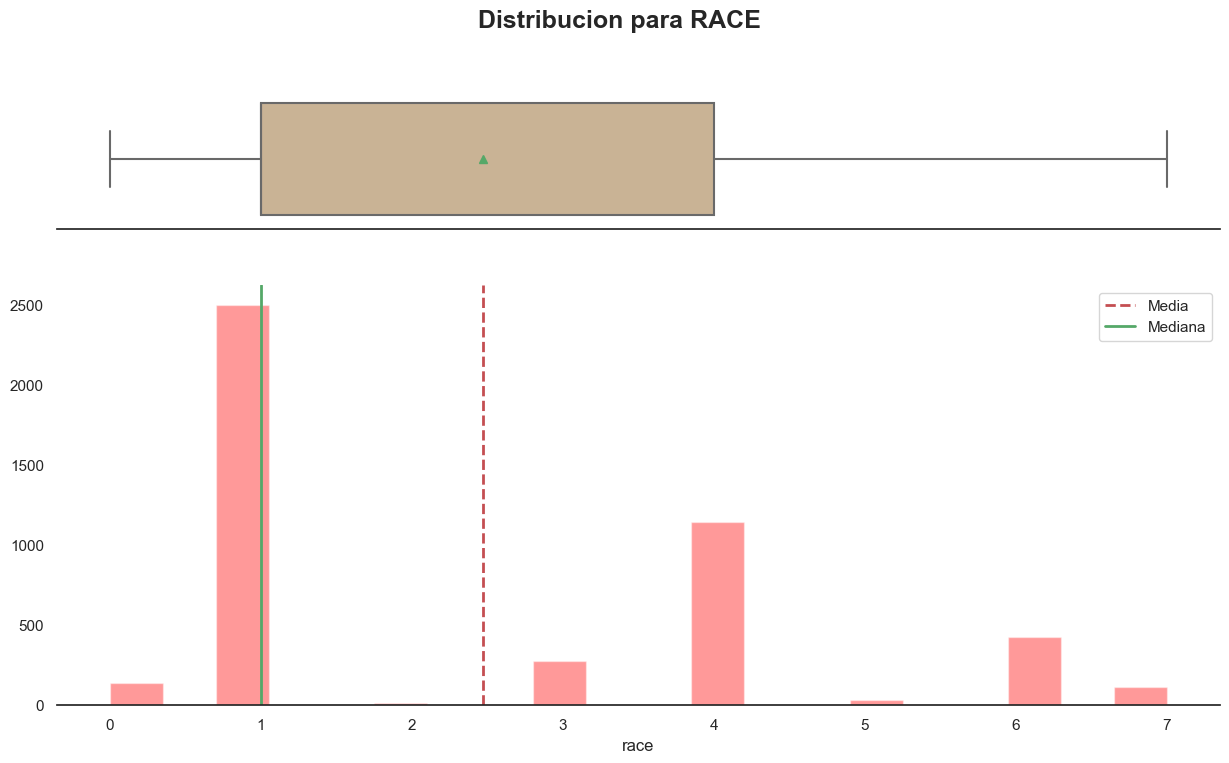

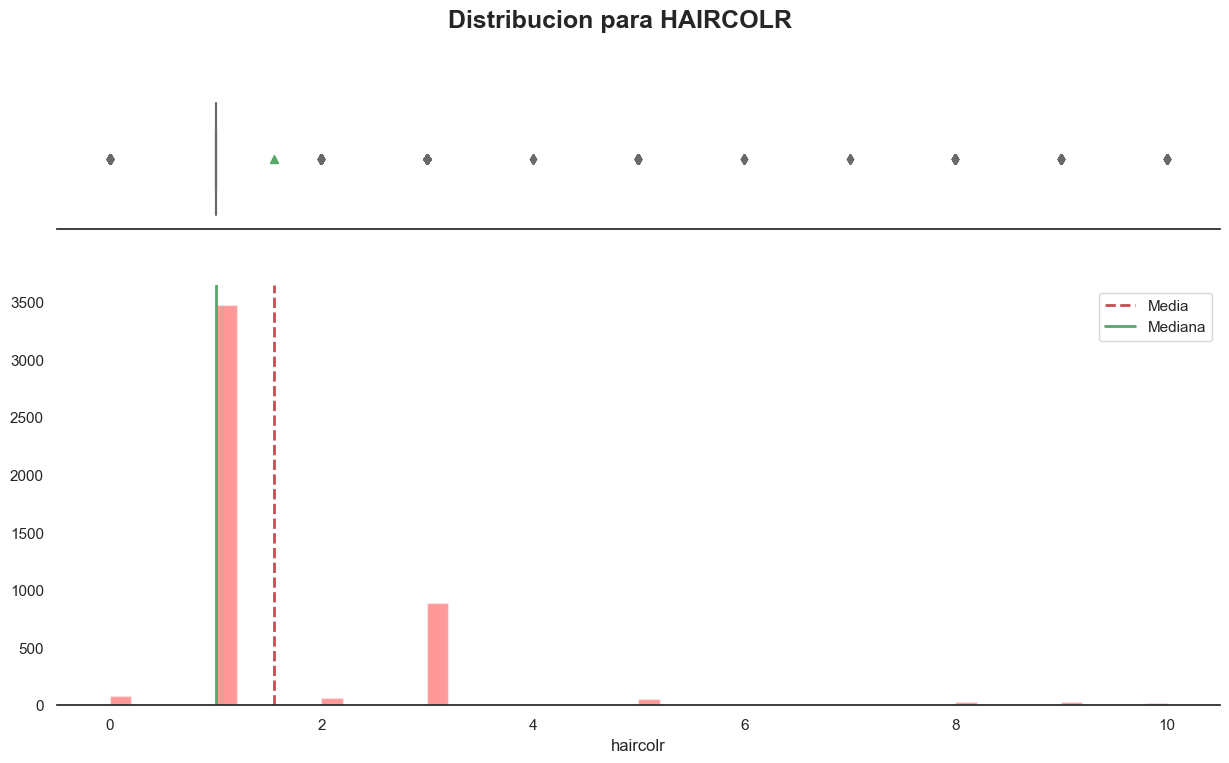

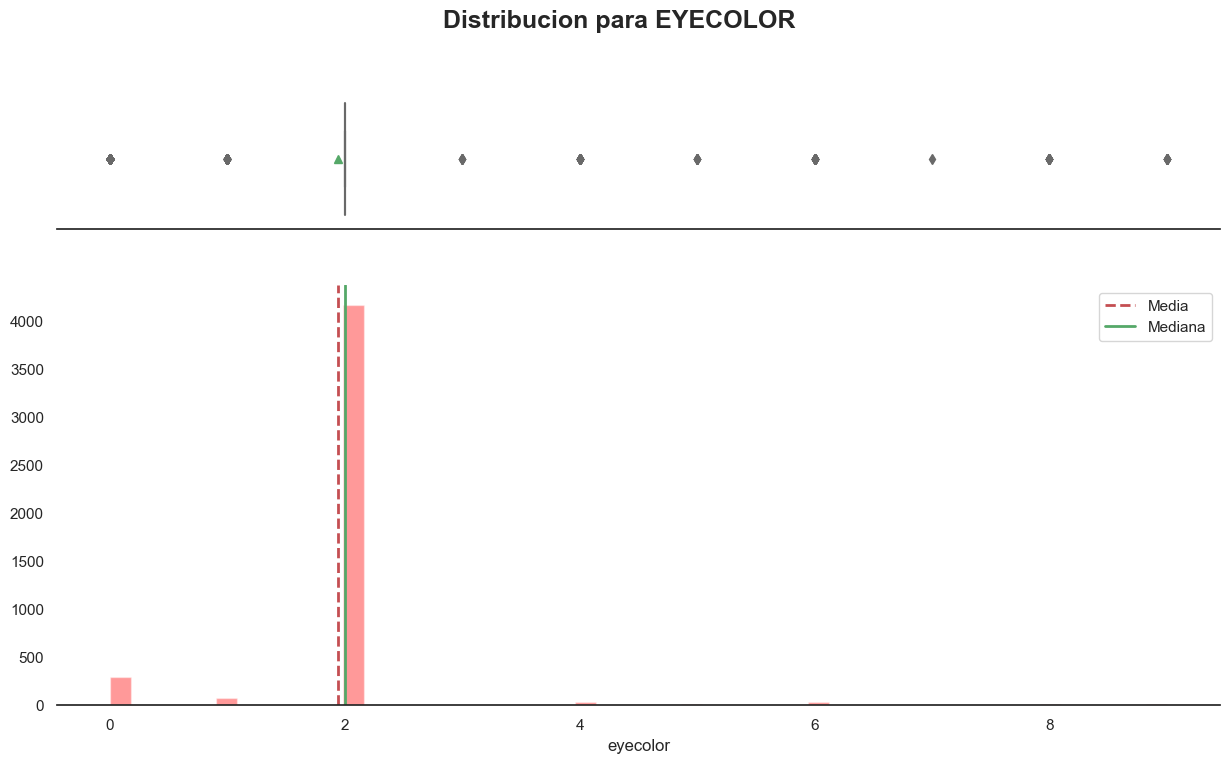

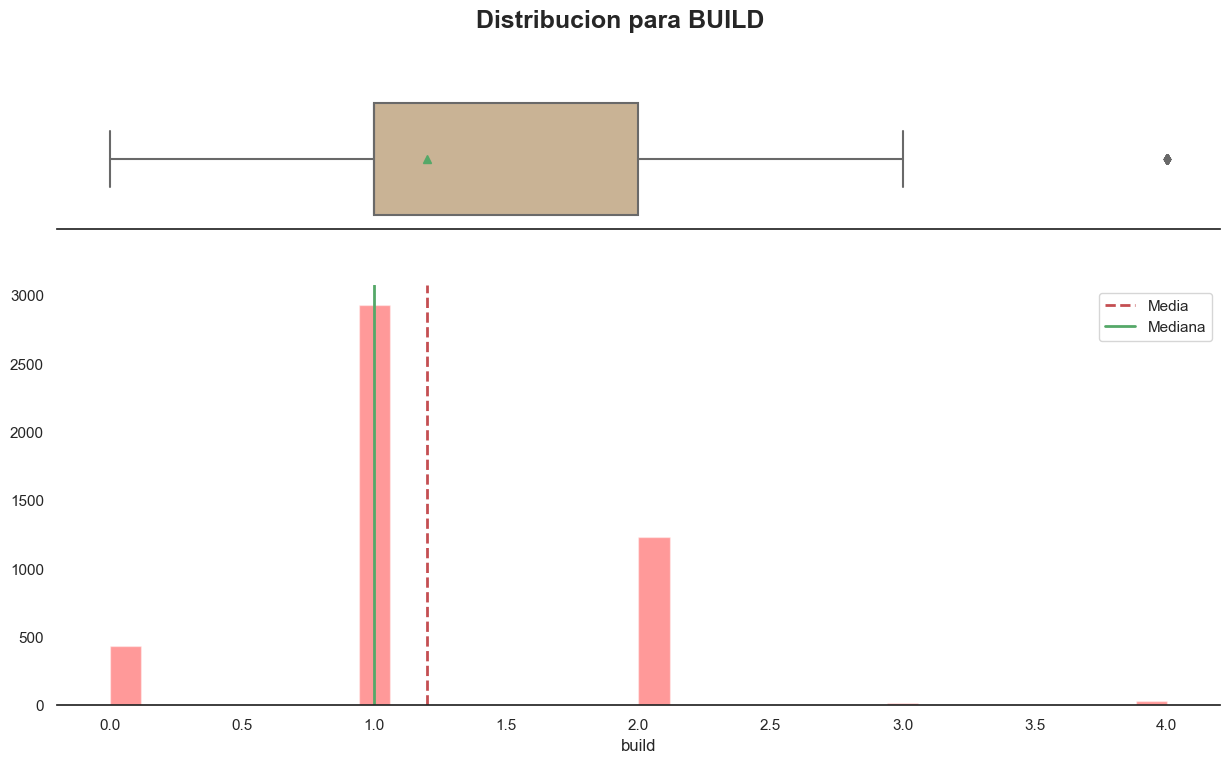

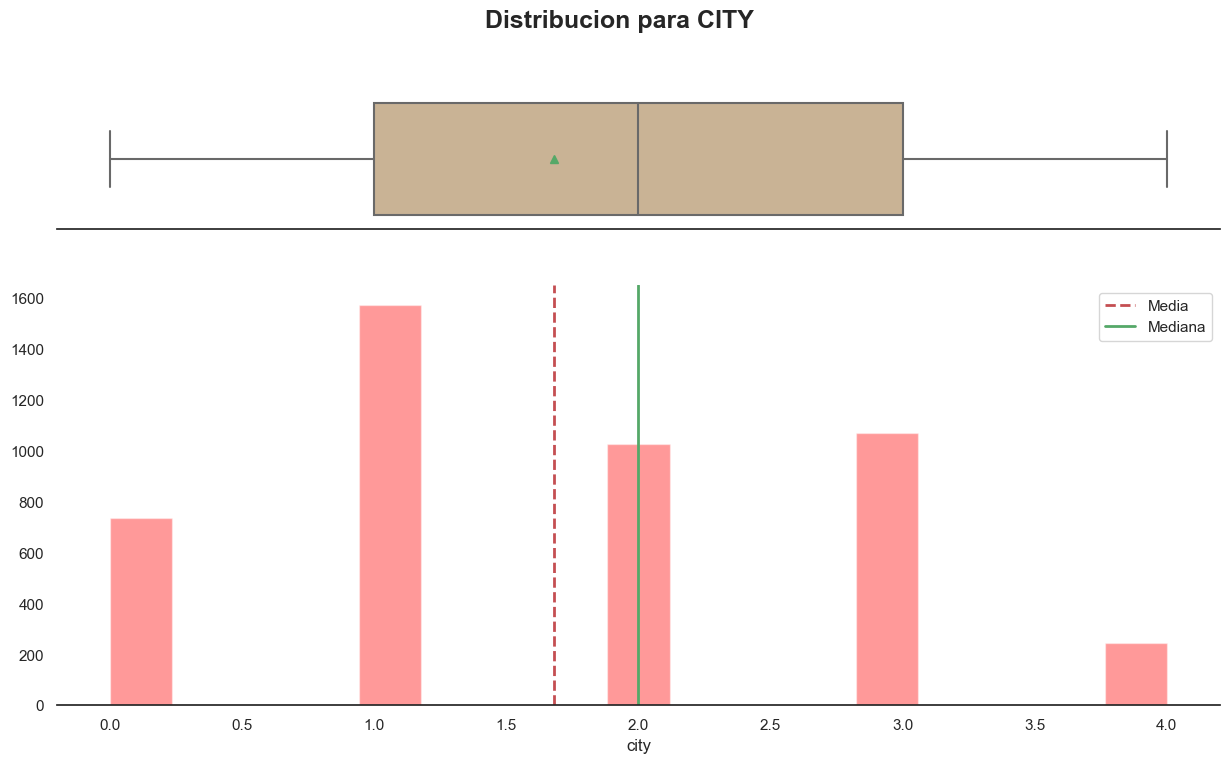

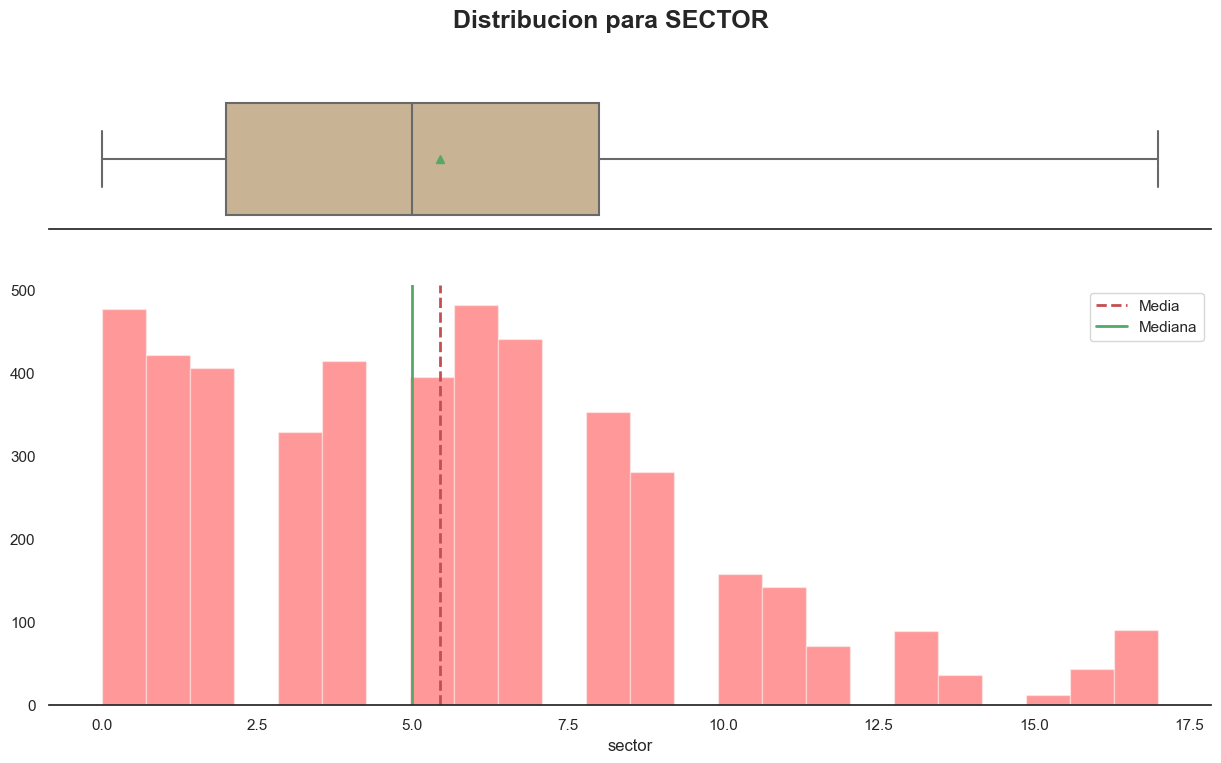

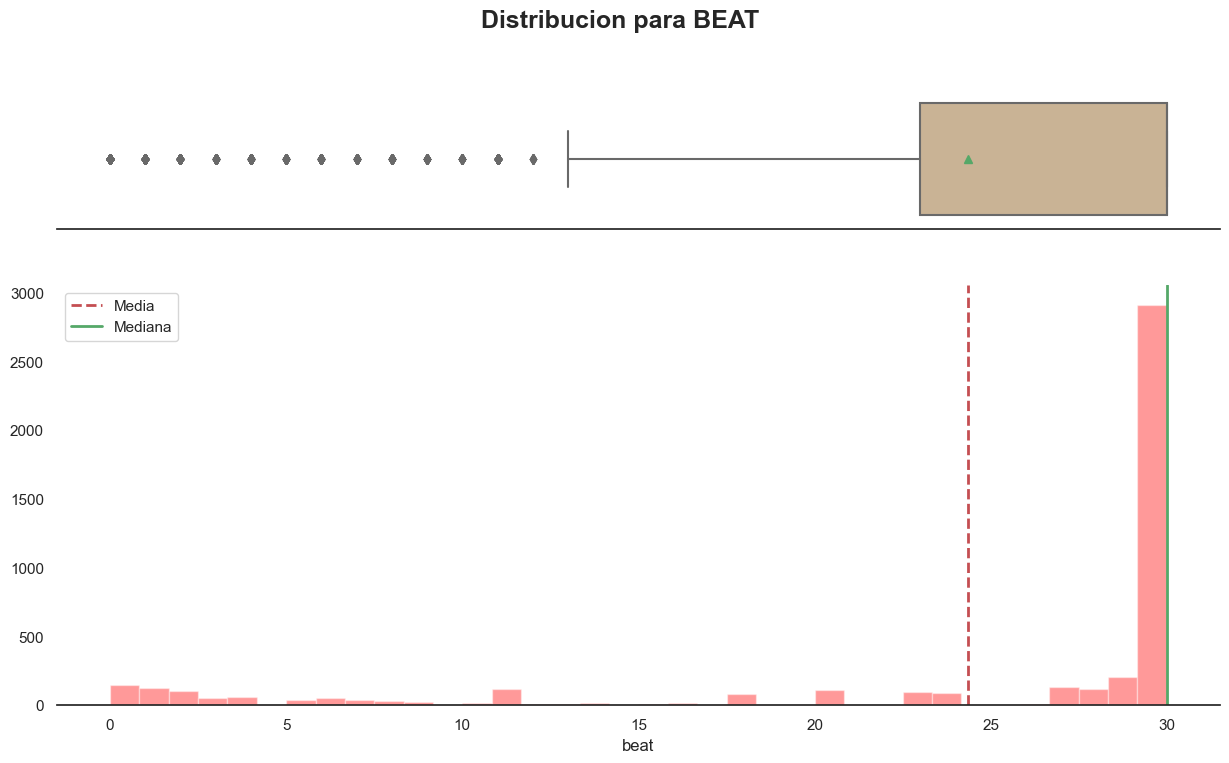

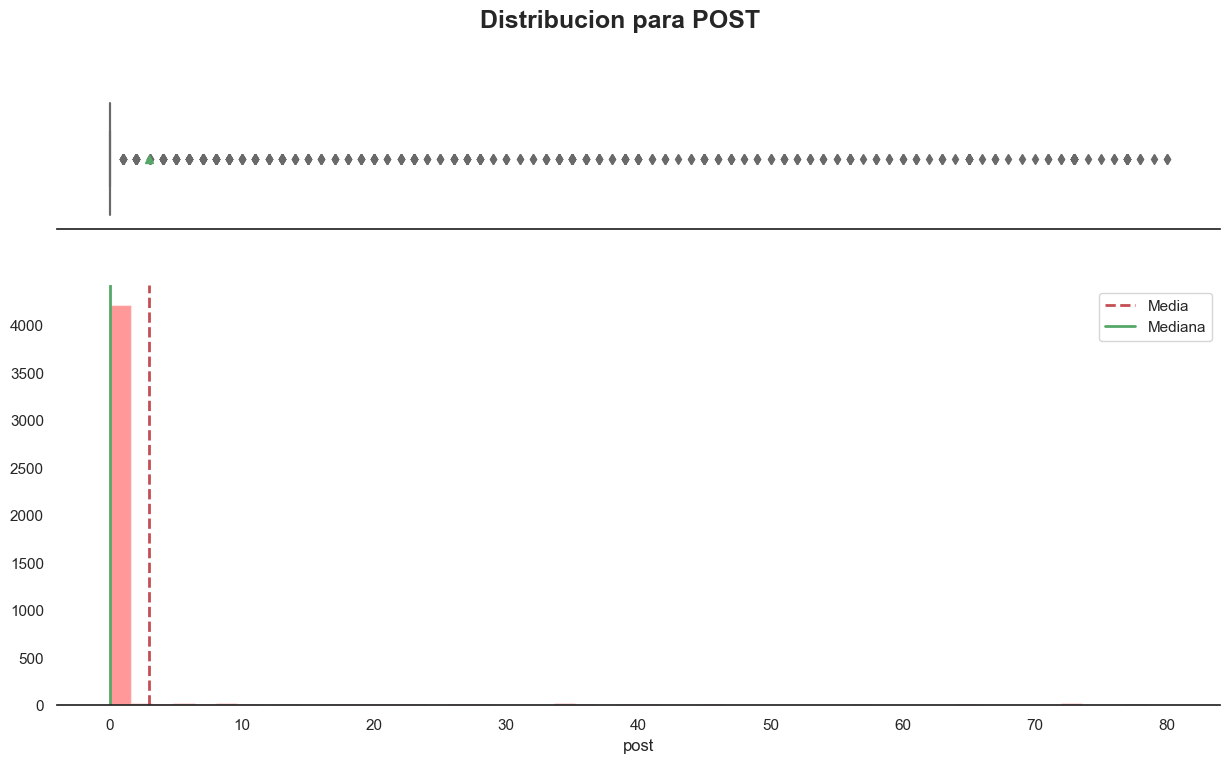

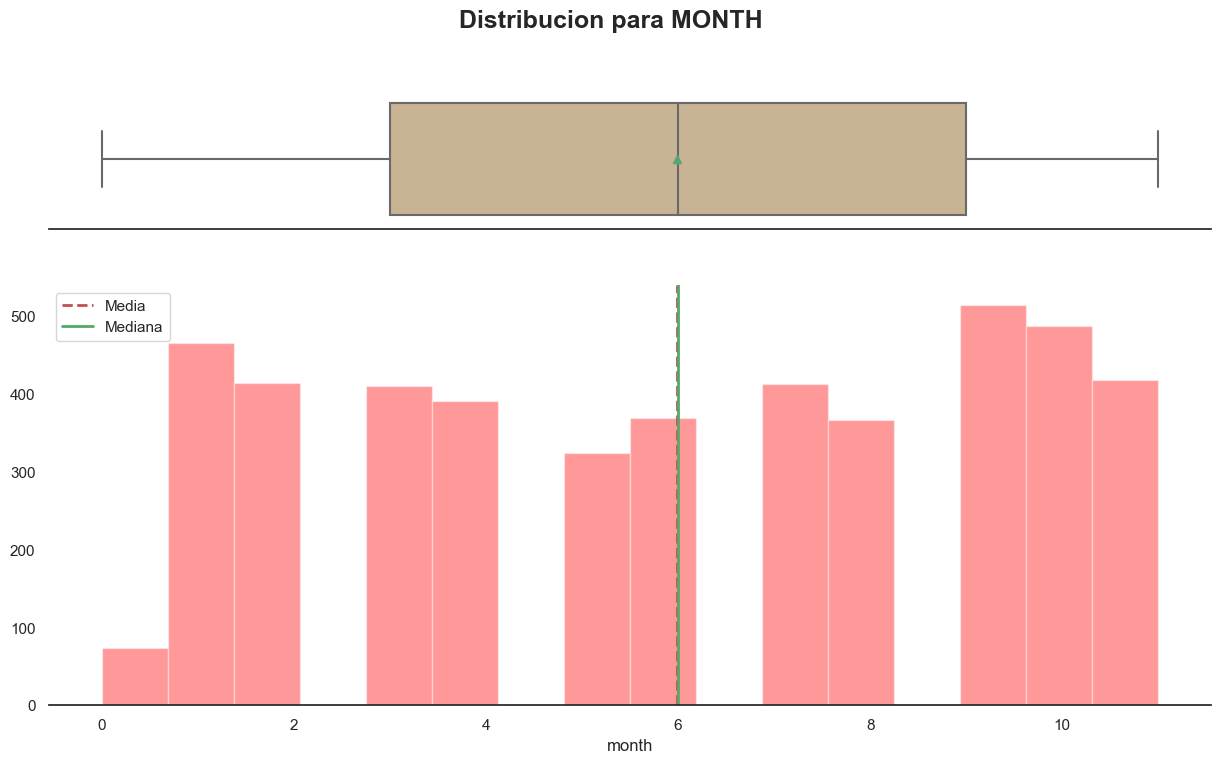

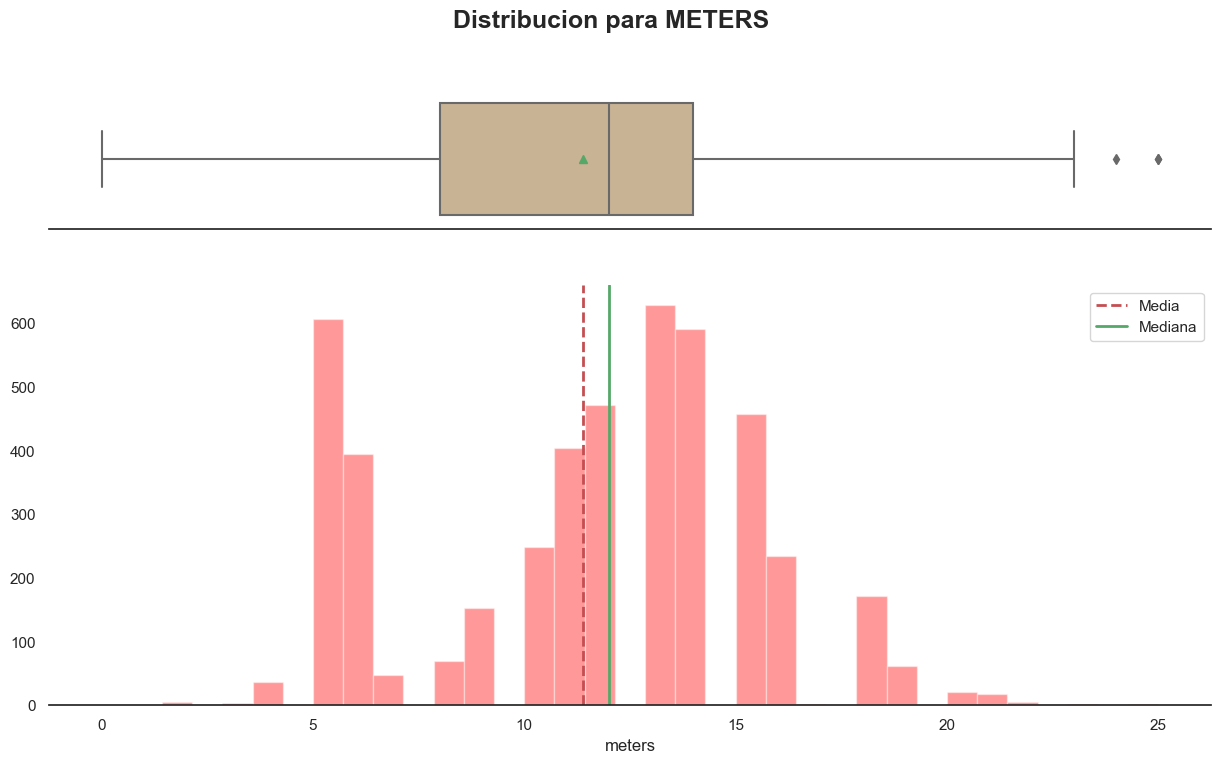

In [10]:
list_vars = proc_df.columns.values

for i in range(len(list_vars)):
    func.dist_box(proc_df_plot[list_vars[i]])


<AxesSubplot:>

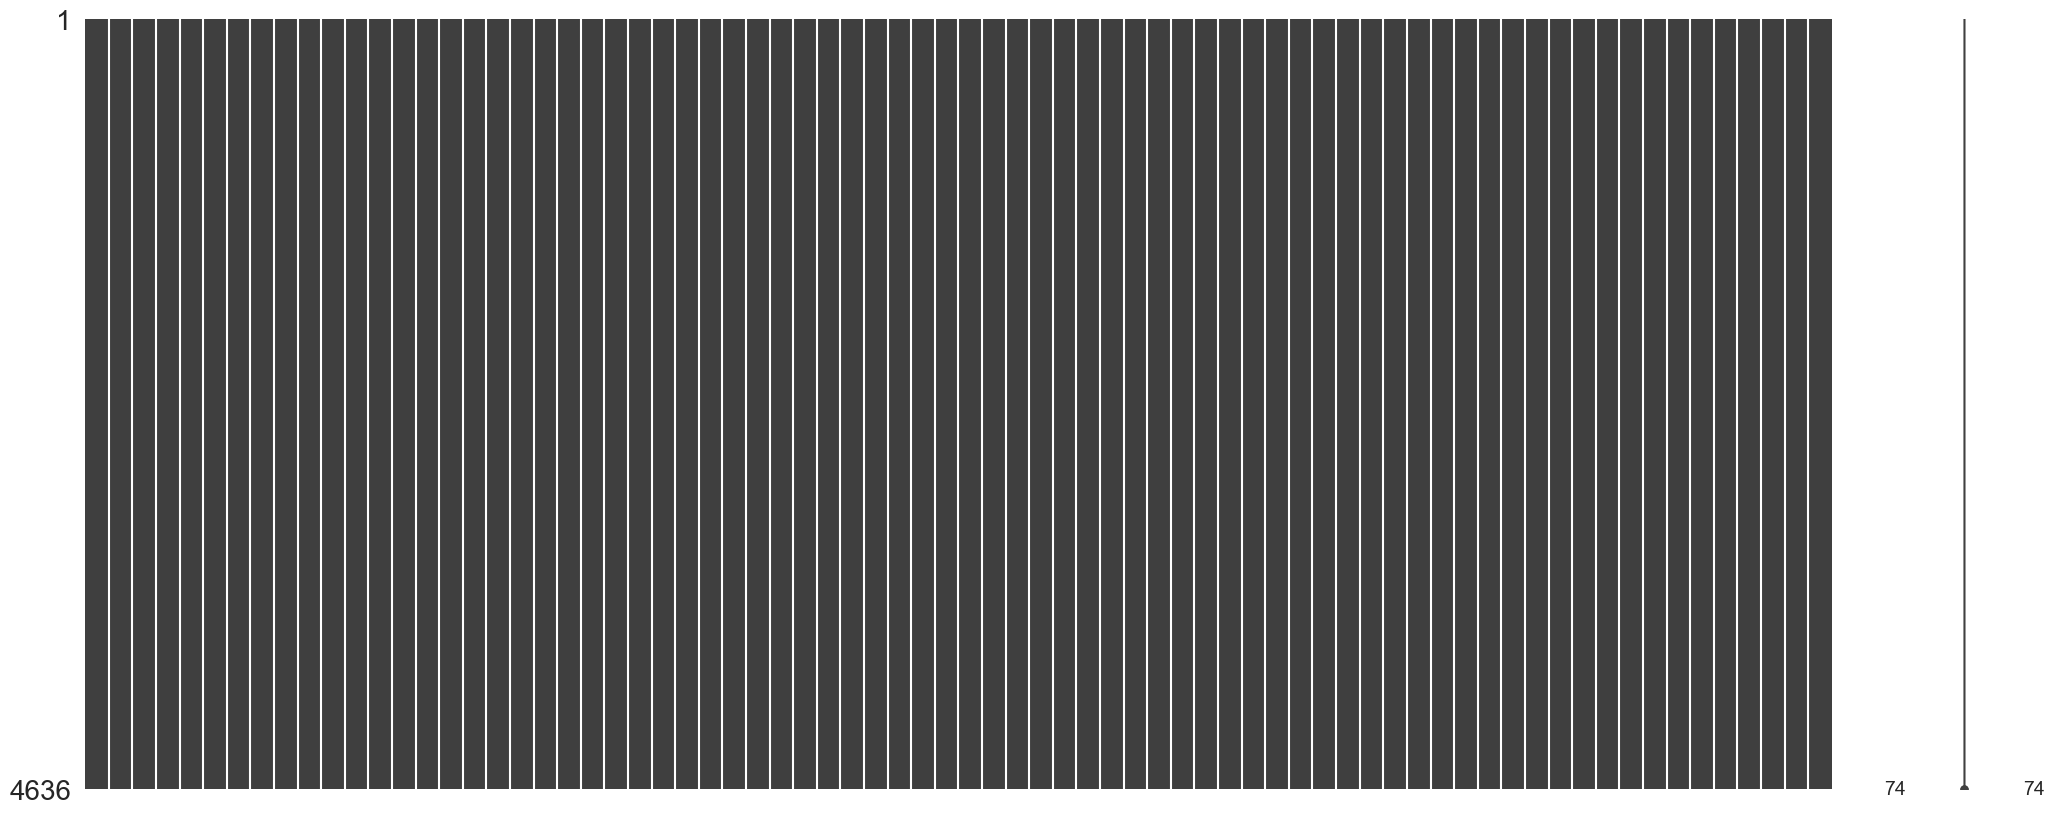

In [11]:
msngo.matrix(proc_df)

El dataset no presenta datos perdidos.

In [12]:
# Revision de variable arstmade
proc_df['arstmade'].value_counts()

N    4355
Y     281
Name: arstmade, dtype: int64

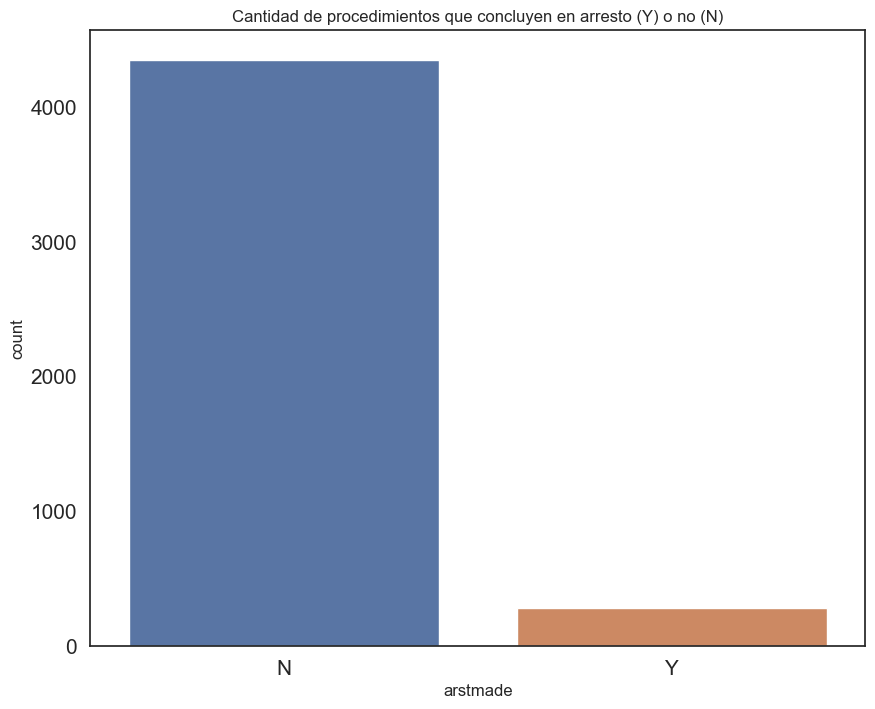

In [13]:
#VARIABLE ARSTMADE
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.title('Cantidad de procedimientos que concluyen en arresto (Y) o no (N)')
sns.countplot(x = 'arstmade', data = proc_df);


In [14]:
# Nuevo dataframe para graficos
df_catplot = proc_df[['arstmade', 'city', 'race', 'sex']]
df_catplot

arstmade       city race sex
0           N      BRONX    B   M
2           N      BRONX    Q   M
3           N   BROOKLYN    B   M
5           N  MANHATTAN    B   M
6           N   BROOKLYN    B   M
...       ...        ...  ...  ..
5806        N      BRONX    B   M
5808        N   BROOKLYN    B   M
5809        N   BROOKLYN    B   M
5810        Y   BROOKLYN    B   M
5811        N  MANHATTAN    U   M

[4636 rows x 4 columns]

In [15]:
# Preprocesamiento de variables parta graficos
df_catplot['city_l'] = LabelEncoder().fit_transform(df_catplot['city'])
df_catplot['race_l'] = LabelEncoder().fit_transform(df_catplot['race'])
df_catplot['sex_l'] = LabelEncoder().fit_transform(df_catplot['sex'])
df_catplot['arstmade_l'] = LabelEncoder().fit_transform(df_catplot['arstmade'])
df_catplot.sample(5, random_state = 15820)

arstmade       city race sex  city_l  race_l  sex_l  arstmade_l
3127        N   BROOKLYN    B   M       1       1      1           0
3413        N   BROOKLYN    B   M       1       1      1           0
828         N  MANHATTAN    B   M       2       1      1           0
4920        N   BROOKLYN    B   M       1       1      1           0
2586        N   BROOKLYN    B   M       1       1      1           0

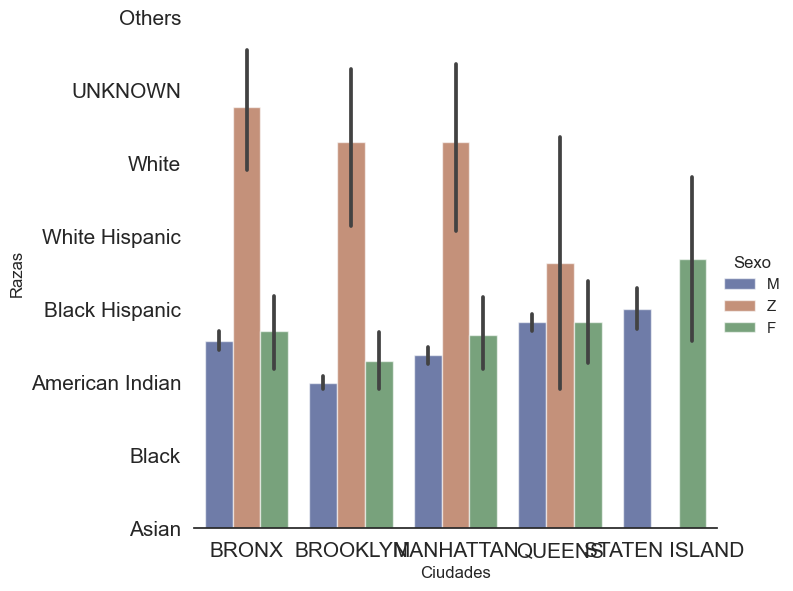

In [16]:
# Distribucion de arrestos por ciudad, sexo y raza
g = sns.catplot(data=df_catplot, kind="bar",
                x = "city_l", y = "race_l", hue = "sex",
                palette = "dark", alpha = .6, height = 6)


g.set_xticklabels(['BRONX','BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'])
g.set_yticklabels(['Asian','Black', 'American Indian', 'Black Hispanic', 'White Hispanic', 'White', 'UNKNOWN', 'Others'])
g.despine(left = True)
g.set_axis_labels("Ciudades", "Razas")
g.legend.set_title("Sexo")

In [17]:
# Renombramos las variables
df_catplot['race'] = df_catplot['race'].replace(['A', 'B', 'I', 'P', 'Q', 'W', 'X', 'Z'], 
            ['ASIAN/PACIFIC ISLANDER', 'BLACK', 'AMERICAN INDIAN/ALASKAN NATIVE', 'BLACK-HISPANIC', 'WHITE-HISPANIC', 'WHITE', 'UNKNOWN', 'OTHER'])

df_catplot['sex'] = df_catplot['sex'].replace(['F', 'M', 'Z'], 
                                        ['FEMALE', 'MALE', 'UNKNOWN'])

In [18]:
# Condicionamos la contatenacion en ciudad, sexo y raza
df_catplot['concat'] = df_catplot.city.str.cat(df_catplot.sex, sep = ' <=> ')
df_catplot['concat'] = df_catplot.concat.str.cat(df_catplot.race, sep = ' <=> ')
df_catplot

arstmade       city            race   sex  city_l  race_l  sex_l  \
0           N      BRONX           BLACK  MALE       0       1      1   
2           N      BRONX  WHITE-HISPANIC  MALE       0       4      1   
3           N   BROOKLYN           BLACK  MALE       1       1      1   
5           N  MANHATTAN           BLACK  MALE       2       1      1   
6           N   BROOKLYN           BLACK  MALE       1       1      1   
...       ...        ...             ...   ...     ...     ...    ...   
5806        N      BRONX           BLACK  MALE       0       1      1   
5808        N   BROOKLYN           BLACK  MALE       1       1      1   
5809        N   BROOKLYN           BLACK  MALE       1       1      1   
5810        Y   BROOKLYN           BLACK  MALE       1       1      1   
5811        N  MANHATTAN               U  MALE       2       5      1   

      arstmade_l                             concat  
0              0           BRONX <=> MALE <=> BLACK  
2              0  BRONX <=> MALE <=> WHITE-HISPANIC  
3              0        BROOKLYN <=> MALE <=> BLACK  
5              0       MANHATTAN <=> MALE <=> BLACK  
6              0        BROOKLYN <=> MALE <=> BLACK  
...          ...                                ...  
5806           0           BRONX <=> MALE <=> BLACK  
5808           0        BROOKLYN <=> MALE <=> BLACK  
5809           0        BROOKLYN <=> MALE <=> BLACK  
5810           1        BROOKLYN <=> MALE <=> BLACK  
5811           0           MANHATTAN <=> MALE <=> U  

[4636 rows x 9 columns]

In [19]:
df2 = np.divide(df_catplot.groupby(['concat']).agg({'arstmade_l':sum}), len(df_catplot))
df2

arstmade_l
concat                                                 
BRONX <=> FEMALE <=> ASIAN/PACIFIC ISLANDER        0.00
BRONX <=> FEMALE <=> BLACK                         0.00
BRONX <=> FEMALE <=> BLACK-HISPANIC                0.00
BRONX <=> FEMALE <=> OTHER                         0.00
BRONX <=> FEMALE <=> WHITE                         0.00
...                                                 ...
STATEN ISLAND <=> MALE <=> BLACK-HISPANIC          0.00
STATEN ISLAND <=> MALE <=> OTHER                   0.00
STATEN ISLAND <=> MALE <=> U                       0.00
STATEN ISLAND <=> MALE <=> WHITE                   0.00
STATEN ISLAND <=> MALE <=> WHITE-HISPANIC          0.00

[84 rows x 1 columns]

In [20]:
# Top 10 de la probabilidad de arresto por city, sex y race
df2 = (df2.sort_values(by = ['arstmade_l'], ascending = False)) * 100
df2.head(10)

arstmade_l
concat                                           
MANHATTAN <=> MALE <=> BLACK                 1.01
BROOKLYN <=> MALE <=> BLACK                  0.84
QUEENS <=> MALE <=> BLACK                    0.56
QUEENS <=> MALE <=> WHITE-HISPANIC           0.43
MANHATTAN <=> MALE <=> WHITE-HISPANIC        0.43
BRONX <=> MALE <=> BLACK                     0.37
QUEENS <=> MALE <=> WHITE                    0.26
BRONX <=> MALE <=> WHITE-HISPANIC            0.26
BROOKLYN <=> MALE <=> WHITE-HISPANIC         0.24
BROOKLYN <=> FEMALE <=> BLACK                0.15

In [21]:
prob_ot = (len(df_catplot[df_catplot['arstmade'] == 'Y']))/len(df_catplot)

In [22]:
# Probabilidad de arresto en alguna ciudad
df_catplot['concat'].value_counts('%').sort_values(ascending = False).head(10)

BROOKLYN <=> MALE <=> BLACK             0.22
MANHATTAN <=> MALE <=> BLACK            0.11
QUEENS <=> MALE <=> BLACK               0.08
QUEENS <=> MALE <=> WHITE-HISPANIC      0.08
BRONX <=> MALE <=> BLACK                0.07
MANHATTAN <=> MALE <=> WHITE-HISPANIC   0.05
BROOKLYN <=> MALE <=> WHITE-HISPANIC    0.05
BRONX <=> MALE <=> WHITE-HISPANIC       0.04
QUEENS <=> MALE <=> WHITE               0.03
BROOKLYN <=> MALE <=> WHITE             0.02
Name: concat, dtype: float64

In [23]:
proc_df_l = pd.DataFrame()

for colums in proc_df.columns:
    proc_df_l[colums] = LabelEncoder().fit_transform(proc_df[colums])

Se recodifica el dataset completo incluyendo al vector objetivo artsmade.

In [24]:
proc_df_l

recstat  inout  trhsloc  typeofid  explnstp  othpers  arstmade  \
0           1      1        1         1         1        0         0   
1           0      1        1         3         1        0         0   
2           1      1        1         1         1        0         0   
3           0      0        2         3         1        0         0   
4           0      1        1         1         1        0         0   
...       ...    ...      ...       ...       ...      ...       ...   
4631        1      1        1         3         1        1         0   
4632        1      1        1         1         1        0         0   
4633        0      1        1         1         1        0         0   
4634        0      1        0         1         1        0         1   
4635        0      1        0         1         1        0         0   

      sumissue  offunif  officrid  ...  race  haircolr  eyecolor  build  city  \
0            0        1         0  ...     1         1         2      1     0   
1            0        0         0  ...     4         3         2      1     0   
2            0        1         0  ...     1         1         2      2     1   
3            0        0         1  ...     1         1         2      1     2   
4            0        1         0  ...     1         1         2      2     1   
...        ...      ...       ...  ...   ...       ...       ...    ...   ...   
4631         0        1         0  ...     1         1         2      1     0   
4632         0        0         0  ...     1         1         2      2     1   
4633         0        1         0  ...     1         1         2      1     1   
4634         0        1         0  ...     1         1         2      2     1   
4635         0        1         0  ...     5         1         2      1     2   

      sector  beat  post  month  meters  
0          6    27     0      3      14  
1          4    30     0      9      19  
2          9    20    29     11      10  
3          5     7     0      4      13  
4         12    30     0     10       6  
...      ...   ...   ...    ...     ...  
4631      12    30    23      4       5  
4632       5     8     0      8       6  
4633       1    30     0      5      12  
4634       0     1     0      2      13  
4635       3    30     0      4      15  

[4636 rows x 74 columns]

In [25]:
# Creamos la matris de atributos y la separamos del vector objetivo
# Separamos los datos de entrenamiento y validacion
X = proc_df_l.drop(columns = 'arstmade')
y = proc_df_l['arstmade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 15820)

In [26]:
clf_nc = NearestCentroid()
model_nc = clf_nc.fit(X_train, y_train)
model_nc

NearestCentroid()

In [27]:
y_pred_nc = model_nc.predict(X_test)
print(classification_report(y_test, y_pred_nc))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1431
           1       0.08      0.11      0.10        99

    accuracy                           0.86      1530
   macro avg       0.51      0.51      0.51      1530
weighted avg       0.88      0.86      0.87      1530



In [28]:
gnb = GaussianNB()
model_gnb = gnb.fit(X_train, y_train)
model_gnb

GaussianNB()

In [29]:
y_pred_gnb = model_gnb.predict(X_test)
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1431
           1       0.56      0.65      0.60        99

    accuracy                           0.94      1530
   macro avg       0.77      0.81      0.78      1530
weighted avg       0.95      0.94      0.95      1530



In [30]:
clf_lda = LinearDiscriminantAnalysis()
model_lda = clf_lda.fit(X_train, y_train)
model_lda

LinearDiscriminantAnalysis()

In [31]:
y_pred_lda = model_lda.predict(X_test)
print(classification_report(y_test, y_pred_lda))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1431
           1       0.78      0.60      0.67        99

    accuracy                           0.96      1530
   macro avg       0.87      0.79      0.83      1530
weighted avg       0.96      0.96      0.96      1530



In [32]:
clf_bn = BernoulliNB()
model_bn = clf_bn.fit(X_train, y_train)
model_bn

BernoulliNB()

In [33]:
y_pred_bn = model_lda.predict(X_test)
print(classification_report(y_test, y_pred_bn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1431
           1       0.78      0.60      0.67        99

    accuracy                           0.96      1530
   macro avg       0.87      0.79      0.83      1530
weighted avg       0.96      0.96      0.96      1530



In [34]:
'''condicion = (proc_df['pf_baton'] == 'Y') | (proc_df['pf_drwep'] == 'Y') | (proc_df['pf_grnd'] == 'Y') | (proc_df['pf_hands'] == 'Y') |\
        (proc_df['pf_hcuff'] == 'Y') | (proc_df['pf_other'] == 'Y') | (proc_df['pf_pepsp'] == 'Y') | (proc_df['pf_ptwep'] == 'Y') | (proc_df['pf_wall'] == 'Y')'''

"condicion = (proc_df['pf_baton'] == 'Y') | (proc_df['pf_drwep'] == 'Y') | (proc_df['pf_grnd'] == 'Y') | (proc_df['pf_hands'] == 'Y') |        (proc_df['pf_hcuff'] == 'Y') | (proc_df['pf_other'] == 'Y') | (proc_df['pf_pepsp'] == 'Y') | (proc_df['pf_ptwep'] == 'Y') | (proc_df['pf_wall'] == 'Y')"

In [35]:
'''proc_df['arresto_con_violencia'] = np.where(condicion, 1, 0)'''

"proc_df['arresto_con_violencia'] = np.where(condicion, 1, 0)"

In [36]:
'''proc_df['probabilidad_de_arresto'] = np.where(proc_df['arstmade'] == 'Y' , 1, 0)'''

"proc_df['probabilidad_de_arresto'] = np.where(proc_df['arstmade'] == 'Y' , 1, 0)"

In [37]:
'''for content in proc_df['arstmade'].items():
    if content[1] == 'Y':
        print(f'content: {content}', sep='\n')'''

"for content in proc_df['arstmade'].items():\n    if content[1] == 'Y':\n        print(f'content: {content}', sep='\n')"